#Perguntas

##01 - Explicar a técnica de Replacement Autoencoder (RAE)

Autoencoders são compostos de dois componentes, o codificador que 
têm a função de gerar um mapeamento dos dados de entrada para um código e o decodificador
que a partir do código reconstroi o dado de entrada original. Autoenconders são formas de aprendizado
não supervisionado usando deep learning networks. É a partir do information bottleneck 
nas camadas escondidas que faz um autoencoder aprender os padrões descritivos e criar um 
modelo generalizado.

O Replacement AutoEncoder (RAE) busca para cada janela temporal reconhecer e substituir dados que descrevem
uma atividade particular (sensitive) por dados de mesma dimensionalidade, mas que descrevem uma atividade 
neutra.
Para treinar um RAE os dados de treinamento devem consistir de janelas temporais rotuladas sendo cada rótulo
de uma das seguintes categorias: requerido, particular ou neutro. Para cada dado de entrada $X_i$, um RAE produz um $X_o$ com uma relação de um para um. Os dados no conjunto de treinamento que são da categoria particular são substituídos aleatoriamente por algum dado de uma das categorias definidas como neutra. Desta forma nos dados de saída, $X_o$, há apenas dados das categorias requerido ou neutro. O RAE é treinado para transformar os dados $X_i$ em dados $X_o$ minimizando uma função de perda $L_r(R(X_i;\theta),xo)$ que calcula a diferença entre os dados de entrada do RAE codificados e os dados de saída que se deseja obter.

##02 - Replicar resultados

A replicação dos resultados encontra-se neste notebook começando na seção SETUP e indo até a seção ANONYMIZATION

##03.1 - Como os dados são tratados?

Nos experimentos deste notebook utilizou-se dados de dois sensores (rotação e aceleração), optou-se por usar a magnitude de cada um desses sensores. Além disso os dados vindos de cada sensor são padronizados para ter média zero e desvio padrão um. Por fim os dados são agrupados em séries temporais com janelas temporais de tamanho específicado pela frequência de amostragem desejada.

##03.2 - O que foi necessário alterar para que o código funcione?

A seguir a lista das principais alterações:

* Configurar o google colab para acessar arquivos do google drive;
* Descompactar dataset;
* Instalar tensorflow e cuda na versão correta dentro do ambiente do google colab;
* Alterar algumas declarações import
```
#De
from keras.layers.advanced_activations import LeakyReLU
#Para
from keras.layers import LeakyReLU
# De
from keras.layers.normalization import BatchNormalization
# Para
from keras.layers import BatchNormalization
#De
loss_weights=[1, 1, 1]            
anon_model = build_AAE(loss_weights)
anon_model.summary()
#Para
loss_weights=[1, 1, 1]            
anon_model,rcon_task, rcon_id = build_AAE(loss_weights)
anon_model.summary()
```
* Alterar alguns usos da função round.



##03.3 - Como o resultado é avaliado?

Os resultados são avaliados pelas seguintes formas:


* Matrix de confusão;
* Acurácia;
* F1-Score (avg).



##04 - Fazer uma combinação de labels (required,neutral,sensitive) diferente da apresentada originalmente.

Neste notebook, foram criadas dentro da seção REPLACEMENT, nove subseções cada uma correspondendo a combinações diferentes de labels. A primeira subseção é o experimento original e as outras oito subseções são novas combinações de labels propostas a fim de avaliar o resultado final na classificação de atividades.

# SETUP

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
# Check libcudnn8 version
!apt-cache policy libcudnn8

# Install latest version
!apt install --allow-change-held-packages libcudnn8=8.4.1.50-1+cuda11.6

# Export env variables
!export PATH=/usr/local/cuda-11.4/bin${PATH:+:${PATH}}
!export LD_LIBRARY_PATH=/usr/local/cuda-11.4/lib64:$LD_LIBRARY_PATH
!export LD_LIBRARY_PATH=/usr/local/cuda-11.4/include:$LD_LIBRARY_PATH
!export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/usr/local/cuda/extras/CUPTI/lib64

# Install tensorflow
!pip install tflite-model-maker==0.4.0
!pip uninstall -y tensorflow && pip install -q tensorflow==2.9.1
!pip install pycocotools==2.0.4
!pip install opencv-python-headless==4.6.0.66

libcudnn8:
  Installed: 8.0.5.39-1+cuda11.1
  Candidate: 8.5.0.96-1+cuda11.7
  Version table:
     8.5.0.96-1+cuda11.7 600
        600 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
     8.5.0.96-1+cuda10.2 600
        600 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
     8.4.1.50-1+cuda11.6 600
        600 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
     8.4.1.50-1+cuda10.2 600
        600 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
     8.4.0.27-1+cuda11.6 600
        600 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
     8.4.0.27-1+cuda10.2 600
        600 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
     8.3.3.40-1+cuda11.5 600
        600 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
     8.3.3.40-1+cuda10.2

Found existing installation: tensorflow 2.9.1
Uninstalling tensorflow-2.9.1:
  Successfully uninstalled tensorflow-2.9.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%load_ext autoreload
%autoreload 2

In [3]:
%cd '/content/drive/MyDrive/Colab Notebooks/motion-sense/pmc_combined'
!ls

/content/drive/MyDrive/Colab Notebooks/motion-sense/pmc_combined
dataset_builder.py	HAR_Comb.hdf5	 rae_best2.hdf5  README.md
data_subjects_info.csv	output_16_1.png  rae_best3.hdf5  Results_Combined.ipynb
gen_anon_111_0.hdf5	output_33_1.png  rae_best4.hdf5
gen_anon_112_0.hdf5	output_37_1.png  rae_best5.hdf5
GR.hdf5			__pycache__	 rae_best.hdf5


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dataset_builder as db

In [5]:
ACT_LABELS = ["dws","ups", "wlk", "jog", "std"]
TRIAL_CODES = {
    ACT_LABELS[0]:[1,2,11],
    ACT_LABELS[1]:[3,4,12],
    ACT_LABELS[2]:[7,8,15],
    ACT_LABELS[3]:[9,16],
    ACT_LABELS[4]:[6,14],
}

In [6]:
import tensorflow as tf 
import keras 
import keras.backend as K

from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from collections import Counter

from keras import regularizers
from keras.layers import Reshape
from keras.models import Sequential, Model, load_model, model_from_json 
from keras.utils import to_categorical
from keras.layers import Input, Dense, Flatten, Reshape, Concatenate,  Dropout 
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.layers import LeakyReLU
from scipy.signal import resample
def get_class_weights(y):
    counter = Counter(y)
    majority = max(counter.values())
    return  {cls: float(majority/count) for cls, count in counter.items()}

# ORIGINAL

In [ ]:
#Just needed the first time this notebook is executed
#!unzip ../data/A_DeviceMotion_data.zip -d ../data/

In [7]:
## Here we set parameter to build labeld time-series from dataset of "(A)DeviceMotion_data"
## attitude(roll, pitch, yaw); gravity(x, y, z); rotationRate(x, y, z); userAcceleration(x,y,z)

sdt = ["rotationRate","userAcceleration"]
mode = "mag"
cga = True # Add gravity to acceleration or not
print("[INFO] -- Selected sensor data types: "+str(sdt)+" -- Mode: "+str(mode)+" -- Grav+Acc: "+str(cga))    

act_labels = ACT_LABELS [0:5]
print("[INFO] -- Selected activites: "+str(act_labels))    
trial_codes = [TRIAL_CODES[act] for act in act_labels]
dt_list = db.set_data_types(sdt)
dataset = db.creat_time_series(dt_list, act_labels, trial_codes, mode=mode, labeled=True, combine_grav_acc = cga)
print("[INFO] -- Shape of time-Series dataset:"+str(dataset.shape))    

test_trail = [11,12,13,14,15,16]  
print("[INFO] -- Test Trials: "+str(test_trail))
test_ts = dataset.loc[(dataset['trial'].isin(test_trail))]
train_ts = dataset.loc[~(dataset['trial'].isin(test_trail))]
    
print("[INFO] -- Shape of Train Time-Series :"+str(train_ts.shape))
print("[INFO] -- Shape of Test Time-Series :"+str(test_ts.shape))

[INFO] -- Selected sensor data types: ['rotationRate', 'userAcceleration'] -- Mode: mag -- Grav+Acc: True
[INFO] -- Selected activites: ['dws', 'ups', 'wlk', 'jog', 'std']
[INFO] -- Data subjects' information is imported.
[INFO] -- Creating Time-Series
../data/A_DeviceMotion_data/dws_1/sub_1.csv
../data/A_DeviceMotion_data/dws_2/sub_1.csv
../data/A_DeviceMotion_data/dws_11/sub_1.csv
../data/A_DeviceMotion_data/ups_3/sub_1.csv
../data/A_DeviceMotion_data/ups_4/sub_1.csv
../data/A_DeviceMotion_data/ups_12/sub_1.csv
../data/A_DeviceMotion_data/wlk_7/sub_1.csv
../data/A_DeviceMotion_data/wlk_8/sub_1.csv
../data/A_DeviceMotion_data/wlk_15/sub_1.csv
../data/A_DeviceMotion_data/jog_9/sub_1.csv
../data/A_DeviceMotion_data/jog_16/sub_1.csv
../data/A_DeviceMotion_data/std_6/sub_1.csv
../data/A_DeviceMotion_data/std_14/sub_1.csv
../data/A_DeviceMotion_data/dws_1/sub_2.csv
../data/A_DeviceMotion_data/dws_2/sub_2.csv
../data/A_DeviceMotion_data/dws_11/sub_2.csv
../data/A_DeviceMotion_data/ups_3/sub

In [8]:
#teste
print(dataset.columns)
print(dataset.iloc[0:10])
act_labels = ACT_LABELS [0:5]
print("[INFO] -- Selected activites: "+str(act_labels))    
trial_codes = [TRIAL_CODES[act] for act in act_labels]
print(trial_codes)
for act_id, act in enumerate(act_labels):
  print(act_id,act)

Index(['rotationRate', 'userAcceleration', 'act', 'id', 'weight', 'height',
       'age', 'gender', 'trial'],
      dtype='object')
   rotationRate  userAcceleration  act   id  weight  height   age  gender  \
0      1.370498          1.195847  0.0  0.0   102.0   188.0  46.0     1.0   
1      1.141648          1.196990  0.0  0.0   102.0   188.0  46.0     1.0   
2      0.372530          1.117437  0.0  0.0   102.0   188.0  46.0     1.0   
3      1.049628          1.088320  0.0  0.0   102.0   188.0  46.0     1.0   
4      0.921229          1.390551  0.0  0.0   102.0   188.0  46.0     1.0   
5      0.818242          1.221538  0.0  0.0   102.0   188.0  46.0     1.0   
6      0.917271          1.080464  0.0  0.0   102.0   188.0  46.0     1.0   
7      0.253129          1.113440  0.0  0.0   102.0   188.0  46.0     1.0   
8      0.540900          1.115989  0.0  0.0   102.0   188.0  46.0     1.0   
9      0.717557          1.102679  0.0  0.0   102.0   188.0  46.0     1.0   

   trial  
0    1.0 

In [9]:
## This Variable Defines the Size of Sliding Window
## ( e.g. 100 means in each snapshot we just consider 100 consecutive observations of each sensor) 
w = 128 # 50 Equals to 1 second for MotionSense Dataset (it is on 50Hz samplig rate)
## Here We Choose Step Size for Building Diffrent Snapshots from Time-Series Data
## ( smaller step size will increase the amount of the instances and higher computational cost may be incurred )
s = 10
train_data, act_train, id_train, train_mean, train_std = db.ts_to_secs(train_ts.copy(),
                                                                   w,
                                                                   s,
                                                                   standardize = True)

s = 10
test_data, act_test, id_test, test_mean, test_std = db.ts_to_secs(test_ts.copy(),
                                                              w,
                                                              s,
                                                              standardize = True,
                                                              mean = train_mean, 
                                                              std = train_std)


## Here we add an extra dimension to the datasets just to be ready for using with Convolution2D
train_data = np.expand_dims(train_data,axis=3)
print("[INFO] -- Shape of Training Sections:", train_data.shape)
test_data = np.expand_dims(test_data,axis=3)
print("[INFO] -- Shape of Test Sections:", test_data.shape)

act_train_labels = to_categorical(act_train)
act_test_labels = to_categorical(act_test)
id_train_labels = to_categorical(id_train)
id_test_labels = to_categorical(id_test)

[INFO] -- Training Data has been standardized: the mean is = [1.65126541 1.14737672] ; and the std is = [1.53328895 0.60708026]
[INFO] -- Test Data has been standardized
[INFO] -- Shape of Training Sections: (82235, 2, 128, 1)
[INFO] -- Shape of Test Sections: (21210, 2, 128, 1)


In [10]:
#https://stackoverflow.com/a/45305384/5210098
def f1_metric(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [11]:
class Estimator:
    l2p = 0.001
    @staticmethod
    def early_layers(inp, fm, hid_act_func="relu"):
        # Start
        x = Conv2D(64, fm, padding="same", kernel_regularizer=regularizers.l2(Estimator.l2p), activation=hid_act_func)(inp)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(1, 2))(x)
        x = Dropout(0.25)(x)
        
        # 1
        x = Conv2D(64, fm, padding="same", kernel_regularizer=regularizers.l2(Estimator.l2p), activation=hid_act_func)(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(1, 2))(x)
        x = Dropout(0.25)(x)

        return x
    
    @staticmethod
    def late_layers(inp, num_classes, fm, act_func="softmax", hid_act_func="relu", b_name="Identifier"):
        # 2
        x = Conv2D(32, fm, padding="same", kernel_regularizer=regularizers.l2(Estimator.l2p), activation=hid_act_func)(inp)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(1, 2))(x)
        x = Dropout(0.25)(x)
        
        # End
        x = Flatten()(x)
        x = Dense(128, kernel_regularizer=regularizers.l2(Estimator.l2p), activation=hid_act_func)(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(16, kernel_regularizer=regularizers.l2(Estimator.l2p), activation=hid_act_func)(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(num_classes, activation=act_func, name = b_name)(x)

        return x
   
    @staticmethod
    def build(height, width, num_classes, name, fm, act_func="softmax",hid_act_func="relu"):
        inp = Input(shape=(height, width, 1))
        early = Estimator.early_layers(inp, fm, hid_act_func=hid_act_func)
        late  = Estimator.late_layers(early, num_classes, fm, act_func=act_func, hid_act_func=hid_act_func)
        model = Model(inputs=inp, outputs=late ,name=name)
        return model

In [14]:
def print_results(M, X, Y):
    result1 = M.evaluate(X, Y, verbose = 2)
    act_acc = round(result1[1],4)*100
    print("***[RESULT]*** ACT Accuracy: "+str(act_acc))

    preds = M.predict(X)
    preds = np.argmax(preds, axis=1)
    conf_mat = confusion_matrix(np.argmax(Y, axis=1), preds)
    conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
    print("***[RESULT]*** ACT  Confusion Matrix")
    print(" | ".join(act_labels))
    print(np.array(conf_mat).round(3)*100)  

    f1act = f1_score(np.argmax(Y, axis=1), preds, average=None).mean()
    print("***[RESULT]*** ACT Averaged F-1 Score : "+str(f1act*100))
    
def eval_act(X,Y, act_class_numbers = 5, fm = (2,5), ep=100):
    height = X.shape[1]
    width = X.shape[2]
    ## Callbacks
    eval_metric= "val_acc"    
    early_stop = keras.callbacks.EarlyStopping(monitor = eval_metric, mode = 'max', patience = 20)
    filepath="HAR_Comb.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor=eval_metric, verbose=0, save_best_only=True, mode='max')
    callbacks_list = [early_stop,checkpoint]
    
    eval_act = Estimator.build(height, width, act_class_numbers, name ="EVAL_ACT", fm=fm, act_func="softmax",hid_act_func="relu")
    eval_act.compile( loss="categorical_crossentropy", optimizer='adam', metrics=['acc'])
    X , Y = shuffle(X,Y)
    eval_act.fit(X, Y,
                validation_split = .1,
                epochs = ep,
                batch_size = 128,
                verbose = 0,
                class_weight = get_class_weights(np.argmax(Y,axis=1)),
                callbacks = callbacks_list
               )

    eval_act.load_weights("HAR_Comb.hdf5")
    eval_act.compile( loss="categorical_crossentropy", optimizer='adam', metrics=['acc'])
    print_results(eval_act, X, Y)
    return eval_act
    

In [15]:
print("Training:")
M=eval_act(train_data, act_train_labels)


Training:
2570/2570 - 8s - loss: 0.1655 - acc: 0.9972 - 8s/epoch - 3ms/step
***[RESULT]*** ACT Accuracy: 99.72
2570/2570 [==============================] - 6s 2ms/step
***[RESULT]*** ACT  Confusion Matrix
dws | ups | wlk | jog | std
[[99.4  0.3  0.2  0.   0.1]
 [ 0.1 99.8  0.1  0.   0. ]
 [ 0.2  0.2 99.6  0.   0. ]
 [ 0.1  0.1  0.  99.8  0. ]
 [ 0.   0.   0.1  0.  99.9]]
***[RESULT]*** ACT Averaged F-1 Score : 99.68004621738157


In [16]:
print(M)
result1 = M.evaluate(train_data, act_train_labels, verbose = 2)

2570/2570 - 8s - loss: 0.1655 - acc: 0.9972 - 8s/epoch - 3ms/step


In [17]:
print(result1)

[0.16548089683055878, 0.9971787929534912]


In [18]:
print_results(M, train_data, act_train_labels)

2570/2570 - 8s - loss: 0.1655 - acc: 0.9972 - 8s/epoch - 3ms/step
***[RESULT]*** ACT Accuracy: 99.72
2570/2570 [==============================] - 6s 2ms/step
***[RESULT]*** ACT  Confusion Matrix
dws | ups | wlk | jog | std
[[99.4  0.3  0.2  0.   0.1]
 [ 0.1 99.8  0.1  0.   0. ]
 [ 0.2  0.2 99.6  0.   0. ]
 [ 0.1  0.1  0.  99.8  0. ]
 [ 0.   0.   0.1  0.  99.9]]
***[RESULT]*** ACT Averaged F-1 Score : 99.68004621738157


In [19]:
print("Inference:")
from keras.models import load_model
eval_act = load_model("HAR_Comb.hdf5")
X = test_data
Y = act_test_labels
print_results(eval_act, X, Y)

Inference:
663/663 - 2s - loss: 0.1869 - acc: 0.9903 - 2s/epoch - 4ms/step
***[RESULT]*** ACT Accuracy: 99.03
663/663 [==============================] - 2s 3ms/step
***[RESULT]*** ACT  Confusion Matrix
dws | ups | wlk | jog | std
[[98.8  0.8  0.3  0.1  0. ]
 [ 1.8 97.8  0.2  0.2  0. ]
 [ 1.   0.6 98.4  0.   0. ]
 [ 0.7  0.2  0.  99.1  0. ]
 [ 0.   0.   0.1  0.  99.9]]
***[RESULT]*** ACT Averaged F-1 Score : 98.5012154822918


# REPLACEMENT 

In [20]:
for i in range(5):
 x_train = train_data[act_train == (i+0.)]
 print("[INFO] -- Shape of Train:"+str(x_train.shape)+" for acc:"+str(i))

[INFO] -- Shape of Train:(10321, 2, 128, 1) for acc:0
[INFO] -- Shape of Train:(12319, 2, 128, 1) for acc:1
[INFO] -- Shape of Train:(27290, 2, 128, 1) for acc:2
[INFO] -- Shape of Train:(10129, 2, 128, 1) for acc:3
[INFO] -- Shape of Train:(22176, 2, 128, 1) for acc:4


##Replacement New Training scheme #01 - original

In [21]:
w_train_data = train_data[np.logical_or.reduce((act_train == 0., act_train == 1., act_train == 2.))]
b_train_data = train_data[act_train == 3.]
g_train_data = train_data[act_train == 4.]

print("[INFO] -- Shape of Train Grays :"+str(g_train_data.shape))
print("[INFO] -- Shape of Train Blacks :"+str(b_train_data.shape))
print("[INFO] -- Shape of Train Whites :"+str(w_train_data.shape))

w_test_data = test_data[np.logical_or.reduce((act_test == 0., act_test == 1., act_test == 2.))]
b_test_data = test_data[act_test == 3.]
g_test_data = test_data[act_test == 4.]

print("[INFO] -- Shape of Test Grays :"+str(g_test_data.shape))
print("[INFO] -- Shape of Test Blacks :"+str(b_test_data.shape))
print("[INFO] -- Shape of Test Whites :"+str(w_test_data.shape))

[INFO] -- Shape of Train Grays :(22176, 2, 128, 1)
[INFO] -- Shape of Train Blacks :(10129, 2, 128, 1)
[INFO] -- Shape of Train Whites :(49930, 2, 128, 1)
[INFO] -- Shape of Test Grays :(7857, 2, 128, 1)
[INFO] -- Shape of Test Blacks :(2686, 2, 128, 1)
[INFO] -- Shape of Test Whites :(10667, 2, 128, 1)


In [22]:
batch_size = 128
num_of_epochs = 100

rnd_idx_train = np.random.choice(g_train_data.shape[0], b_train_data.shape[0], replace=False)
tmp =  g_train_data[rnd_idx_train,:]
b_train_transformed = tmp.copy()

x_train = np.append(w_train_data, g_train_data, axis=0)
x_train = np.append(x_train, b_train_data, axis=0)

x_train_transformed = np.append(w_train_data, g_train_data, axis=0)
x_train_transformed = np.append(x_train_transformed , b_train_transformed, axis=0)

resh = np.prod(w_train_data.shape[1:])

#### Replacement Autoencoder #######
inp = Input(shape=(w_train_data.shape[1], w_train_data.shape[2], 1))
x = Conv2D(64, (1,5), padding="same", kernel_regularizer=regularizers.l2(0.0001), activation="selu")(inp)
x = Conv2D(32, (1,5), padding="same", kernel_regularizer=regularizers.l2(0.0001), activation="selu")(x)
x = Conv2D(1, (1,5), padding="same", kernel_regularizer=regularizers.l2(0.0001), activation="selu")(x)
x = BatchNormalization()(x)
x = Reshape((resh,))(x)
x = Dense(resh, activation='selu')(x)
x = BatchNormalization()(x)
x = Dense(resh//2, kernel_regularizer=regularizers.l2(0.0001), activation='selu')(x)
x = BatchNormalization()(x)
x = Dense(resh, activation='selu')(x)
x = BatchNormalization()(x)
x = Reshape((w_train_data.shape[1], w_train_data.shape[2], 1))(x)
x = Conv2D(32, (1,5), padding="same", kernel_regularizer=regularizers.l2(0.0001), activation="selu")(x)
x = Conv2D(64, (1,5), padding="same", kernel_regularizer=regularizers.l2(0.0001), activation="selu")(x)
out = Conv2D(1, (1,5), padding="same", kernel_regularizer=regularizers.l2(0.0001), activation="linear")(x)

raet = Model(inp, out)

print(raet.summary())

## Callbacks
eval_metric= "val_loss"    
early_stop = keras.callbacks.EarlyStopping(monitor = eval_metric, mode = 'min', patience = 20)
filepath="rae_best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor=eval_metric, verbose=0, save_best_only=True, mode='min')
callbacks_list = [early_stop,checkpoint]

raet.compile(optimizer='adam', loss='mse')

x_train, x_train_transformed = shuffle(x_train, x_train_transformed)

raet.fit(x_train , x_train_transformed,
                validation_split = 0.1,
                epochs = num_of_epochs,
                batch_size = batch_size,
                shuffle = True,
                verbose = 0,
                callbacks = callbacks_list
                )

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2, 128, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 2, 128, 64)        384       
                                                                 
 conv2d_7 (Conv2D)           (None, 2, 128, 32)        10272     
                                                                 
 conv2d_8 (Conv2D)           (None, 2, 128, 1)         161       
                                                                 
 batch_normalization_10 (Bat  (None, 2, 128, 1)        4         
 chNormalization)                                                
                                                                 
 reshape (Reshape)           (None, 256)               0         
                                                             

In [23]:
rae = load_model("rae_best.hdf5")

rep_x_test = test_data.copy()
rep_x_test = rae.predict(rep_x_test, verbose=1)

from keras.models import load_model
eval_act = load_model("HAR_Comb.hdf5")
X = rep_x_test
Y = act_test_labels
print_results(eval_act, X, Y)

663/663 [==============================] - 2s 3ms/step
663/663 - 2s - loss: 2.0081 - acc: 0.8281 - 2s/epoch - 3ms/step
***[RESULT]*** ACT Accuracy: 82.80999999999999
663/663 [==============================] - 2s 2ms/step
***[RESULT]*** ACT  Confusion Matrix
dws | ups | wlk | jog | std
[[92.5  7.4  0.   0.1  0. ]
 [ 0.2 99.8  0.   0.   0. ]
 [ 5.3  7.8 86.9  0.   0. ]
 [ 6.1  2.9  0.1  0.8 90.2]
 [ 0.   0.   0.2  0.  99.8]]
***[RESULT]*** ACT Averaged F-1 Score : 70.6460260984082


In [24]:
def plot_signals(rnd_smpl, pts, org, tra):
    plt.rcParams['figure.figsize'] = (60,30)
    plt.rcParams['font.size'] = 40
    plt.rcParams['image.cmap'] = 'plasma'
    plt.rcParams['axes.linewidth'] = 2

    dt = ["rotRaw","rotTra","acclRaw","acclTra"]
    clr = ["rp-", "gs-", "bo-", "k*-", "c.-"]   
    lbl = ["DWS", "UPS","WLK", "JOG", "STD"]


    fig, ax = plt.subplots(4, 5, sharex=True, sharey=True)
    for k in range(5):
        raw_rot = org[act_test_labels[:,k]==1.0][rnd_smpl,0,:,0]   
        tra_rot = tra[act_test_labels[:,k]==1.0][rnd_smpl,0,:,0]
        raw_accl = org[act_test_labels[:,k]==1.0][rnd_smpl,1,:,0]   
        tra_accl =tra[act_test_labels[:,k]==1.0][rnd_smpl,1,:,0]
        ax[0,k].plot(np.arange(0.,128./50.,1./50), raw_rot, clr[k], linewidth=5, markersize=5)
        ax[1,k].plot(np.arange(0.,128./50.,1./50), tra_rot, clr[k], linewidth=5, markersize=5)
        ax[2,k].plot(np.arange(0.,128./50.,1./50), raw_accl, clr[k], linewidth=5, markersize=5)
        ax[3,k].plot(np.arange(0.,128./50.,1./50), tra_accl, clr[k], linewidth=5, markersize=5)    
        ax[0,k].set_title(lbl[k])
        if k < 4:
            ax[k,0].set_ylabel(dt[k])


    #plt.setp(ax, yticks=np.arange(-2, 6, 2))
    fig.text(0.5, 0.04, 'second', ha='center')
    #fig.text(0.04, 0.5, 'magnitude value', va='center', rotation='vertical', fontsize=26)
    # ax[0].legend(loc="upper center", fontsize=26)


Random Test Sample: #66


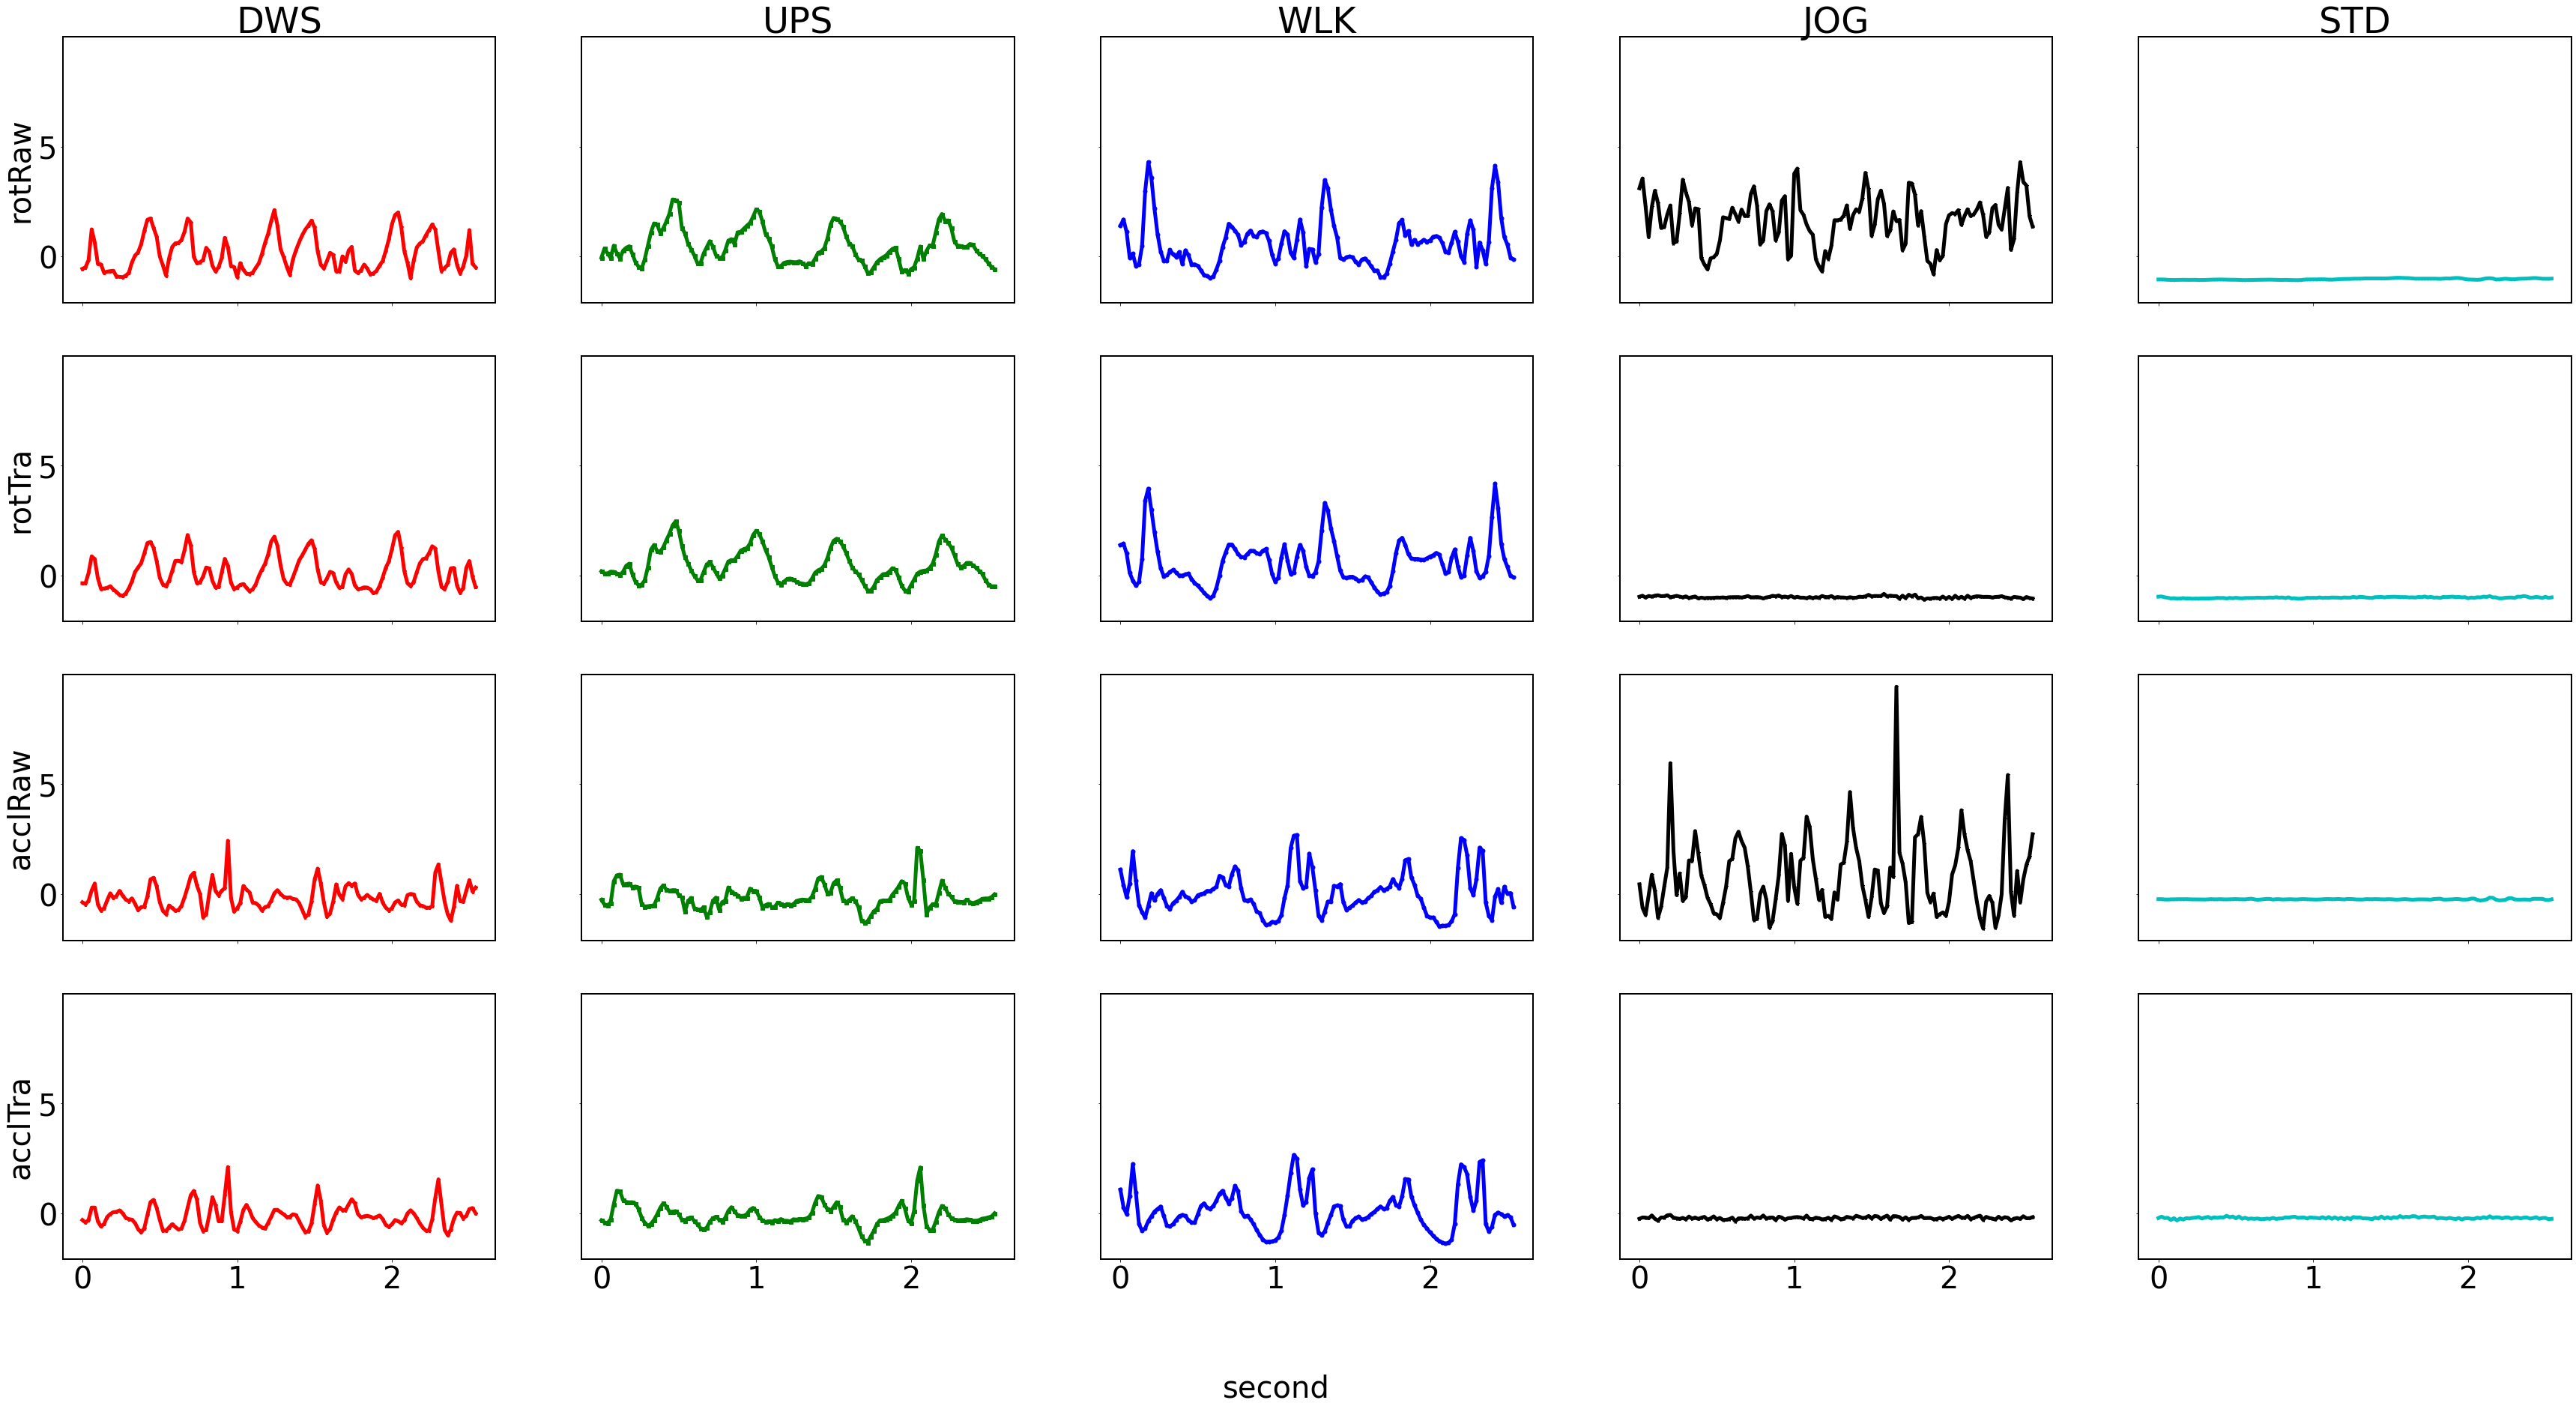

In [25]:
rnd_smpl= np.random.randint(100)
pts = 128
print("Random Test Sample: #"+str(rnd_smpl))
plot_signals(rnd_smpl, pts, test_data, rep_x_test)

##Replacement New Training scheme #02

In [26]:
#New training scheme
w_train_data2 = train_data[np.logical_or.reduce((act_train == 0., act_train == 1., act_train == 3.))]
b_train_data2 = train_data[act_train == 4.]
g_train_data2 = train_data[act_train == 2.]

print("[INFO] -- Shape of Train Grays :"+str(g_train_data2.shape))
print("[INFO] -- Shape of Train Blacks :"+str(b_train_data2.shape))
print("[INFO] -- Shape of Train Whites :"+str(w_train_data2.shape))

w_test_data2 = test_data[np.logical_or.reduce((act_test == 0., act_test == 1., act_test == 3.))]
b_test_data2 = test_data[act_test == 4.]
g_test_data2 = test_data[act_test == 2.]

print("[INFO] -- Shape of Test Grays :"+str(g_test_data2.shape))
print("[INFO] -- Shape of Test Blacks :"+str(b_test_data2.shape))
print("[INFO] -- Shape of Test Whites :"+str(w_test_data2.shape))

[INFO] -- Shape of Train Grays :(27290, 2, 128, 1)
[INFO] -- Shape of Train Blacks :(22176, 2, 128, 1)
[INFO] -- Shape of Train Whites :(32769, 2, 128, 1)
[INFO] -- Shape of Test Grays :(6225, 2, 128, 1)
[INFO] -- Shape of Test Blacks :(7857, 2, 128, 1)
[INFO] -- Shape of Test Whites :(7128, 2, 128, 1)


In [27]:
batch_size = 128
num_of_epochs = 100

rnd_idx_train2 = np.random.choice( g_train_data2.shape[0], b_train_data2.shape[0], replace=False)
tmp2 =  g_train_data2[rnd_idx_train2,:]
b_train_transformed2 = tmp2.copy()

x_train2 = np.append(w_train_data2, g_train_data2, axis=0)
x_train2 = np.append(x_train2, b_train_data2, axis=0)

x_train_transformed2 = np.append(w_train_data2, g_train_data2, axis=0)
x_train_transformed2 = np.append(x_train_transformed2 , b_train_transformed2, axis=0)

resh2 = np.prod(w_train_data2.shape[1:])

#### Replacement Autoencoder #######
inp = Input(shape=(w_train_data2.shape[1], w_train_data2.shape[2], 1))
x = Conv2D(64, (1,5), padding="same", kernel_regularizer=regularizers.l2(0.0001), activation="selu")(inp)
x = Conv2D(32, (1,5), padding="same", kernel_regularizer=regularizers.l2(0.0001), activation="selu")(x)
x = Conv2D(1, (1,5), padding="same", kernel_regularizer=regularizers.l2(0.0001), activation="selu")(x)
x = BatchNormalization()(x)
x = Reshape((resh,))(x)
x = Dense(resh, activation='selu')(x)
x = BatchNormalization()(x)
x = Dense(resh//2, kernel_regularizer=regularizers.l2(0.0001), activation='selu')(x)
x = BatchNormalization()(x)
x = Dense(resh, activation='selu')(x)
x = BatchNormalization()(x)
x = Reshape((w_train_data.shape[1], w_train_data.shape[2], 1))(x)
x = Conv2D(32, (1,5), padding="same", kernel_regularizer=regularizers.l2(0.0001), activation="selu")(x)
x = Conv2D(64, (1,5), padding="same", kernel_regularizer=regularizers.l2(0.0001), activation="selu")(x)
out = Conv2D(1, (1,5), padding="same", kernel_regularizer=regularizers.l2(0.0001), activation="linear")(x)

raet2 = Model(inp, out)

print(raet2.summary())

## Callbacks
eval_metric= "val_loss"    
early_stop = keras.callbacks.EarlyStopping(monitor = eval_metric, mode = 'min', patience = 20)
filepath="rae_best2.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor=eval_metric, verbose=0, save_best_only=True, mode='min')
callbacks_list = [early_stop,checkpoint]

raet2.compile(optimizer='adam', loss='mse')

x_train2, x_train_transformed2 = shuffle(x_train2, x_train_transformed2)

raet2.fit(x_train2 , x_train_transformed2,
                validation_split = 0.1,
                epochs = num_of_epochs,
                batch_size = batch_size,
                shuffle = True,
                verbose = 0,
                callbacks = callbacks_list
                )

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 2, 128, 1)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 2, 128, 64)        384       
                                                                 
 conv2d_13 (Conv2D)          (None, 2, 128, 32)        10272     
                                                                 
 conv2d_14 (Conv2D)          (None, 2, 128, 1)         161       
                                                                 
 batch_normalization_14 (Bat  (None, 2, 128, 1)        4         
 chNormalization)                                                
                                                                 
 reshape_2 (Reshape)         (None, 256)               0         
                                                           

In [28]:
rae2 = load_model("rae_best2.hdf5")

rep_x_test2 = test_data.copy()
rep_x_test2 = rae2.predict(rep_x_test2, verbose=1)

from keras.models import load_model
eval_act2 = load_model("HAR_Comb.hdf5")
X2 = rep_x_test2
Y2 = act_test_labels
print_results(eval_act2, X2, Y2)

663/663 [==============================] - 2s 3ms/step
663/663 - 2s - loss: 7.6890 - acc: 0.5954 - 2s/epoch - 3ms/step
***[RESULT]*** ACT Accuracy: 59.540000000000006
663/663 [==============================] - 2s 2ms/step
***[RESULT]*** ACT  Confusion Matrix
dws | ups | wlk | jog | std
[[93.8  6.1  0.   0.2  0. ]
 [ 0.4 99.6  0.   0.   0. ]
 [ 3.7  5.  91.2  0.1  0. ]
 [ 0.4  1.4  0.  98.3  0. ]
 [ 0.  99.5  0.5  0.   0. ]]
***[RESULT]*** ACT Averaged F-1 Score : 64.46813412810371


Random Test Sample: #25


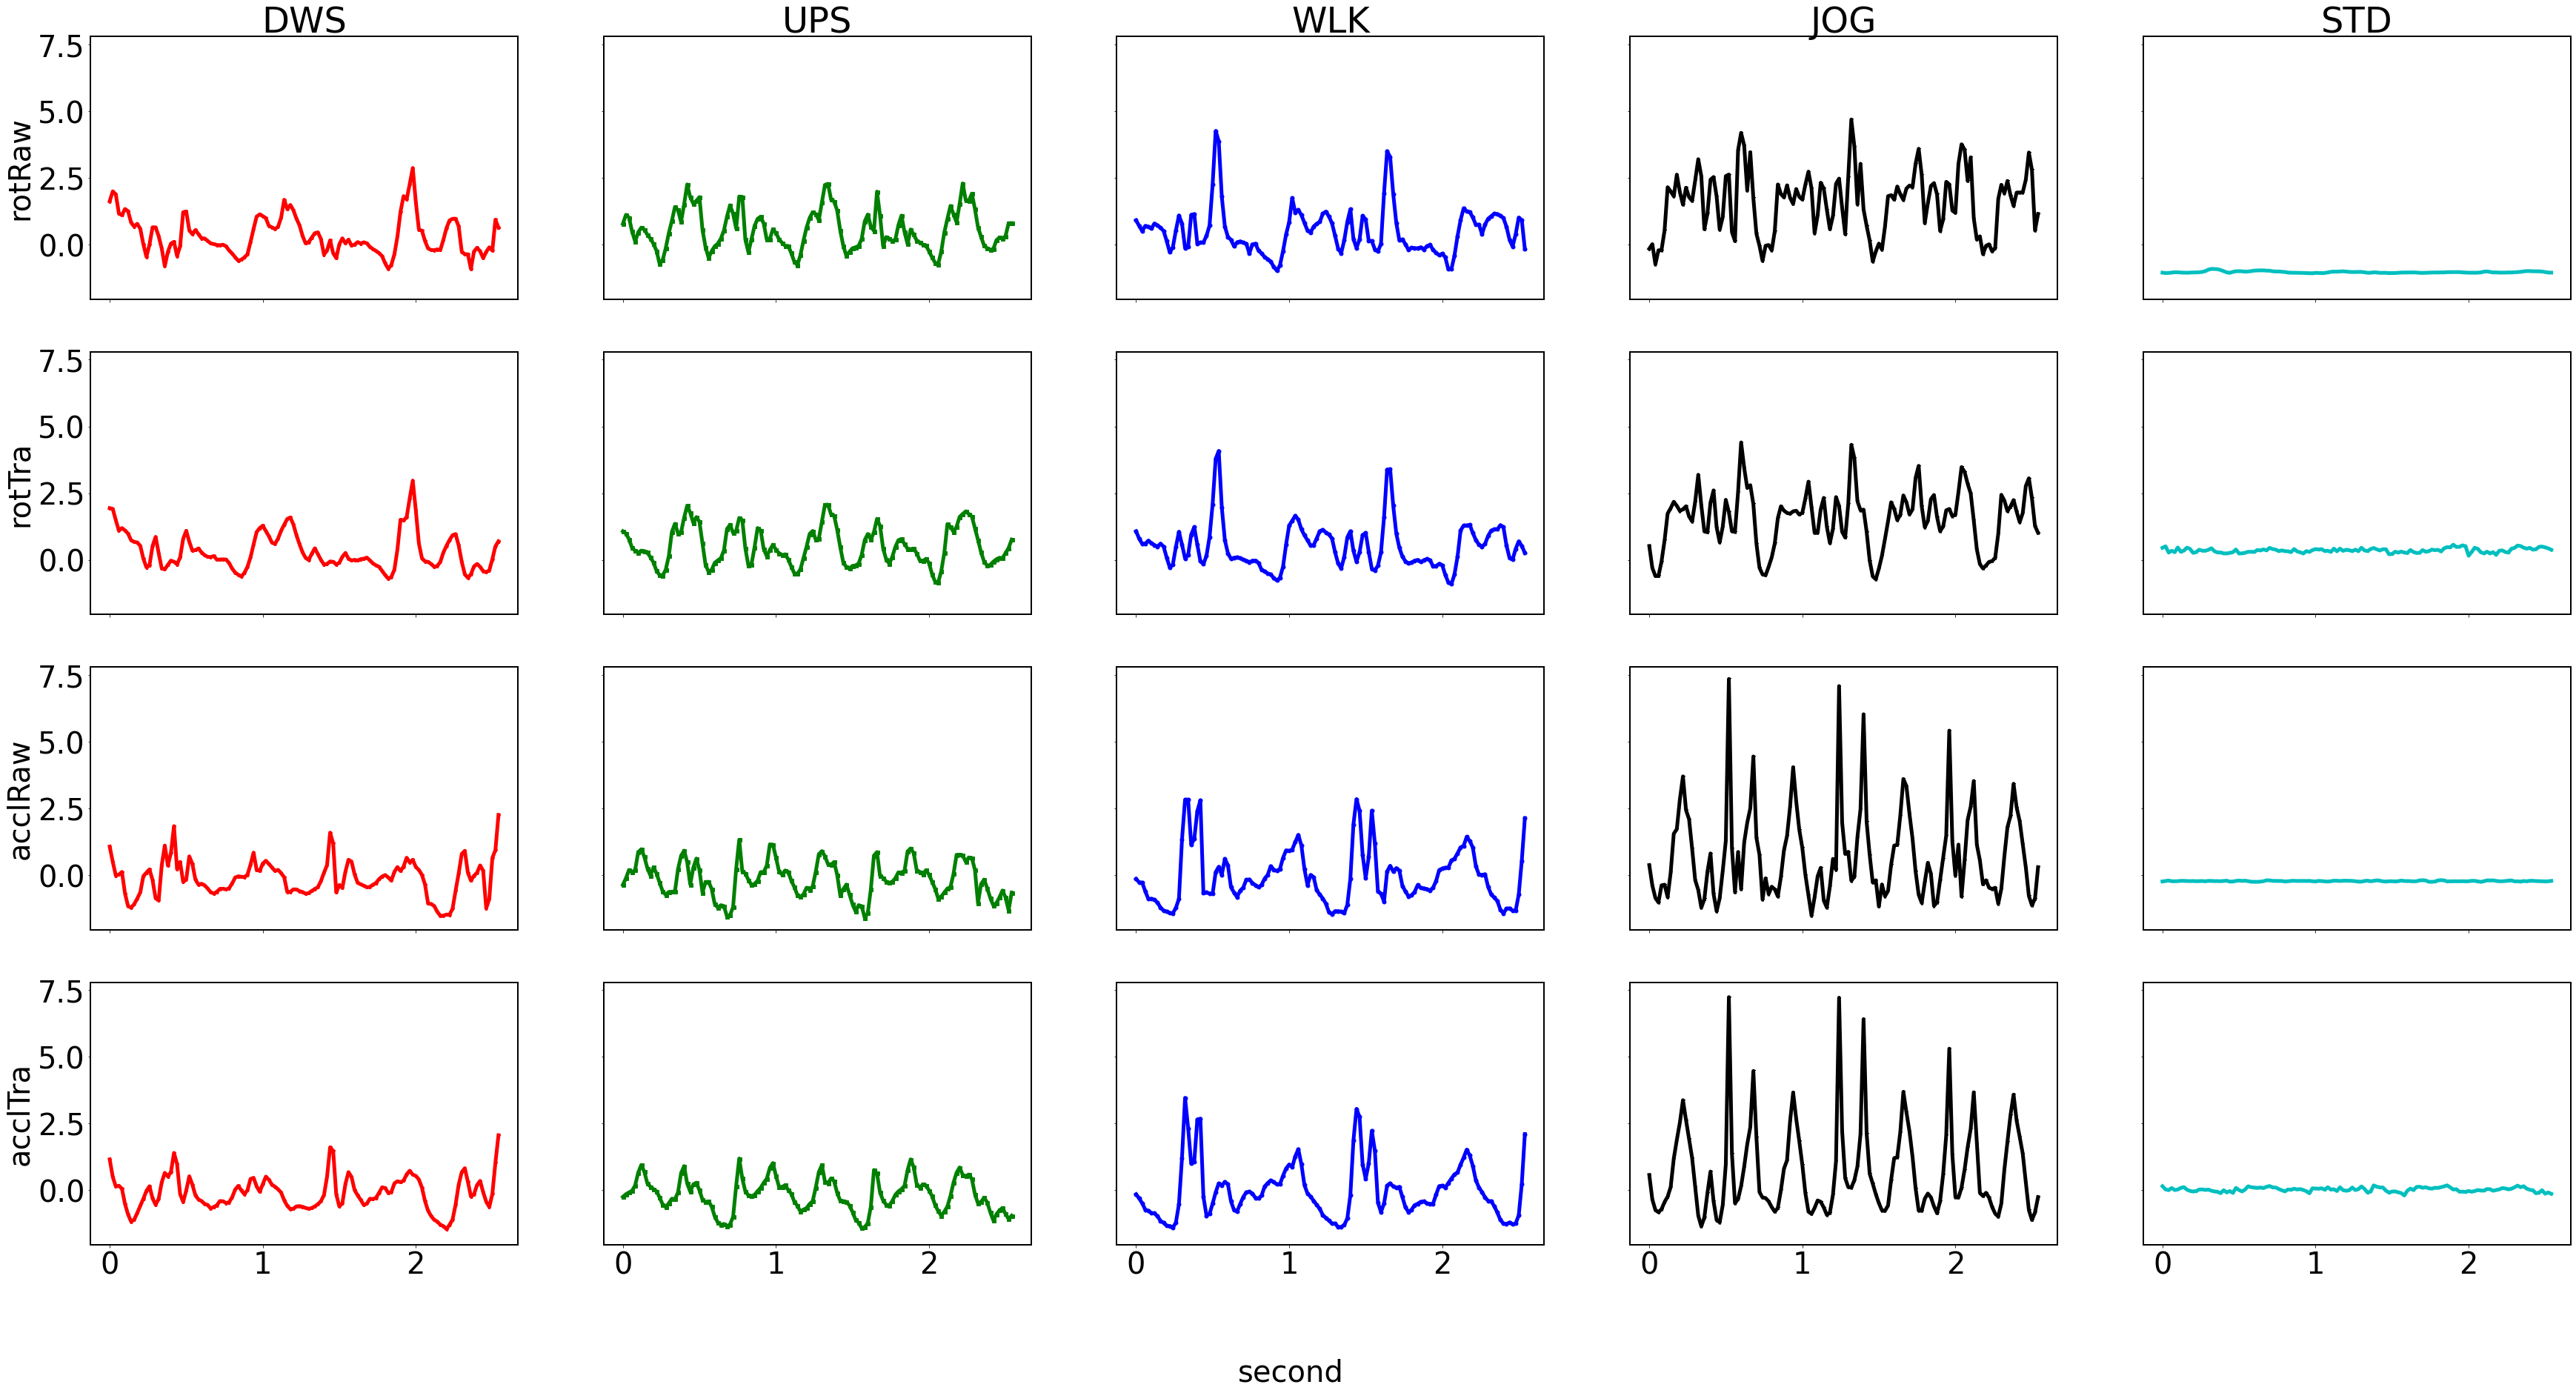

In [29]:
rnd_smpl2= np.random.randint(100)
pts = 128
print("Random Test Sample: #"+str(rnd_smpl2))
plot_signals(rnd_smpl2, pts, test_data, rep_x_test2)

##Replacement New Training scheme #03

In [30]:
w_train_data3 = train_data[np.logical_or.reduce((act_train == 1., act_train == 3., act_train == 4.))]
b_train_data3 = train_data[act_train == 0.]
g_train_data3 = train_data[act_train == 2.]

print("[INFO] -- Shape of Train Grays :"+str(g_train_data3.shape))
print("[INFO] -- Shape of Train Blacks :"+str(b_train_data3.shape))
print("[INFO] -- Shape of Train Whites :"+str(w_train_data3.shape))

w_test_data3 = test_data[np.logical_or.reduce((act_test == 1., act_test == 3., act_test == 4.))]
b_test_data3 = test_data[act_test == 0.]
g_test_data3 = test_data[act_test == 2.]

print("[INFO] -- Shape of Test Grays :"+str(g_test_data3.shape))
print("[INFO] -- Shape of Test Blacks :"+str(b_test_data3.shape))
print("[INFO] -- Shape of Test Whites :"+str(w_test_data3.shape))

[INFO] -- Shape of Train Grays :(27290, 2, 128, 1)
[INFO] -- Shape of Train Blacks :(10321, 2, 128, 1)
[INFO] -- Shape of Train Whites :(44624, 2, 128, 1)
[INFO] -- Shape of Test Grays :(6225, 2, 128, 1)
[INFO] -- Shape of Test Blacks :(1947, 2, 128, 1)
[INFO] -- Shape of Test Whites :(13038, 2, 128, 1)


In [31]:
batch_size = 128
num_of_epochs = 100

rnd_idx_train3 = np.random.choice( g_train_data3.shape[0], b_train_data3.shape[0], replace=False)
tmp3 =  g_train_data3[rnd_idx_train3,:]
b_train_transformed3 = tmp3.copy()

x_train3 = np.append(w_train_data3, g_train_data3, axis=0)
x_train3 = np.append(x_train3, b_train_data3, axis=0)

x_train_transformed3 = np.append(w_train_data3, g_train_data3, axis=0)
x_train_transformed3 = np.append(x_train_transformed3 , b_train_transformed3, axis=0)

resh3 = np.prod(w_train_data3.shape[1:])

#### Replacement Autoencoder #######
inp = Input(shape=(w_train_data3.shape[1], w_train_data3.shape[2], 1))
x = Conv2D(64, (1,5), padding="same", kernel_regularizer=regularizers.l2(0.0001), activation="selu")(inp)
x = Conv2D(32, (1,5), padding="same", kernel_regularizer=regularizers.l2(0.0001), activation="selu")(x)
x = Conv2D(1, (1,5), padding="same", kernel_regularizer=regularizers.l2(0.0001), activation="selu")(x)
x = BatchNormalization()(x)
x = Reshape((resh,))(x)
x = Dense(resh, activation='selu')(x)
x = BatchNormalization()(x)
x = Dense(resh//2, kernel_regularizer=regularizers.l2(0.0001), activation='selu')(x)
x = BatchNormalization()(x)
x = Dense(resh, activation='selu')(x)
x = BatchNormalization()(x)
x = Reshape((w_train_data.shape[1], w_train_data.shape[2], 1))(x)
x = Conv2D(32, (1,5), padding="same", kernel_regularizer=regularizers.l2(0.0001), activation="selu")(x)
x = Conv2D(64, (1,5), padding="same", kernel_regularizer=regularizers.l2(0.0001), activation="selu")(x)
out = Conv2D(1, (1,5), padding="same", kernel_regularizer=regularizers.l2(0.0001), activation="linear")(x)

raet3 = Model(inp, out)

print(raet3.summary())

## Callbacks
eval_metric= "val_loss"    
early_stop = keras.callbacks.EarlyStopping(monitor = eval_metric, mode = 'min', patience = 20)
filepath="rae_best3.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor=eval_metric, verbose=0, save_best_only=True, mode='min')
callbacks_list = [early_stop,checkpoint]

raet3.compile(optimizer='adam', loss='mse')

x_train3, x_train_transformed3 = shuffle(x_train3, x_train_transformed3)

raet3.fit(x_train3 , x_train_transformed3,
                validation_split = 0.1,
                epochs = num_of_epochs,
                batch_size = batch_size,
                shuffle = True,
                verbose = 0,
                callbacks = callbacks_list
                )

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 2, 128, 1)]       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 2, 128, 64)        384       
                                                                 
 conv2d_19 (Conv2D)          (None, 2, 128, 32)        10272     
                                                                 
 conv2d_20 (Conv2D)          (None, 2, 128, 1)         161       
                                                                 
 batch_normalization_18 (Bat  (None, 2, 128, 1)        4         
 chNormalization)                                                
                                                                 
 reshape_4 (Reshape)         (None, 256)               0         
                                                           

In [32]:
rae3 = load_model("rae_best3.hdf5")

rep_x_test3 = test_data.copy()
rep_x_test3 = rae3.predict(rep_x_test3, verbose=1)

from keras.models import load_model
eval_act3 = load_model("HAR_Comb.hdf5")
X3 = rep_x_test3
Y3 = act_test_labels
print_results(eval_act3, X3, Y3)

663/663 [==============================] - 2s 3ms/step
663/663 - 2s - loss: 1.2640 - acc: 0.8653 - 2s/epoch - 3ms/step
***[RESULT]*** ACT Accuracy: 86.53
663/663 [==============================] - 3s 3ms/step
***[RESULT]*** ACT  Confusion Matrix
dws | ups | wlk | jog | std
[[ 9.3 90.6  0.1  0.   0. ]
 [ 0.4 99.4  0.1  0.   0. ]
 [ 3.3  7.2 89.2  0.3  0. ]
 [ 0.   4.1  0.  95.9  0. ]
 [ 0.   3.7  0.   0.  96.2]]
***[RESULT]*** ACT Averaged F-1 Score : 74.15650671191594


Random Test Sample: #8


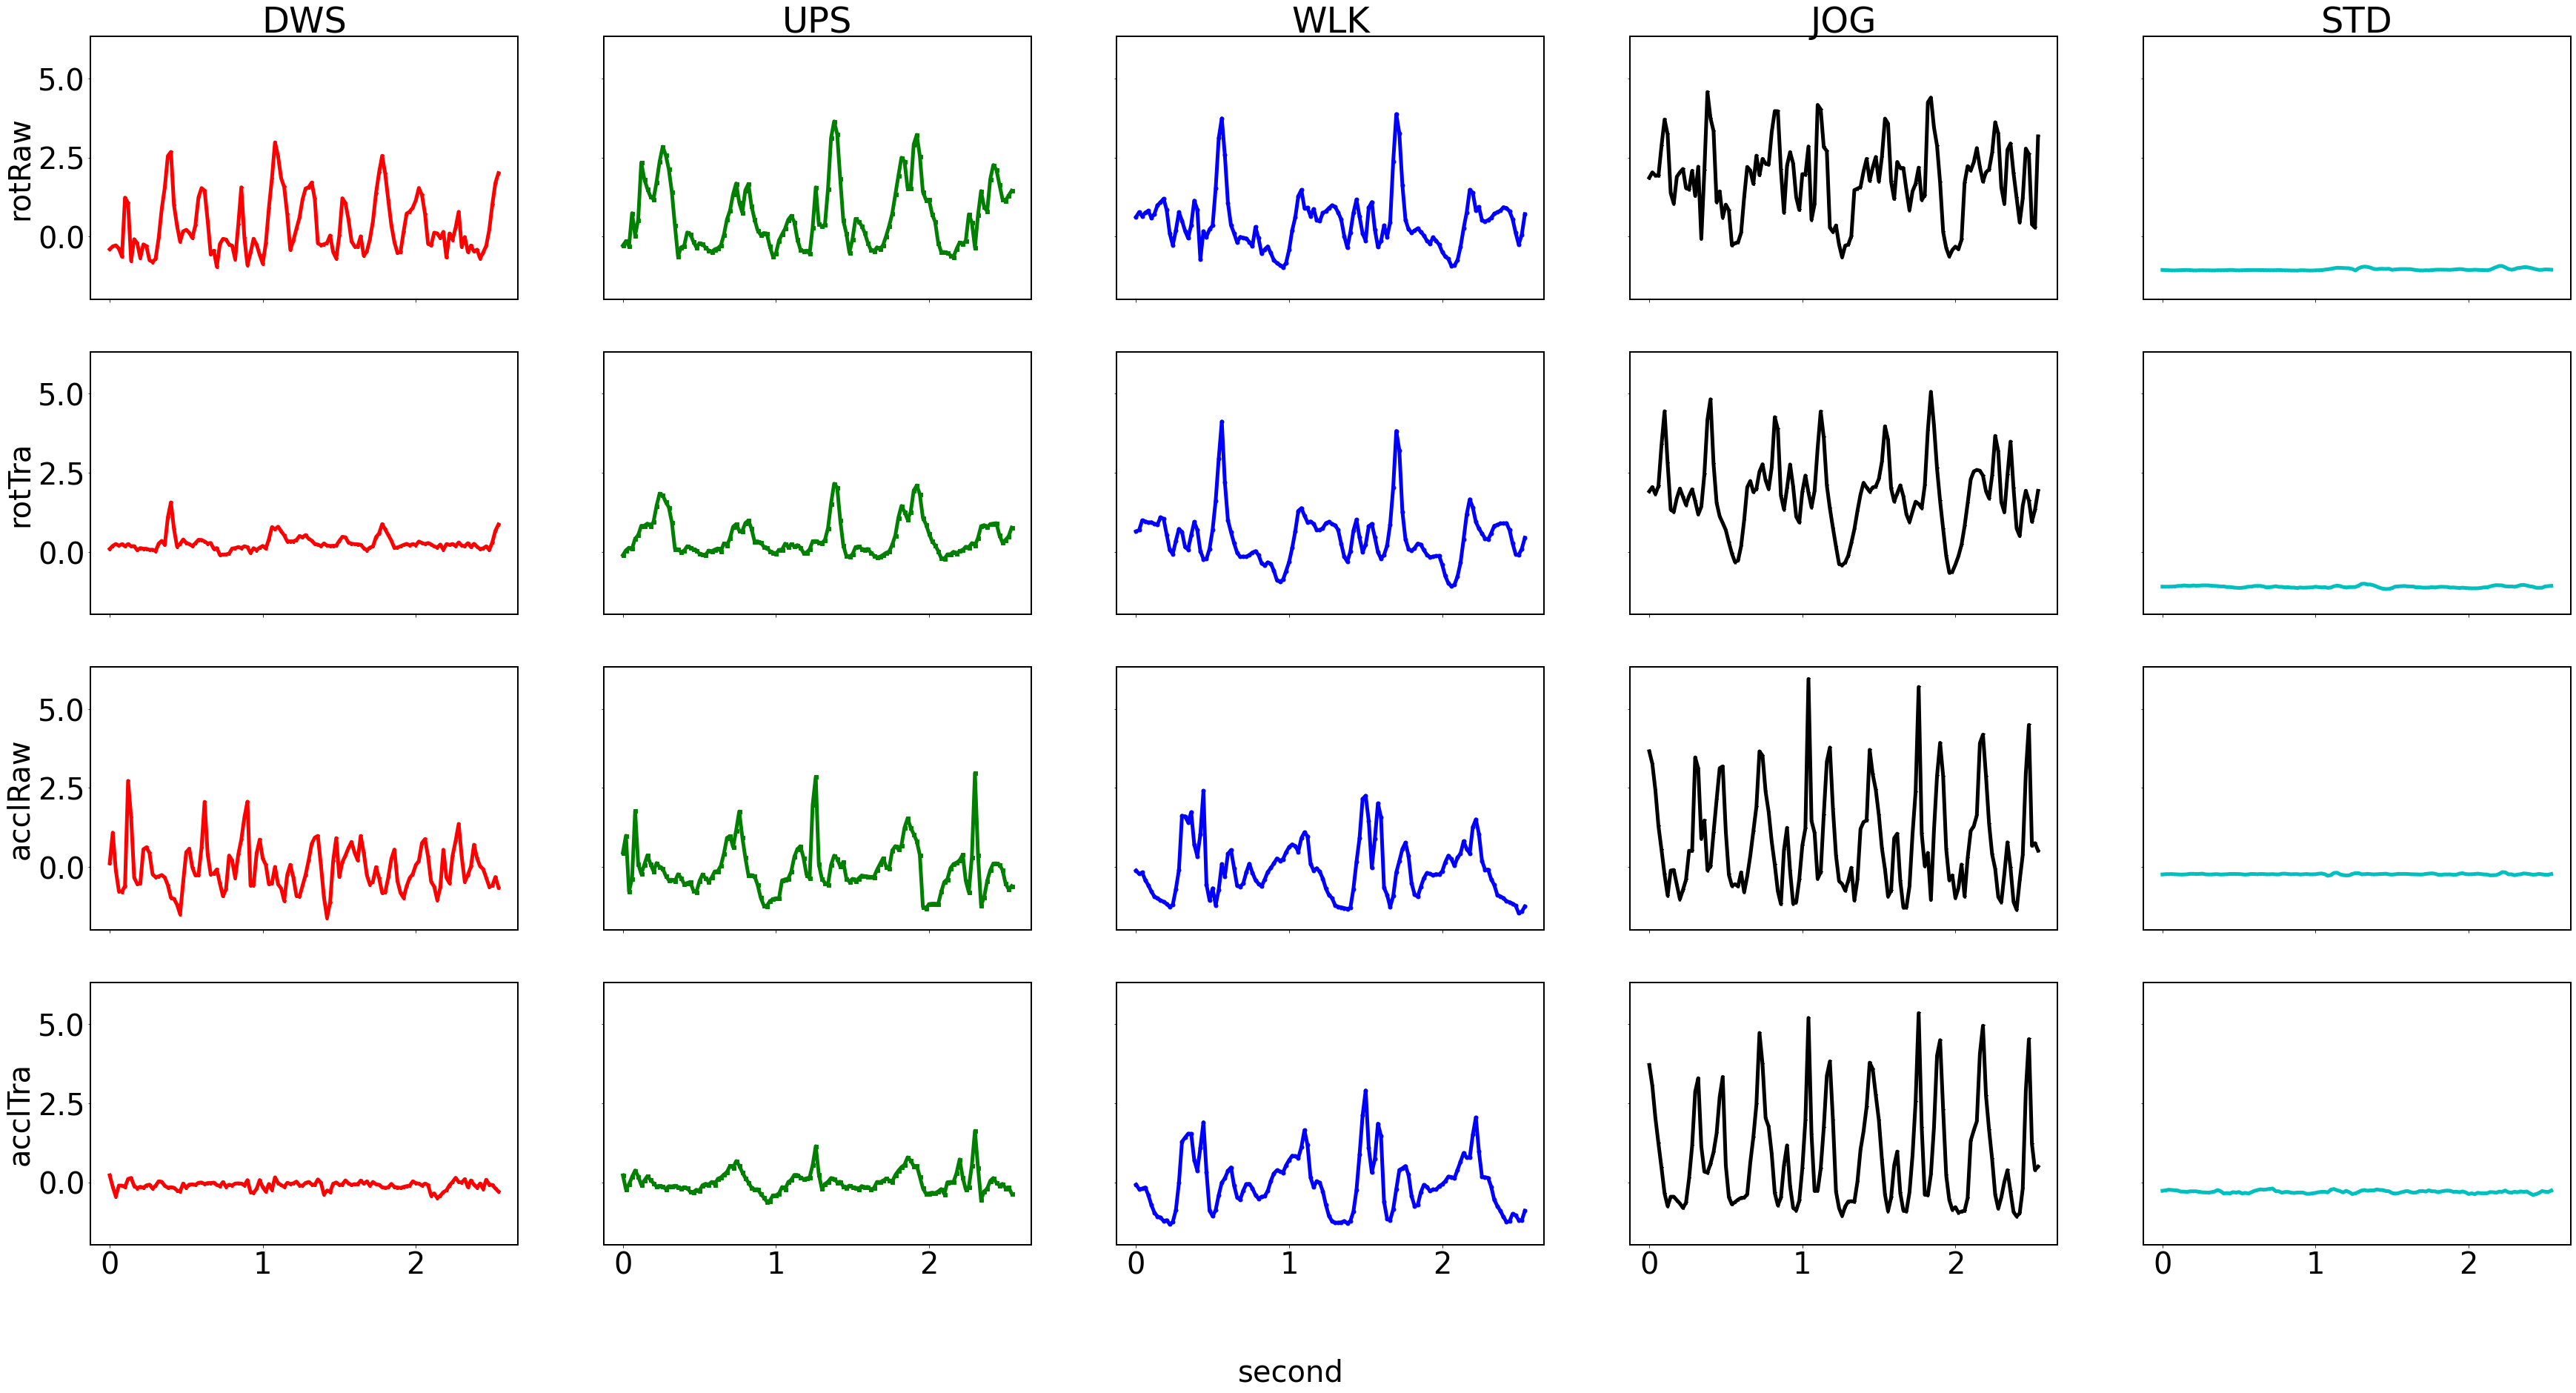

In [33]:
rnd_smpl3= np.random.randint(100)
pts = 128
print("Random Test Sample: #"+str(rnd_smpl3))
plot_signals(rnd_smpl3, pts, test_data, rep_x_test3)

##Replacement New Training scheme #04

In [34]:
w_train_data4 = train_data[np.logical_or.reduce((act_train == 0., act_train == 2., act_train == 3.))]
b_train_data4 = train_data[act_train == 1.]
g_train_data4 = train_data[act_train == 4.]

print("[INFO] -- Shape of Train Grays :"+str(g_train_data4.shape))
print("[INFO] -- Shape of Train Blacks :"+str(b_train_data4.shape))
print("[INFO] -- Shape of Train Whites :"+str(w_train_data4.shape))

w_test_data4 = test_data[np.logical_or.reduce((act_test == 0., act_test == 2., act_test == 3.))]
b_test_data4 = test_data[act_test == 1.]
g_test_data4 = test_data[act_test == 4.]

print("[INFO] -- Shape of Test Grays :"+str(g_test_data4.shape))
print("[INFO] -- Shape of Test Blacks :"+str(b_test_data4.shape))
print("[INFO] -- Shape of Test Whites :"+str(w_test_data4.shape))

[INFO] -- Shape of Train Grays :(22176, 2, 128, 1)
[INFO] -- Shape of Train Blacks :(12319, 2, 128, 1)
[INFO] -- Shape of Train Whites :(47740, 2, 128, 1)
[INFO] -- Shape of Test Grays :(7857, 2, 128, 1)
[INFO] -- Shape of Test Blacks :(2495, 2, 128, 1)
[INFO] -- Shape of Test Whites :(10858, 2, 128, 1)


In [35]:
batch_size = 128
num_of_epochs = 100

rnd_idx_train4 = np.random.choice( g_train_data4.shape[0], b_train_data4.shape[0], replace=False)
tmp4 =  g_train_data4[rnd_idx_train4,:]
b_train_transformed4 = tmp4.copy()

x_train4 = np.append(w_train_data4, g_train_data4, axis=0)
x_train4 = np.append(x_train4, b_train_data4, axis=0)

x_train_transformed4 = np.append(w_train_data4, g_train_data4, axis=0)
x_train_transformed4 = np.append(x_train_transformed4 , b_train_transformed4, axis=0)

resh4 = np.prod(w_train_data4.shape[1:])

#### Replacement Autoencoder #######
inp = Input(shape=(w_train_data4.shape[1], w_train_data4.shape[2], 1))
x = Conv2D(64, (1,5), padding="same", kernel_regularizer=regularizers.l2(0.0001), activation="selu")(inp)
x = Conv2D(32, (1,5), padding="same", kernel_regularizer=regularizers.l2(0.0001), activation="selu")(x)
x = Conv2D(1, (1,5), padding="same", kernel_regularizer=regularizers.l2(0.0001), activation="selu")(x)
x = BatchNormalization()(x)
x = Reshape((resh,))(x)
x = Dense(resh, activation='selu')(x)
x = BatchNormalization()(x)
x = Dense(resh//2, kernel_regularizer=regularizers.l2(0.0001), activation='selu')(x)
x = BatchNormalization()(x)
x = Dense(resh, activation='selu')(x)
x = BatchNormalization()(x)
x = Reshape((w_train_data.shape[1], w_train_data.shape[2], 1))(x)
x = Conv2D(32, (1,5), padding="same", kernel_regularizer=regularizers.l2(0.0001), activation="selu")(x)
x = Conv2D(64, (1,5), padding="same", kernel_regularizer=regularizers.l2(0.0001), activation="selu")(x)
out = Conv2D(1, (1,5), padding="same", kernel_regularizer=regularizers.l2(0.0001), activation="linear")(x)

raet4 = Model(inp, out)

print(raet4.summary())

## Callbacks
eval_metric= "val_loss"    
early_stop = keras.callbacks.EarlyStopping(monitor = eval_metric, mode = 'min', patience = 20)
filepath="rae_best4.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor=eval_metric, verbose=0, save_best_only=True, mode='min')
callbacks_list = [early_stop,checkpoint]

raet4.compile(optimizer='adam', loss='mse')

x_train4, x_train_transformed4 = shuffle(x_train4, x_train_transformed4)

raet3.fit(x_train4 , x_train_transformed4,
                validation_split = 0.1,
                epochs = num_of_epochs,
                batch_size = batch_size,
                shuffle = True,
                verbose = 0,
                callbacks = callbacks_list
                )

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 2, 128, 1)]       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 2, 128, 64)        384       
                                                                 
 conv2d_25 (Conv2D)          (None, 2, 128, 32)        10272     
                                                                 
 conv2d_26 (Conv2D)          (None, 2, 128, 1)         161       
                                                                 
 batch_normalization_22 (Bat  (None, 2, 128, 1)        4         
 chNormalization)                                                
                                                                 
 reshape_6 (Reshape)         (None, 256)               0         
                                                           

In [36]:
rae4 = load_model("rae_best4.hdf5")

rep_x_test4 = test_data.copy()
rep_x_test4 = rae4.predict(rep_x_test4, verbose=1)

from keras.models import load_model
eval_act4 = load_model("HAR_Comb.hdf5")
X4 = rep_x_test4
Y4 = act_test_labels
print_results(eval_act4, X4, Y4)

663/663 [==============================] - 2s 3ms/step
663/663 - 2s - loss: 0.8265 - acc: 0.8499 - 2s/epoch - 3ms/step
***[RESULT]*** ACT Accuracy: 84.99
663/663 [==============================] - 2s 2ms/step
***[RESULT]*** ACT  Confusion Matrix
dws | ups | wlk | jog | std
[[89.6  6.9  1.6  0.2  1.6]
 [ 5.9 29.   6.3  0.  58.8]
 [ 8.7  8.1 83.1  0.2  0. ]
 [ 1.3  2.2  0.  96.5  0. ]
 [ 0.   0.4  0.5  0.  99.2]]
***[RESULT]*** ACT Averaged F-1 Score : 78.73583162636028


Random Test Sample: #73


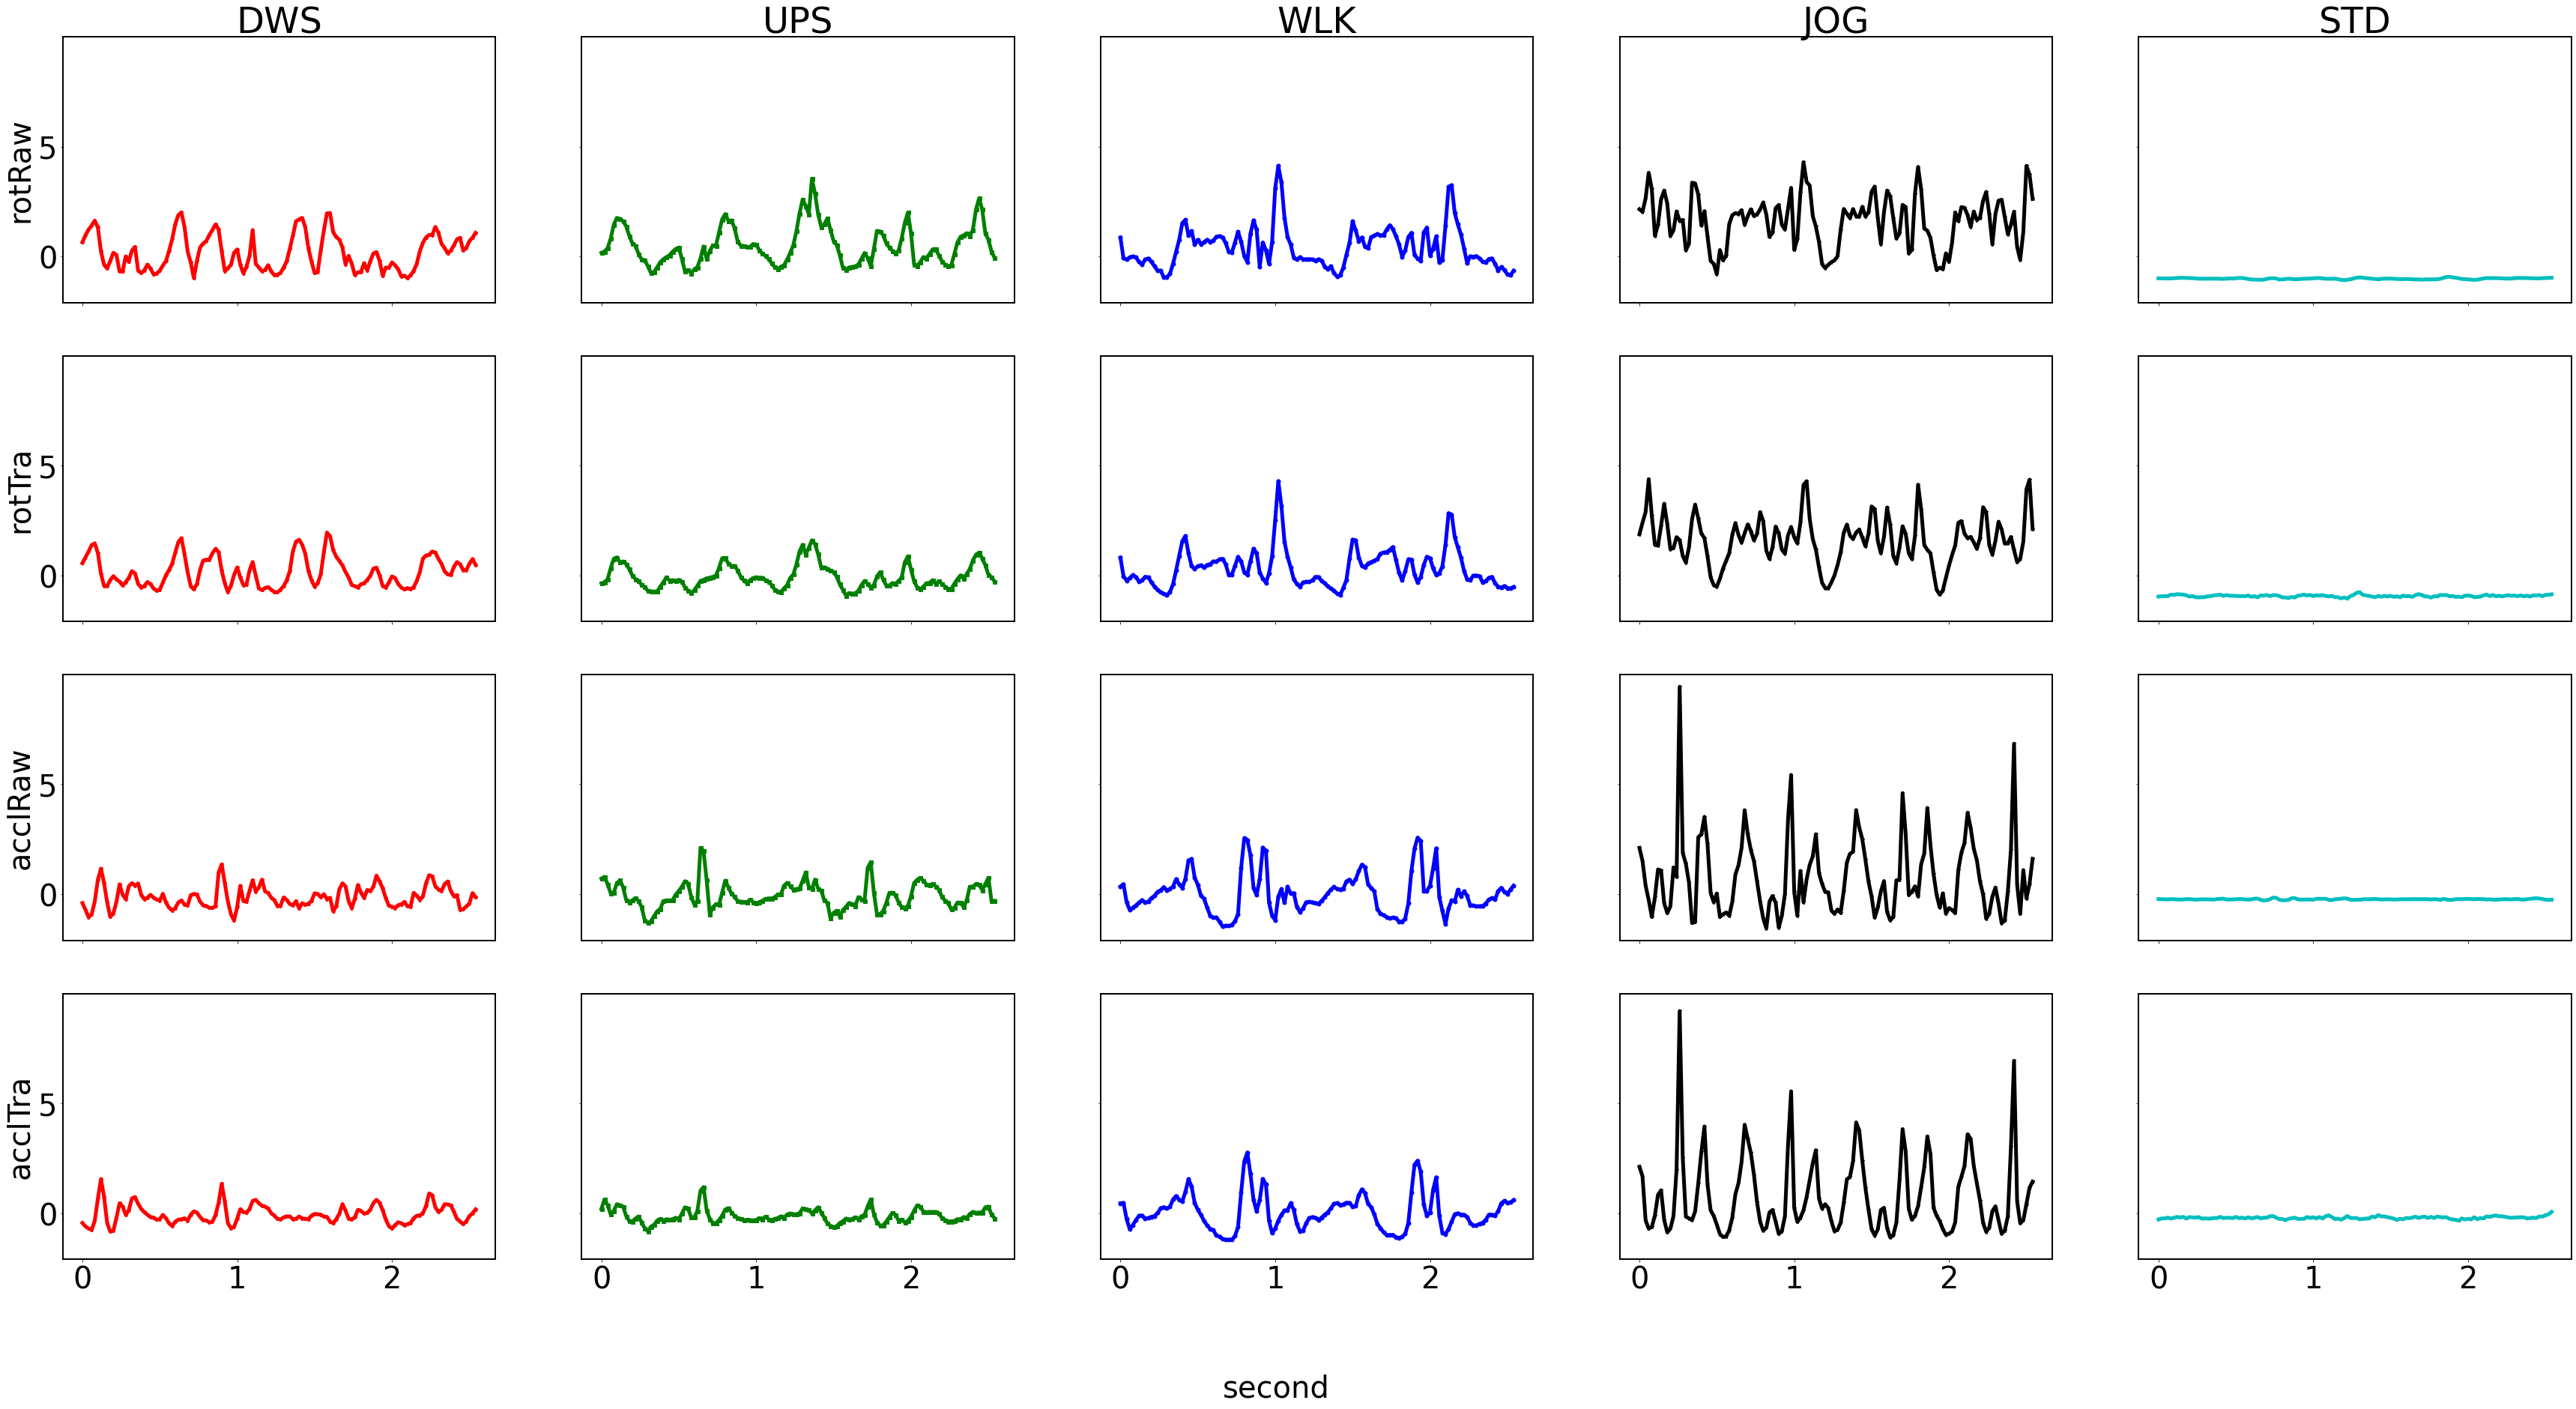

In [37]:
rnd_smpl4= np.random.randint(100)
pts = 128
print("Random Test Sample: #"+str(rnd_smpl4))
plot_signals(rnd_smpl4, pts, test_data, rep_x_test4)

##Replacement New Training scheme #05

In [38]:
w_train_data5 = train_data[np.logical_or.reduce((act_train == 0., act_train == 1.))]
b_train_data5 = train_data[act_train == 2.]
g_train_data5 = train_data[np.logical_or.reduce((act_train == 3.,act_train == 4.))]

print("[INFO] -- Shape of Train Grays :"+str(g_train_data5.shape))
print("[INFO] -- Shape of Train Blacks :"+str(b_train_data5.shape))
print("[INFO] -- Shape of Train Whites :"+str(w_train_data5.shape))

w_test_data5 = test_data[np.logical_or.reduce((act_test == 0., act_test == 1.))]
b_test_data5 = test_data[act_test == 2.]
g_test_data5 = test_data[np.logical_or.reduce((act_test == 3.,act_test == 4.))]

print("[INFO] -- Shape of Test Grays :"+str(g_test_data5.shape))
print("[INFO] -- Shape of Test Blacks :"+str(b_test_data5.shape))
print("[INFO] -- Shape of Test Whites :"+str(w_test_data5.shape))

[INFO] -- Shape of Train Grays :(32305, 2, 128, 1)
[INFO] -- Shape of Train Blacks :(27290, 2, 128, 1)
[INFO] -- Shape of Train Whites :(22640, 2, 128, 1)
[INFO] -- Shape of Test Grays :(10543, 2, 128, 1)
[INFO] -- Shape of Test Blacks :(6225, 2, 128, 1)
[INFO] -- Shape of Test Whites :(4442, 2, 128, 1)


In [39]:
batch_size = 128
num_of_epochs = 100

rnd_idx_train5 = np.random.choice( g_train_data5.shape[0], b_train_data5.shape[0], replace=False)
tmp5 =  g_train_data5[rnd_idx_train5,:]
b_train_transformed5 = tmp5.copy()

x_train5 = np.append(w_train_data5, g_train_data5, axis=0)
x_train5 = np.append(x_train5, b_train_data5, axis=0)

x_train_transformed5 = np.append(w_train_data5, g_train_data5, axis=0)
x_train_transformed5 = np.append(x_train_transformed5 , b_train_transformed5, axis=0)

resh5 = np.prod(w_train_data5.shape[1:])

#### Replacement Autoencoder #######
inp = Input(shape=(w_train_data5.shape[1], w_train_data5.shape[2], 1))
x = Conv2D(64, (1,5), padding="same", kernel_regularizer=regularizers.l2(0.0001), activation="selu")(inp)
x = Conv2D(32, (1,5), padding="same", kernel_regularizer=regularizers.l2(0.0001), activation="selu")(x)
x = Conv2D(1, (1,5), padding="same", kernel_regularizer=regularizers.l2(0.0001), activation="selu")(x)
x = BatchNormalization()(x)
x = Reshape((resh,))(x)
x = Dense(resh, activation='selu')(x)
x = BatchNormalization()(x)
x = Dense(resh//2, kernel_regularizer=regularizers.l2(0.0001), activation='selu')(x)
x = BatchNormalization()(x)
x = Dense(resh, activation='selu')(x)
x = BatchNormalization()(x)
x = Reshape((w_train_data.shape[1], w_train_data.shape[2], 1))(x)
x = Conv2D(32, (1,5), padding="same", kernel_regularizer=regularizers.l2(0.0001), activation="selu")(x)
x = Conv2D(64, (1,5), padding="same", kernel_regularizer=regularizers.l2(0.0001), activation="selu")(x)
out = Conv2D(1, (1,5), padding="same", kernel_regularizer=regularizers.l2(0.0001), activation="linear")(x)

raet5 = Model(inp, out)

print(raet5.summary())

## Callbacks
eval_metric= "val_loss"    
early_stop = keras.callbacks.EarlyStopping(monitor = eval_metric, mode = 'min', patience = 20)
filepath="rae_best5.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor=eval_metric, verbose=0, save_best_only=True, mode='min')
callbacks_list = [early_stop,checkpoint]

raet5.compile(optimizer='adam', loss='mse')

x_train5, x_train_transformed5 = shuffle(x_train5, x_train_transformed5)

raet5.fit(x_train5 , x_train_transformed5,
                validation_split = 0.1,
                epochs = num_of_epochs,
                batch_size = batch_size,
                shuffle = True,
                verbose = 0,
                callbacks = callbacks_list
                )

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 2, 128, 1)]       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 2, 128, 64)        384       
                                                                 
 conv2d_31 (Conv2D)          (None, 2, 128, 32)        10272     
                                                                 
 conv2d_32 (Conv2D)          (None, 2, 128, 1)         161       
                                                                 
 batch_normalization_26 (Bat  (None, 2, 128, 1)        4         
 chNormalization)                                                
                                                                 
 reshape_8 (Reshape)         (None, 256)               0         
                                                           

In [40]:
rae5 = load_model("rae_best5.hdf5")

rep_x_test5 = test_data.copy()
rep_x_test5 = rae5.predict(rep_x_test5, verbose=1)

from keras.models import load_model
eval_act5 = load_model("HAR_Comb.hdf5")
X5 = rep_x_test5
Y5 = act_test_labels
print_results(eval_act5, X5, Y5)

663/663 [==============================] - 2s 3ms/step
663/663 - 2s - loss: 0.6579 - acc: 0.9099 - 2s/epoch - 3ms/step
***[RESULT]*** ACT Accuracy: 90.99000000000001
663/663 [==============================] - 2s 2ms/step
***[RESULT]*** ACT  Confusion Matrix
dws | ups | wlk | jog | std
[[80.9 17.7  1.3  0.1  0. ]
 [ 0.4 95.4  4.2  0.   0. ]
 [ 0.6 20.4 78.9  0.   0. ]
 [ 0.8  2.8  0.  96.4  0. ]
 [ 0.   0.1  0.1  0.  99.8]]
***[RESULT]*** ACT Averaged F-1 Score : 89.05549758417489


Random Test Sample: #35


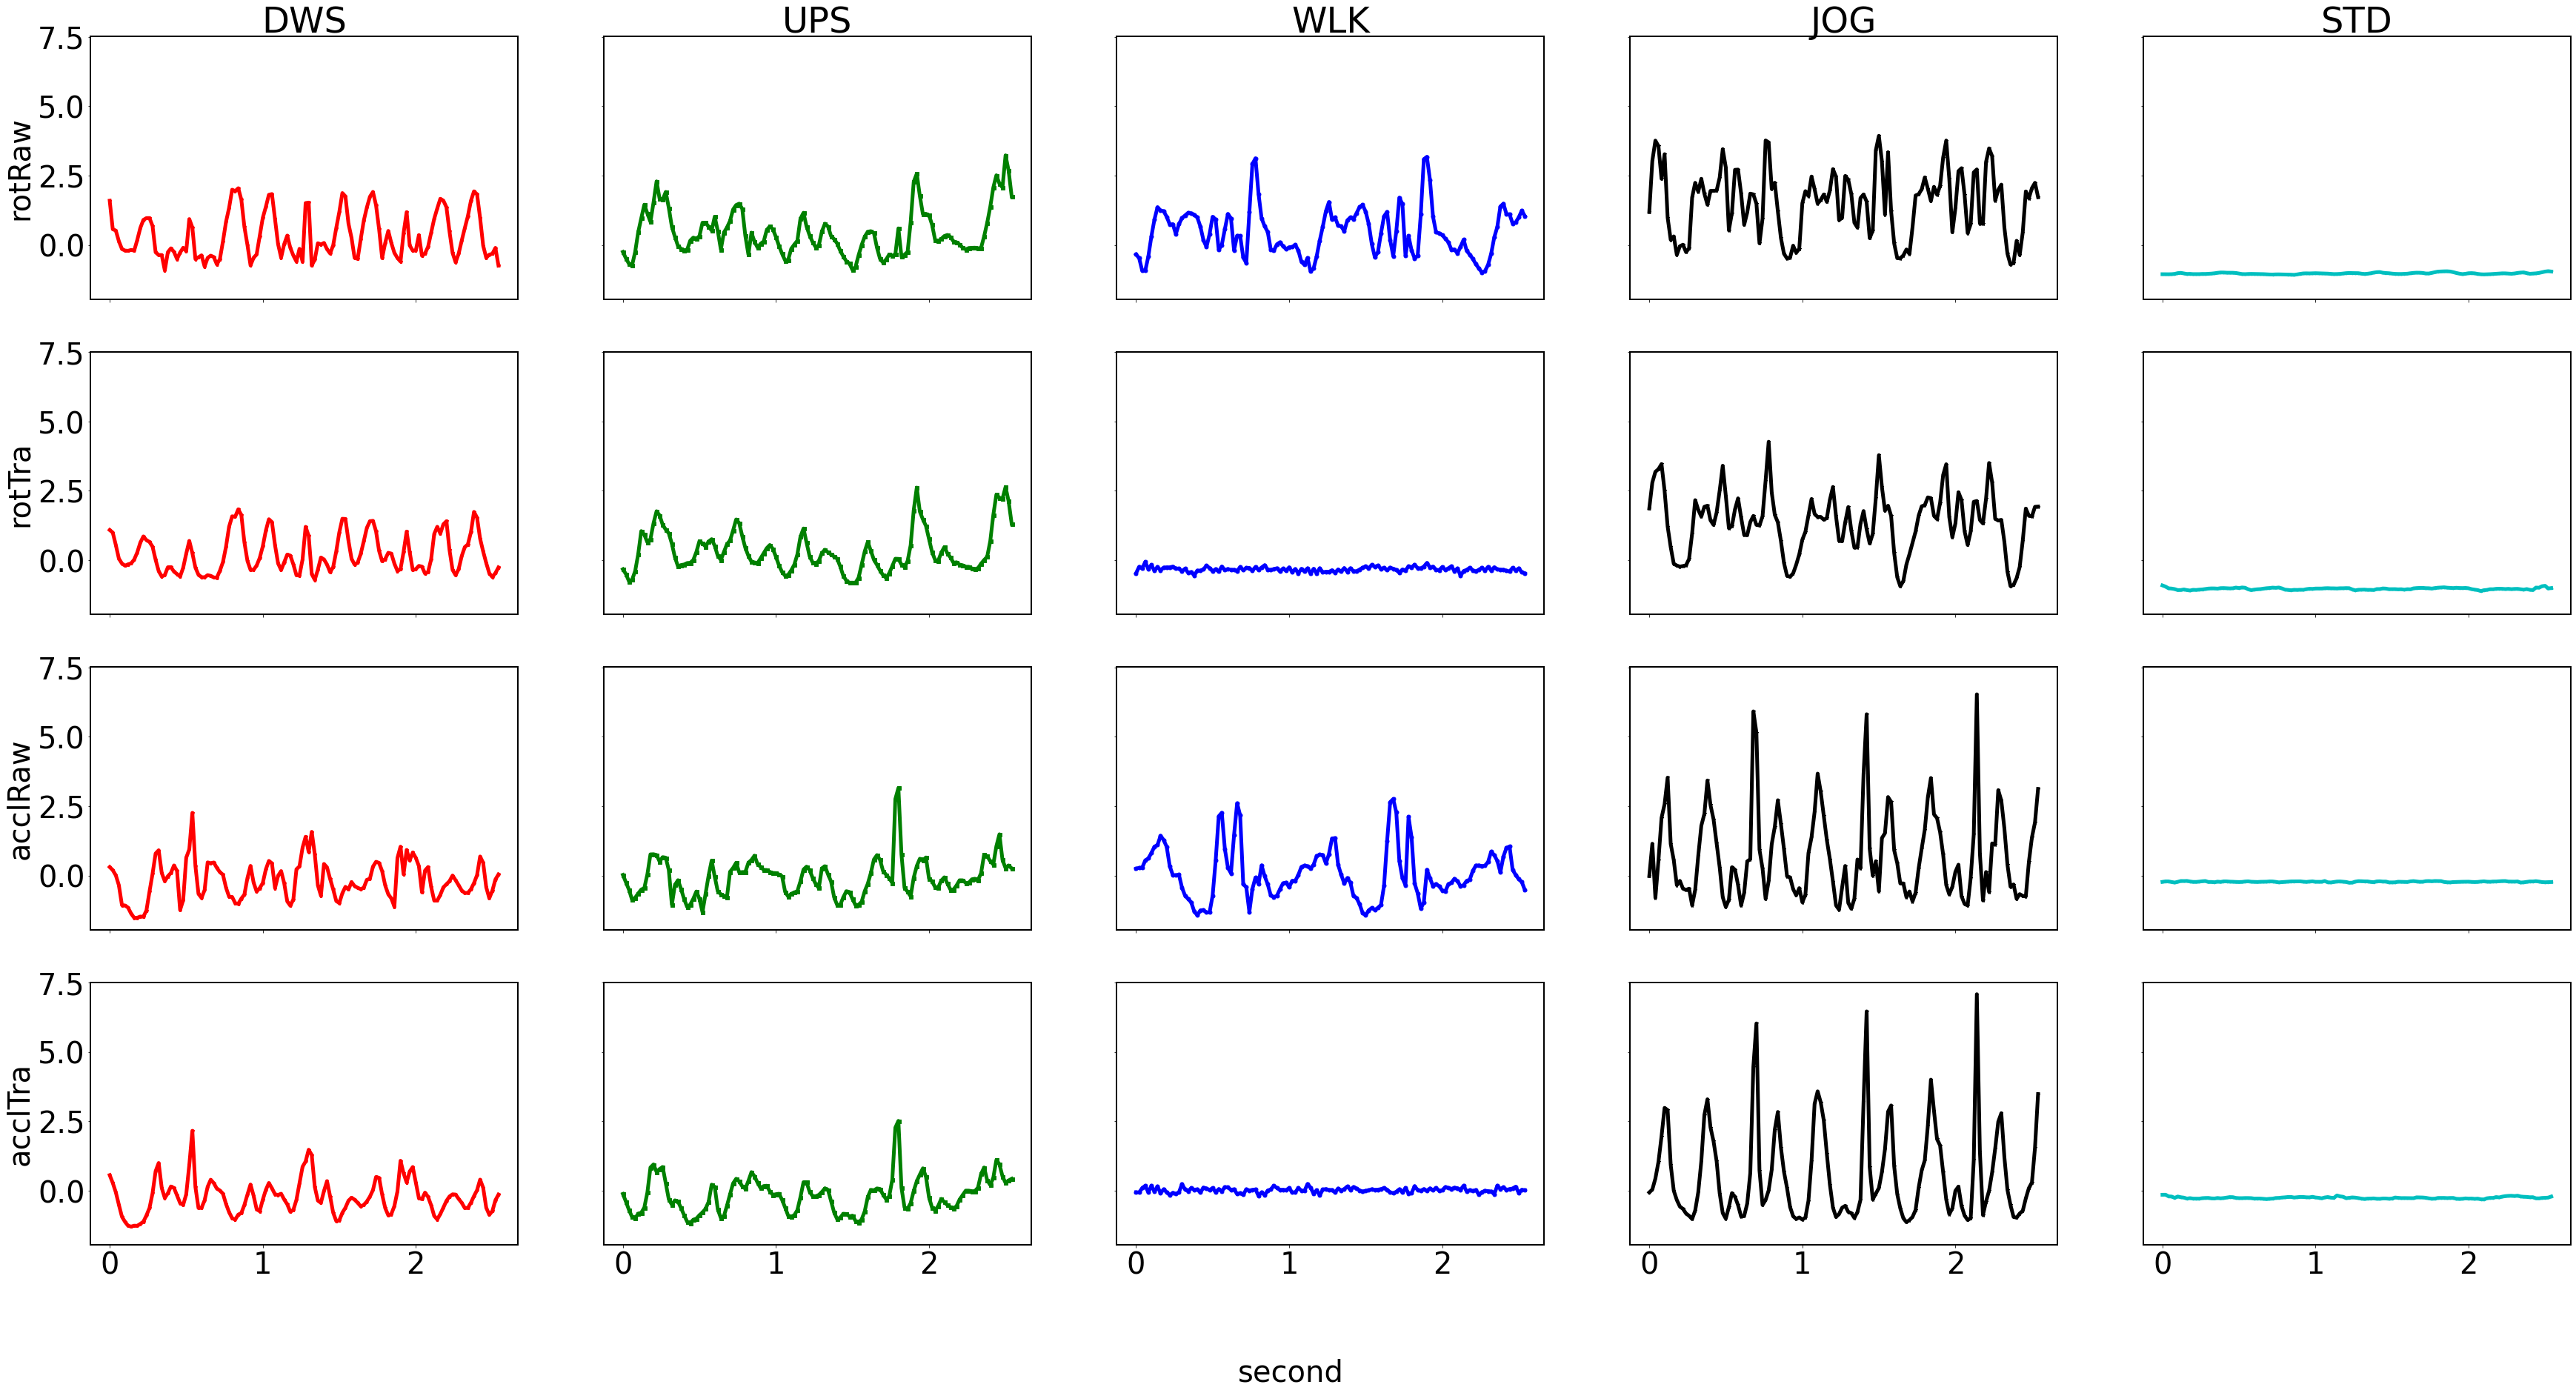

In [41]:
rnd_smpl5= np.random.randint(100)
pts = 128
print("Random Test Sample: #"+str(rnd_smpl5))
plot_signals(rnd_smpl5, pts, test_data, rep_x_test5)

##Replacement New Training scheme #06

In [71]:
w_train_data6 = train_data[np.logical_or.reduce((act_train == 1., act_train == 3., act_train == 4.))]
b_train_data6 = train_data[act_train == 0.]
g_train_data6 = train_data[act_train == 2.]

print("[INFO] -- Shape of Train Grays :"+str(g_train_data6.shape))
print("[INFO] -- Shape of Train Blacks :"+str(b_train_data6.shape))
print("[INFO] -- Shape of Train Whites :"+str(w_train_data6.shape))

w_test_data6 = test_data[np.logical_or.reduce((act_test == 1., act_test == 3., act_test == 4.))]
b_test_data6 = test_data[act_test == 0.]
g_test_data6 = test_data[act_test == 2.]

print("[INFO] -- Shape of Test Grays :"+str(g_test_data6.shape))
print("[INFO] -- Shape of Test Blacks :"+str(b_test_data6.shape))
print("[INFO] -- Shape of Test Whites :"+str(w_test_data6.shape))

[INFO] -- Shape of Train Grays :(27290, 2, 128, 1)
[INFO] -- Shape of Train Blacks :(10321, 2, 128, 1)
[INFO] -- Shape of Train Whites :(44624, 2, 128, 1)
[INFO] -- Shape of Test Grays :(6225, 2, 128, 1)
[INFO] -- Shape of Test Blacks :(1947, 2, 128, 1)
[INFO] -- Shape of Test Whites :(13038, 2, 128, 1)


In [72]:
batch_size = 128
num_of_epochs = 100

rnd_idx_train6 = np.random.choice( g_train_data6.shape[0], b_train_data6.shape[0], replace=False)
tmp6 =  g_train_data6[rnd_idx_train6,:]
b_train_transformed6 = tmp6.copy()

x_train6 = np.append(w_train_data6, g_train_data6, axis=0)
x_train6 = np.append(x_train6, b_train_data6, axis=0)

x_train_transformed6 = np.append(w_train_data6, g_train_data6, axis=0)
x_train_transformed6 = np.append(x_train_transformed6 , b_train_transformed6, axis=0)

resh6 = np.prod(w_train_data6.shape[1:])

#### Replacement Autoencoder #######
inp = Input(shape=(w_train_data6.shape[1], w_train_data6.shape[2], 1))
x = Conv2D(64, (1,5), padding="same", kernel_regularizer=regularizers.l2(0.0001), activation="selu")(inp)
x = Conv2D(32, (1,5), padding="same", kernel_regularizer=regularizers.l2(0.0001), activation="selu")(x)
x = Conv2D(1, (1,5), padding="same", kernel_regularizer=regularizers.l2(0.0001), activation="selu")(x)
x = BatchNormalization()(x)
x = Reshape((resh6,))(x)
x = Dense(resh6, activation='selu')(x)
x = BatchNormalization()(x)
x = Dense(resh6//2, kernel_regularizer=regularizers.l2(0.0001), activation='selu')(x)
x = BatchNormalization()(x)
x = Dense(resh6, activation='selu')(x)
x = BatchNormalization()(x)
x = Reshape((w_train_data6.shape[1], w_train_data6.shape[2], 1))(x)
x = Conv2D(32, (1,5), padding="same", kernel_regularizer=regularizers.l2(0.0001), activation="selu")(x)
x = Conv2D(64, (1,5), padding="same", kernel_regularizer=regularizers.l2(0.0001), activation="selu")(x)
out = Conv2D(1, (1,5), padding="same", kernel_regularizer=regularizers.l2(0.0001), activation="linear")(x)

raet6 = Model(inp, out)

print(raet6.summary())

## Callbacks
eval_metric= "val_loss"    
early_stop = keras.callbacks.EarlyStopping(monitor = eval_metric, mode = 'min', patience = 20)
filepath="rae_best6.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor=eval_metric, verbose=0, save_best_only=True, mode='min')
callbacks_list = [early_stop,checkpoint]

raet6.compile(optimizer='adam', loss='mse')

x_train6, x_train_transformed6 = shuffle(x_train6, x_train_transformed6)

raet5.fit(x_train6 , x_train_transformed6,
                validation_split = 0.1,
                epochs = num_of_epochs,
                batch_size = batch_size,
                shuffle = True,
                verbose = 0,
                callbacks = callbacks_list
                )

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 2, 128, 1)]       0         
                                                                 
 conv2d_81 (Conv2D)          (None, 2, 128, 64)        384       
                                                                 
 conv2d_82 (Conv2D)          (None, 2, 128, 32)        10272     
                                                                 
 conv2d_83 (Conv2D)          (None, 2, 128, 1)         161       
                                                                 
 batch_normalization_57 (Bat  (None, 2, 128, 1)        4         
 chNormalization)                                                
                                                                 
 reshape_14 (Reshape)        (None, 256)               0         
                                                           

In [73]:
rae6 = load_model("rae_best6.hdf5")

rep_x_test6 = test_data.copy()
rep_x_test6 = rae5.predict(rep_x_test6, verbose=1)

from keras.models import load_model
eval_act6 = load_model("HAR_Comb.hdf5")
X6 = rep_x_test6
Y6 = act_test_labels
print_results(eval_act6, X6, Y6)

663/663 [==============================] - 2s 3ms/step
663/663 - 2s - loss: 0.6579 - acc: 0.9099 - 2s/epoch - 3ms/step
***[RESULT]*** ACT Accuracy: 90.99000000000001
663/663 [==============================] - 2s 2ms/step
***[RESULT]*** ACT  Confusion Matrix
dws | ups | wlk | jog | std
[[80.9 17.7  1.3  0.1  0. ]
 [ 0.4 95.4  4.2  0.   0. ]
 [ 0.6 20.4 78.9  0.   0. ]
 [ 0.8  2.8  0.  96.4  0. ]
 [ 0.   0.1  0.1  0.  99.8]]
***[RESULT]*** ACT Averaged F-1 Score : 89.05549758417489


Random Test Sample: #38


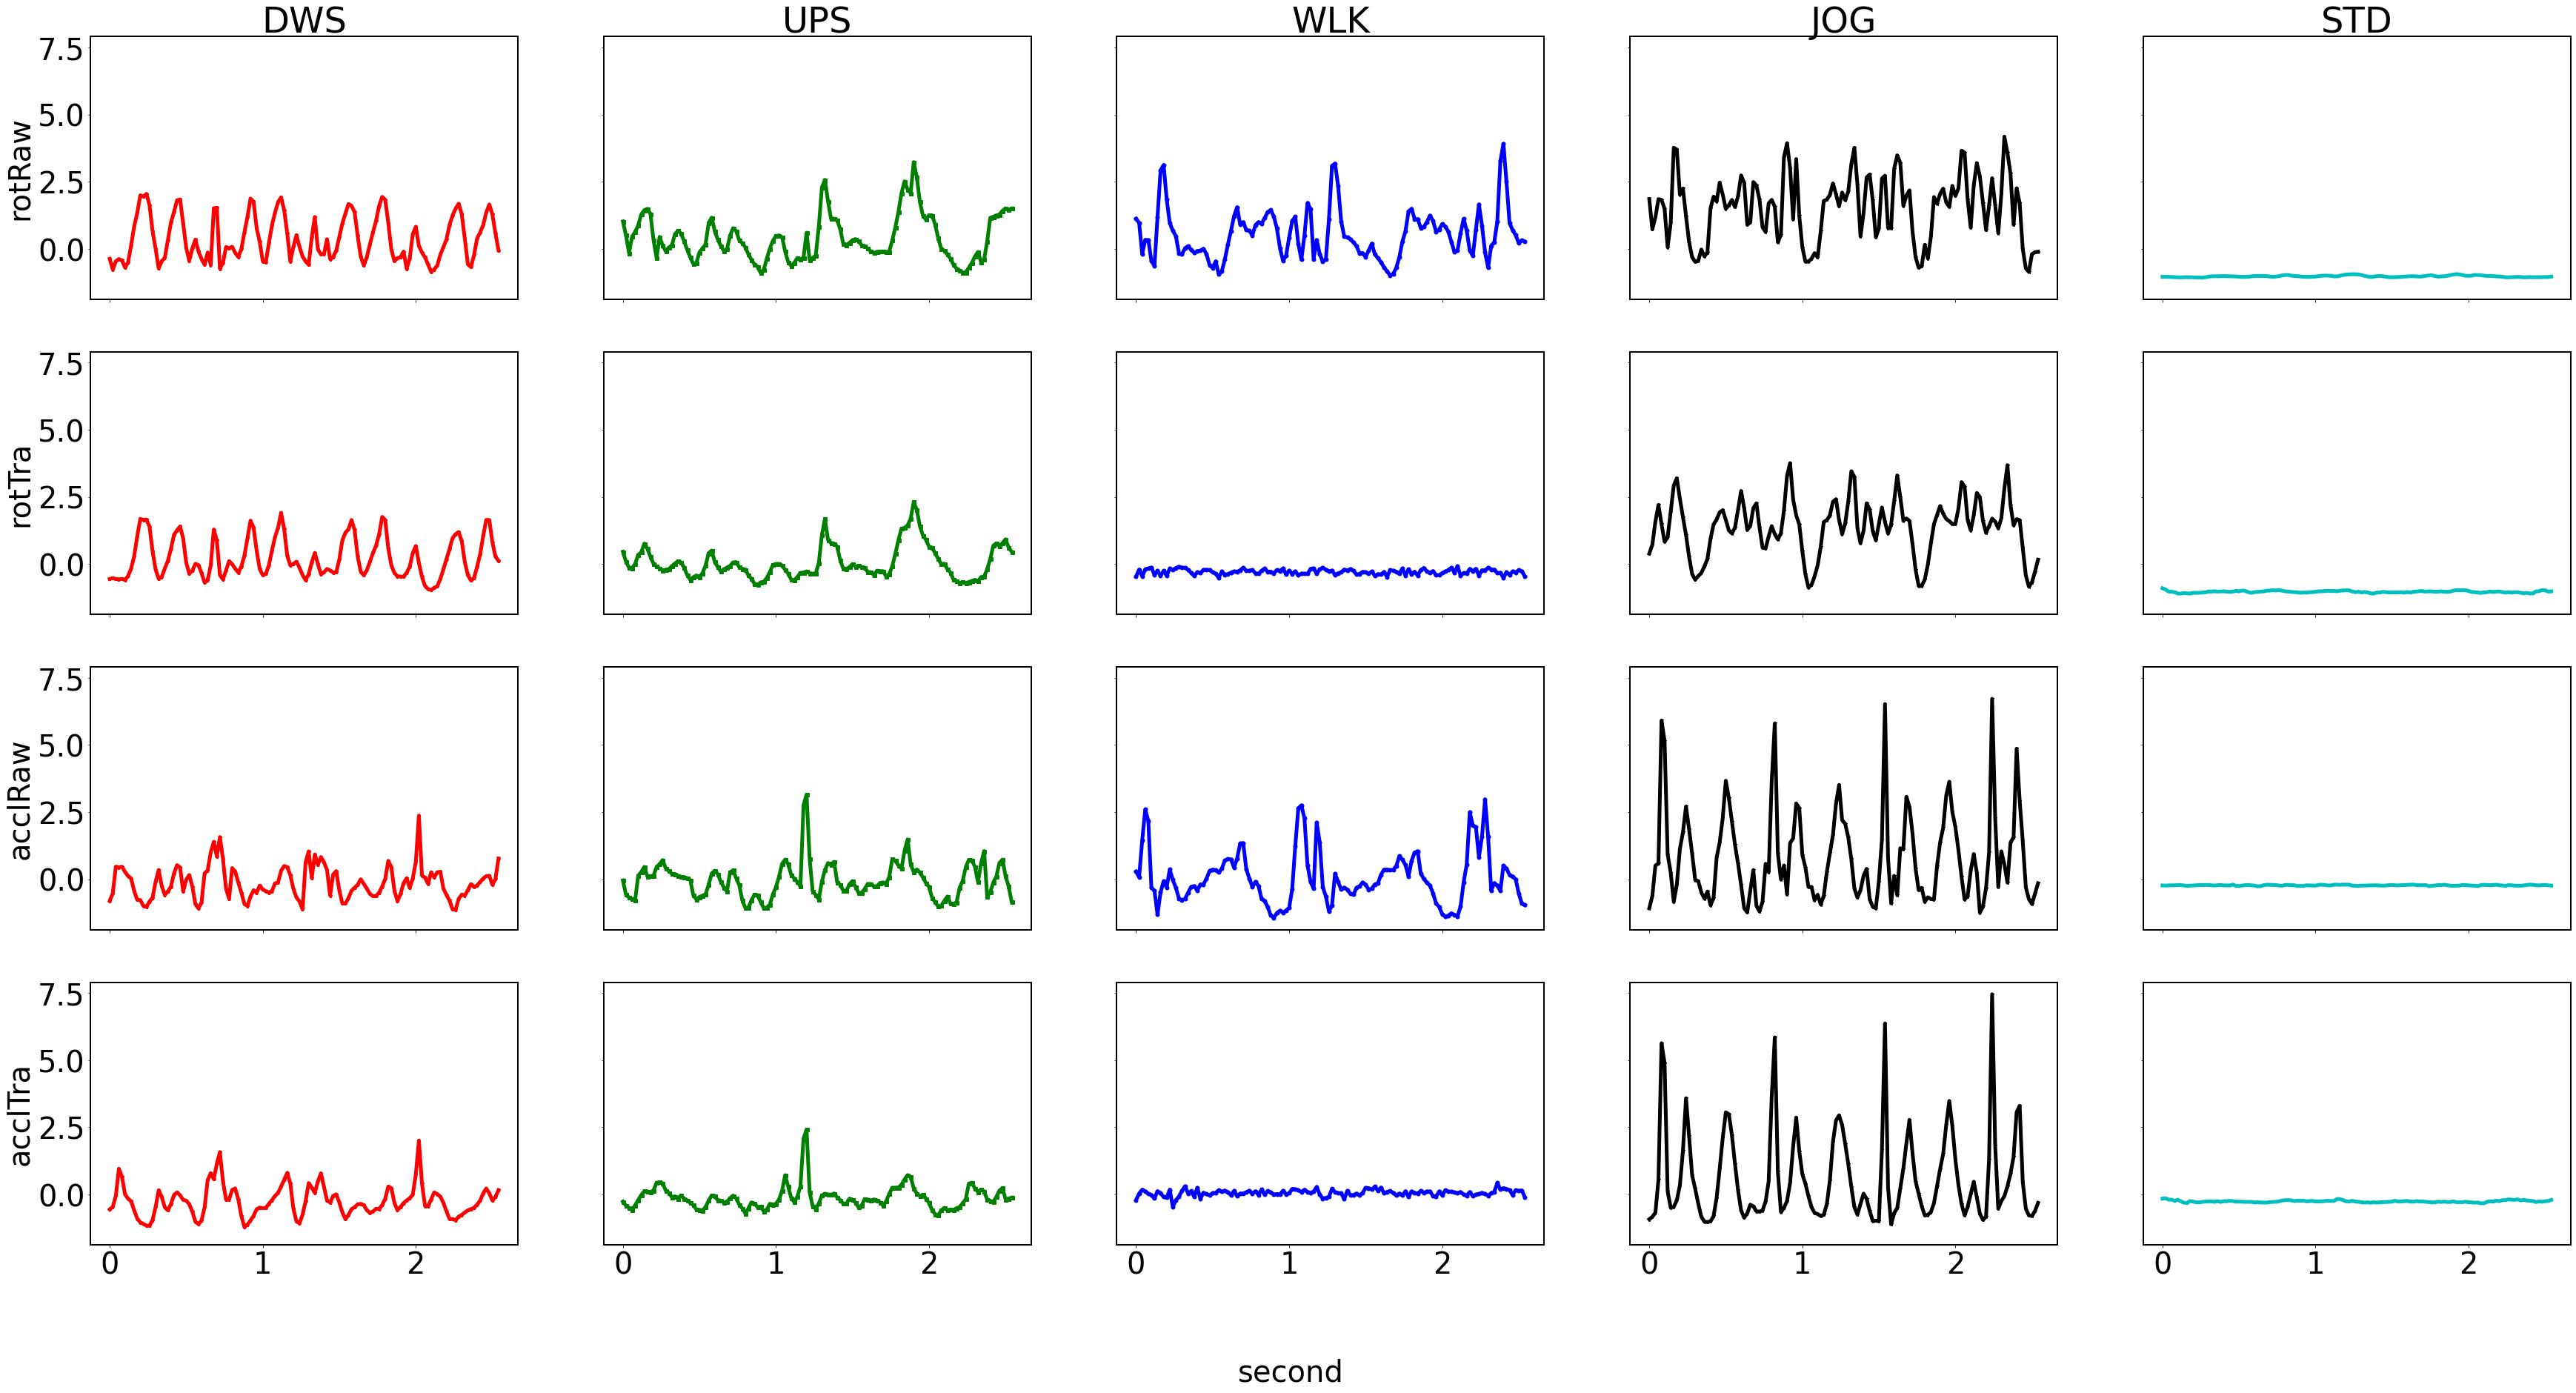

In [74]:
rnd_smpl5= np.random.randint(100)
pts = 128
print("Random Test Sample: #"+str(rnd_smpl5))
plot_signals(rnd_smpl5, pts, test_data, rep_x_test5)

##Replacement New Training scheme #07

In [75]:
w_train_data7 = train_data[np.logical_or.reduce((act_train == 3., act_train == 4.))]
b_train_data7 = train_data[np.logical_or.reduce((act_train == 0.,act_train == 1.))]
g_train_data7 = train_data[act_train == 2.]

print("[INFO] -- Shape of Train Grays :"+str(g_train_data7.shape))
print("[INFO] -- Shape of Train Blacks :"+str(b_train_data7.shape))
print("[INFO] -- Shape of Train Whites :"+str(w_train_data7.shape))

w_test_data7 = test_data[np.logical_or.reduce((act_test == 3., act_test == 4.))]
b_test_data7 = test_data[np.logical_or.reduce((act_test == 0.,act_test == 1.))]
g_test_data7 = test_data[act_test == 2.]

print("[INFO] -- Shape of Test Grays :"+str(g_test_data7.shape))
print("[INFO] -- Shape of Test Blacks :"+str(b_test_data7.shape))
print("[INFO] -- Shape of Test Whites :"+str(w_test_data7.shape))

[INFO] -- Shape of Train Grays :(27290, 2, 128, 1)
[INFO] -- Shape of Train Blacks :(22640, 2, 128, 1)
[INFO] -- Shape of Train Whites :(32305, 2, 128, 1)
[INFO] -- Shape of Test Grays :(6225, 2, 128, 1)
[INFO] -- Shape of Test Blacks :(4442, 2, 128, 1)
[INFO] -- Shape of Test Whites :(10543, 2, 128, 1)


In [79]:
batch_size = 128
num_of_epochs = 100

rnd_idx_train7 = np.random.choice( g_train_data7.shape[0], b_train_data7.shape[0], replace=False)
tmp7 =  g_train_data7[rnd_idx_train7,:]
b_train_transformed7 = tmp7.copy()

x_train7 = np.append(w_train_data7, g_train_data7, axis=0)
x_train7 = np.append(x_train7, b_train_data7, axis=0)

x_train_transformed7 = np.append(w_train_data7, g_train_data7, axis=0)
x_train_transformed7 = np.append(x_train_transformed7 , b_train_transformed7, axis=0)

resh7 = np.prod(w_train_data5.shape[1:])

#### Replacement Autoencoder #######
inp = Input(shape=(w_train_data7.shape[1], w_train_data7.shape[2], 1))
x = Conv2D(64, (1,5), padding="same", kernel_regularizer=regularizers.l2(0.0001), activation="selu")(inp)
x = Conv2D(32, (1,5), padding="same", kernel_regularizer=regularizers.l2(0.0001), activation="selu")(x)
x = Conv2D(1, (1,5), padding="same", kernel_regularizer=regularizers.l2(0.0001), activation="selu")(x)
x = BatchNormalization()(x)
x = Reshape((resh7,))(x)
x = Dense(resh7, activation='selu')(x)
x = BatchNormalization()(x)
x = Dense(resh7//2, kernel_regularizer=regularizers.l2(0.0001), activation='selu')(x)
x = BatchNormalization()(x)
x = Dense(resh7, activation='selu')(x)
x = BatchNormalization()(x)
x = Reshape((w_train_data7.shape[1], w_train_data7.shape[2], 1))(x)
x = Conv2D(32, (1,5), padding="same", kernel_regularizer=regularizers.l2(0.0001), activation="selu")(x)
x = Conv2D(64, (1,5), padding="same", kernel_regularizer=regularizers.l2(0.0001), activation="selu")(x)
out = Conv2D(1, (1,5), padding="same", kernel_regularizer=regularizers.l2(0.0001), activation="linear")(x)

raet7 = Model(inp, out)

print(raet7.summary())

## Callbacks
eval_metric= "val_loss"    
early_stop = keras.callbacks.EarlyStopping(monitor = eval_metric, mode = 'min', patience = 20)
filepath="rae_best7.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor=eval_metric, verbose=0, save_best_only=True, mode='min')
callbacks_list = [early_stop,checkpoint]

raet7.compile(optimizer='adam', loss='mse')

x_train7, x_train_transformed7 = shuffle(x_train7, x_train_transformed7)

raet7.fit(x_train7 , x_train_transformed7,
                validation_split = 0.1,
                epochs = num_of_epochs,
                batch_size = batch_size,
                shuffle = True,
                verbose = 0,
                callbacks = callbacks_list
                )

In [80]:
rae7 = load_model("rae_best7.hdf5")

rep_x_test7 = test_data.copy()
rep_x_test7 = rae7.predict(rep_x_test7, verbose=1)

from keras.models import load_model
eval_act7 = load_model("HAR_Comb.hdf5")
X7 = rep_x_test7
Y7 = act_test_labels
print_results(eval_act7, X7, Y7)

663/663 [==============================] - 2s 3ms/step
663/663 - 2s - loss: 1.2367 - acc: 0.8634 - 2s/epoch - 3ms/step
***[RESULT]*** ACT Accuracy: 86.33999999999999
663/663 [==============================] - 2s 2ms/step
***[RESULT]*** ACT  Confusion Matrix
dws | ups | wlk | jog | std
[[  1.8  98.2   0.1   0.    0. ]
 [  0.  100.    0.    0.    0. ]
 [  4.5   7.6  87.7   0.1   0. ]
 [  0.1   6.3   0.   93.6   0. ]
 [  0.    0.3   0.4   0.   99.4]]
***[RESULT]*** ACT Averaged F-1 Score : 71.70036278627327


Random Test Sample: #55


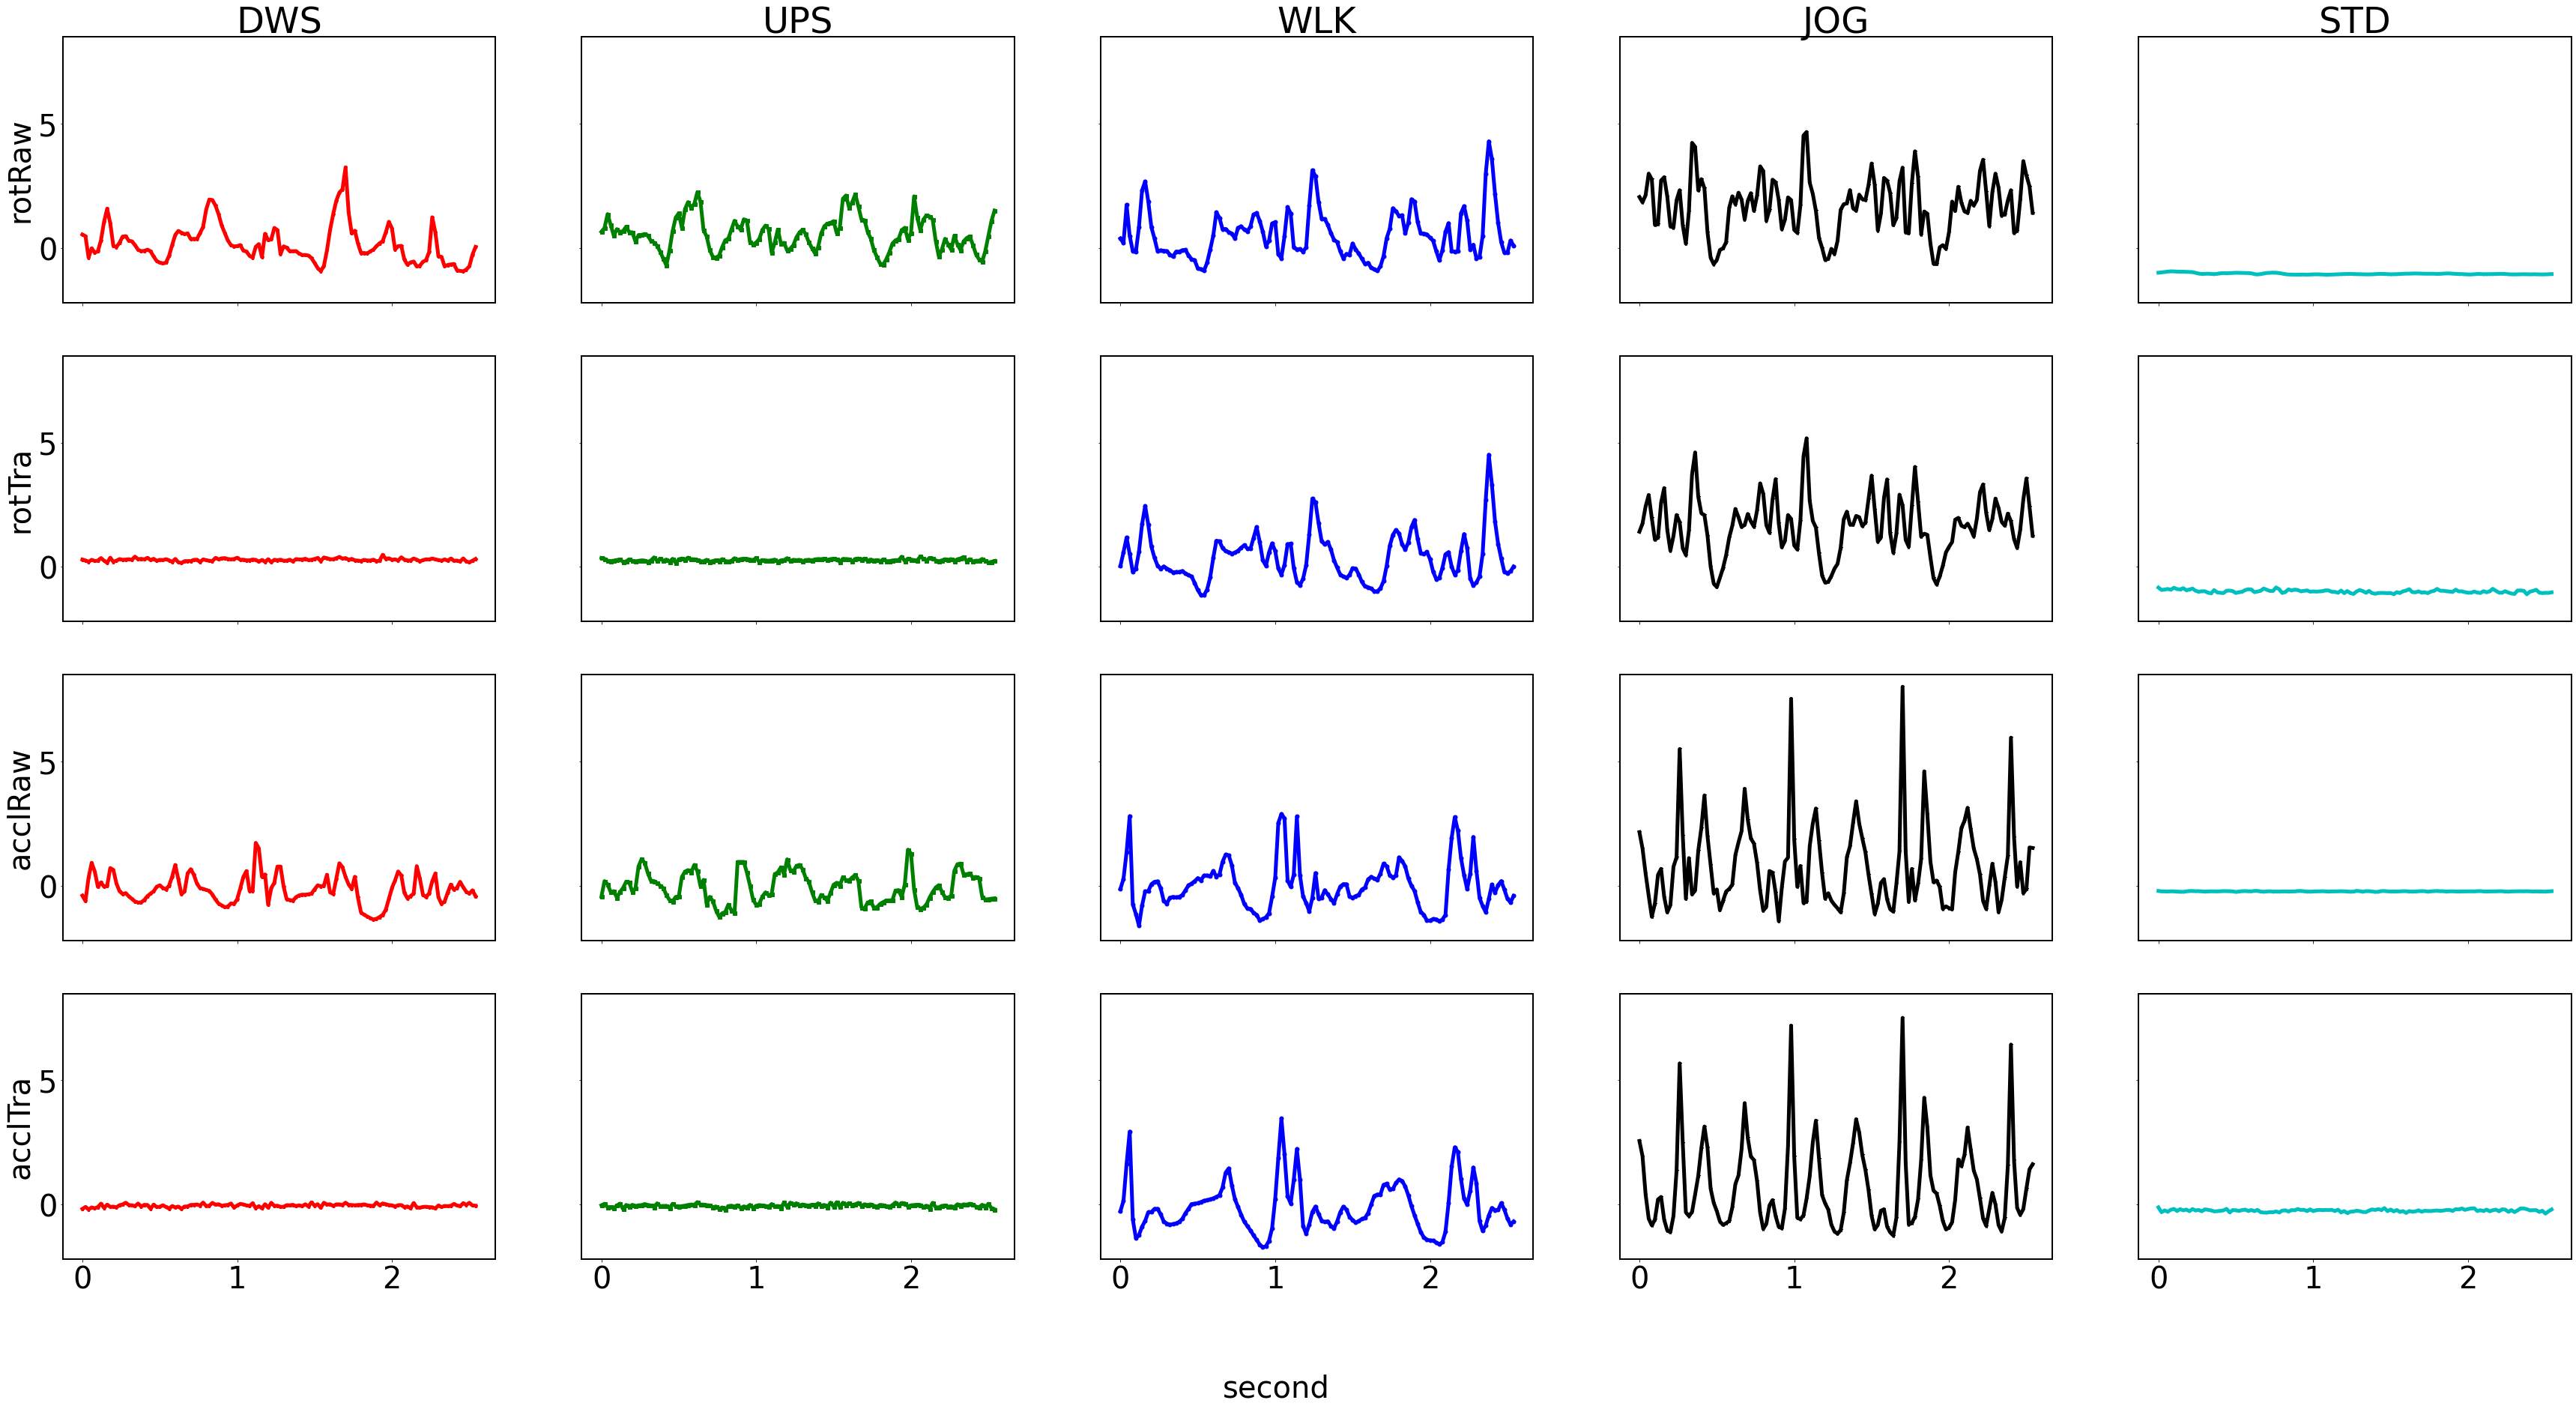

In [81]:
rnd_smpl7= np.random.randint(100)
pts = 128
print("Random Test Sample: #"+str(rnd_smpl7))
plot_signals(rnd_smpl7, pts, test_data, rep_x_test7)

##Replacement New Training scheme #08

In [82]:
w_train_data8 = train_data[np.logical_or.reduce((act_train == 5., act_train == 6.))]
b_train_data8 = train_data[np.logical_or.reduce((act_train == 2.,act_train == 3.))]
g_train_data8 = train_data[np.logical_or.reduce((act_train == 0., act_train == 1., act_train == 4.))]

print("[INFO] -- Shape of Train Grays :"+str(g_train_data8.shape))
print("[INFO] -- Shape of Train Blacks :"+str(b_train_data8.shape))
print("[INFO] -- Shape of Train Whites :"+str(w_train_data8.shape))

w_test_data8 = test_data[np.logical_or.reduce((act_test == 5., act_test == 6.))]
b_test_data8 = test_data[np.logical_or.reduce((act_test == 2.,act_test == 3.))]
g_test_data8 = test_data[np.logical_or.reduce((act_test == 0.,act_test == 1.,act_test == 4.))]

print("[INFO] -- Shape of Test Grays :"+str(g_test_data8.shape))
print("[INFO] -- Shape of Test Blacks :"+str(b_test_data8.shape))
print("[INFO] -- Shape of Test Whites :"+str(w_test_data8.shape))

[INFO] -- Shape of Train Grays :(44816, 2, 128, 1)
[INFO] -- Shape of Train Blacks :(37419, 2, 128, 1)
[INFO] -- Shape of Train Whites :(0, 2, 128, 1)
[INFO] -- Shape of Test Grays :(12299, 2, 128, 1)
[INFO] -- Shape of Test Blacks :(8911, 2, 128, 1)
[INFO] -- Shape of Test Whites :(0, 2, 128, 1)


In [85]:
batch_size = 128
num_of_epochs = 100

rnd_idx_train8 = np.random.choice( g_train_data8.shape[0], b_train_data8.shape[0], replace=False)
tmp8 =  g_train_data8[rnd_idx_train8,:]
b_train_transformed8 = tmp8.copy()

x_train8 = np.append(w_train_data8, g_train_data8, axis=0)
x_train8 = np.append(x_train8, b_train_data8, axis=0)

x_train_transformed8 = np.append(w_train_data8, g_train_data8, axis=0)
x_train_transformed8 = np.append(x_train_transformed8 , b_train_transformed8, axis=0)

resh8 = np.prod(w_train_data8.shape[1:])

#### Replacement Autoencoder #######
inp = Input(shape=(b_train_data8.shape[1], b_train_data8.shape[2], 1))
x = Conv2D(64, (1,5), padding="same", kernel_regularizer=regularizers.l2(0.0001), activation="selu")(inp)
x = Conv2D(32, (1,5), padding="same", kernel_regularizer=regularizers.l2(0.0001), activation="selu")(x)
x = Conv2D(1, (1,5), padding="same", kernel_regularizer=regularizers.l2(0.0001), activation="selu")(x)
x = BatchNormalization()(x)
x = Reshape((resh8,))(x)
x = Dense(resh8, activation='selu')(x)
x = BatchNormalization()(x)
x = Dense(resh8//2, kernel_regularizer=regularizers.l2(0.0001), activation='selu')(x)
x = BatchNormalization()(x)
x = Dense(resh8, activation='selu')(x)
x = BatchNormalization()(x)
x = Reshape((b_train_data8.shape[1], b_train_data8.shape[2], 1))(x)
x = Conv2D(32, (1,5), padding="same", kernel_regularizer=regularizers.l2(0.0001), activation="selu")(x)
x = Conv2D(64, (1,5), padding="same", kernel_regularizer=regularizers.l2(0.0001), activation="selu")(x)
out = Conv2D(1, (1,5), padding="same", kernel_regularizer=regularizers.l2(0.0001), activation="linear")(x)

raet8 = Model(inp, out)

print(raet8.summary())

## Callbacks
eval_metric= "val_loss"    
early_stop = keras.callbacks.EarlyStopping(monitor = eval_metric, mode = 'min', patience = 20)
filepath="rae_best8.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor=eval_metric, verbose=0, save_best_only=True, mode='min')
callbacks_list = [early_stop,checkpoint]

raet8.compile(optimizer='adam', loss='mse')

x_train8, x_train_transformed8 = shuffle(x_train8, x_train_transformed8)

raet8.fit(x_train8 , x_train_transformed8,
                validation_split = 0.1,
                epochs = num_of_epochs,
                batch_size = batch_size,
                shuffle = True,
                verbose = 0,
                callbacks = callbacks_list
                )

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 2, 128, 1)]       0         
                                                                 
 conv2d_99 (Conv2D)          (None, 2, 128, 64)        384       
                                                                 
 conv2d_100 (Conv2D)         (None, 2, 128, 32)        10272     
                                                                 
 conv2d_101 (Conv2D)         (None, 2, 128, 1)         161       
                                                                 
 batch_normalization_69 (Bat  (None, 2, 128, 1)        4         
 chNormalization)                                                
                                                                 
 reshape_20 (Reshape)        (None, 256)               0         
                                                          

In [88]:
rae8 = load_model("rae_best8.hdf5")

rep_x_test8 = test_data.copy()
rep_x_test8 = rae8.predict(rep_x_test8, verbose=1)

from keras.models import load_model
eval_act8 = load_model("HAR_Comb.hdf5")
X8 = rep_x_test8
Y8 = act_test_labels
print_results(eval_act8, X8, Y8)

663/663 [==============================] - 3s 3ms/step
663/663 - 2s - loss: 1.5385 - acc: 0.7605 - 2s/epoch - 3ms/step
***[RESULT]*** ACT Accuracy: 76.05
663/663 [==============================] - 2s 2ms/step
***[RESULT]*** ACT  Confusion Matrix
dws | ups | wlk | jog | std
[[73.2 26.   0.8  0.   0. ]
 [ 0.1 98.8  1.   0.   0.1]
 [ 0.5  3.9 70.5  0.  25.1]
 [ 0.6 13.3 47.7  0.  38.4]
 [ 0.   0.   0.1  0.  99.9]]
***[RESULT]*** ACT Averaged F-1 Score : 64.80581415557748


Random Test Sample: #38


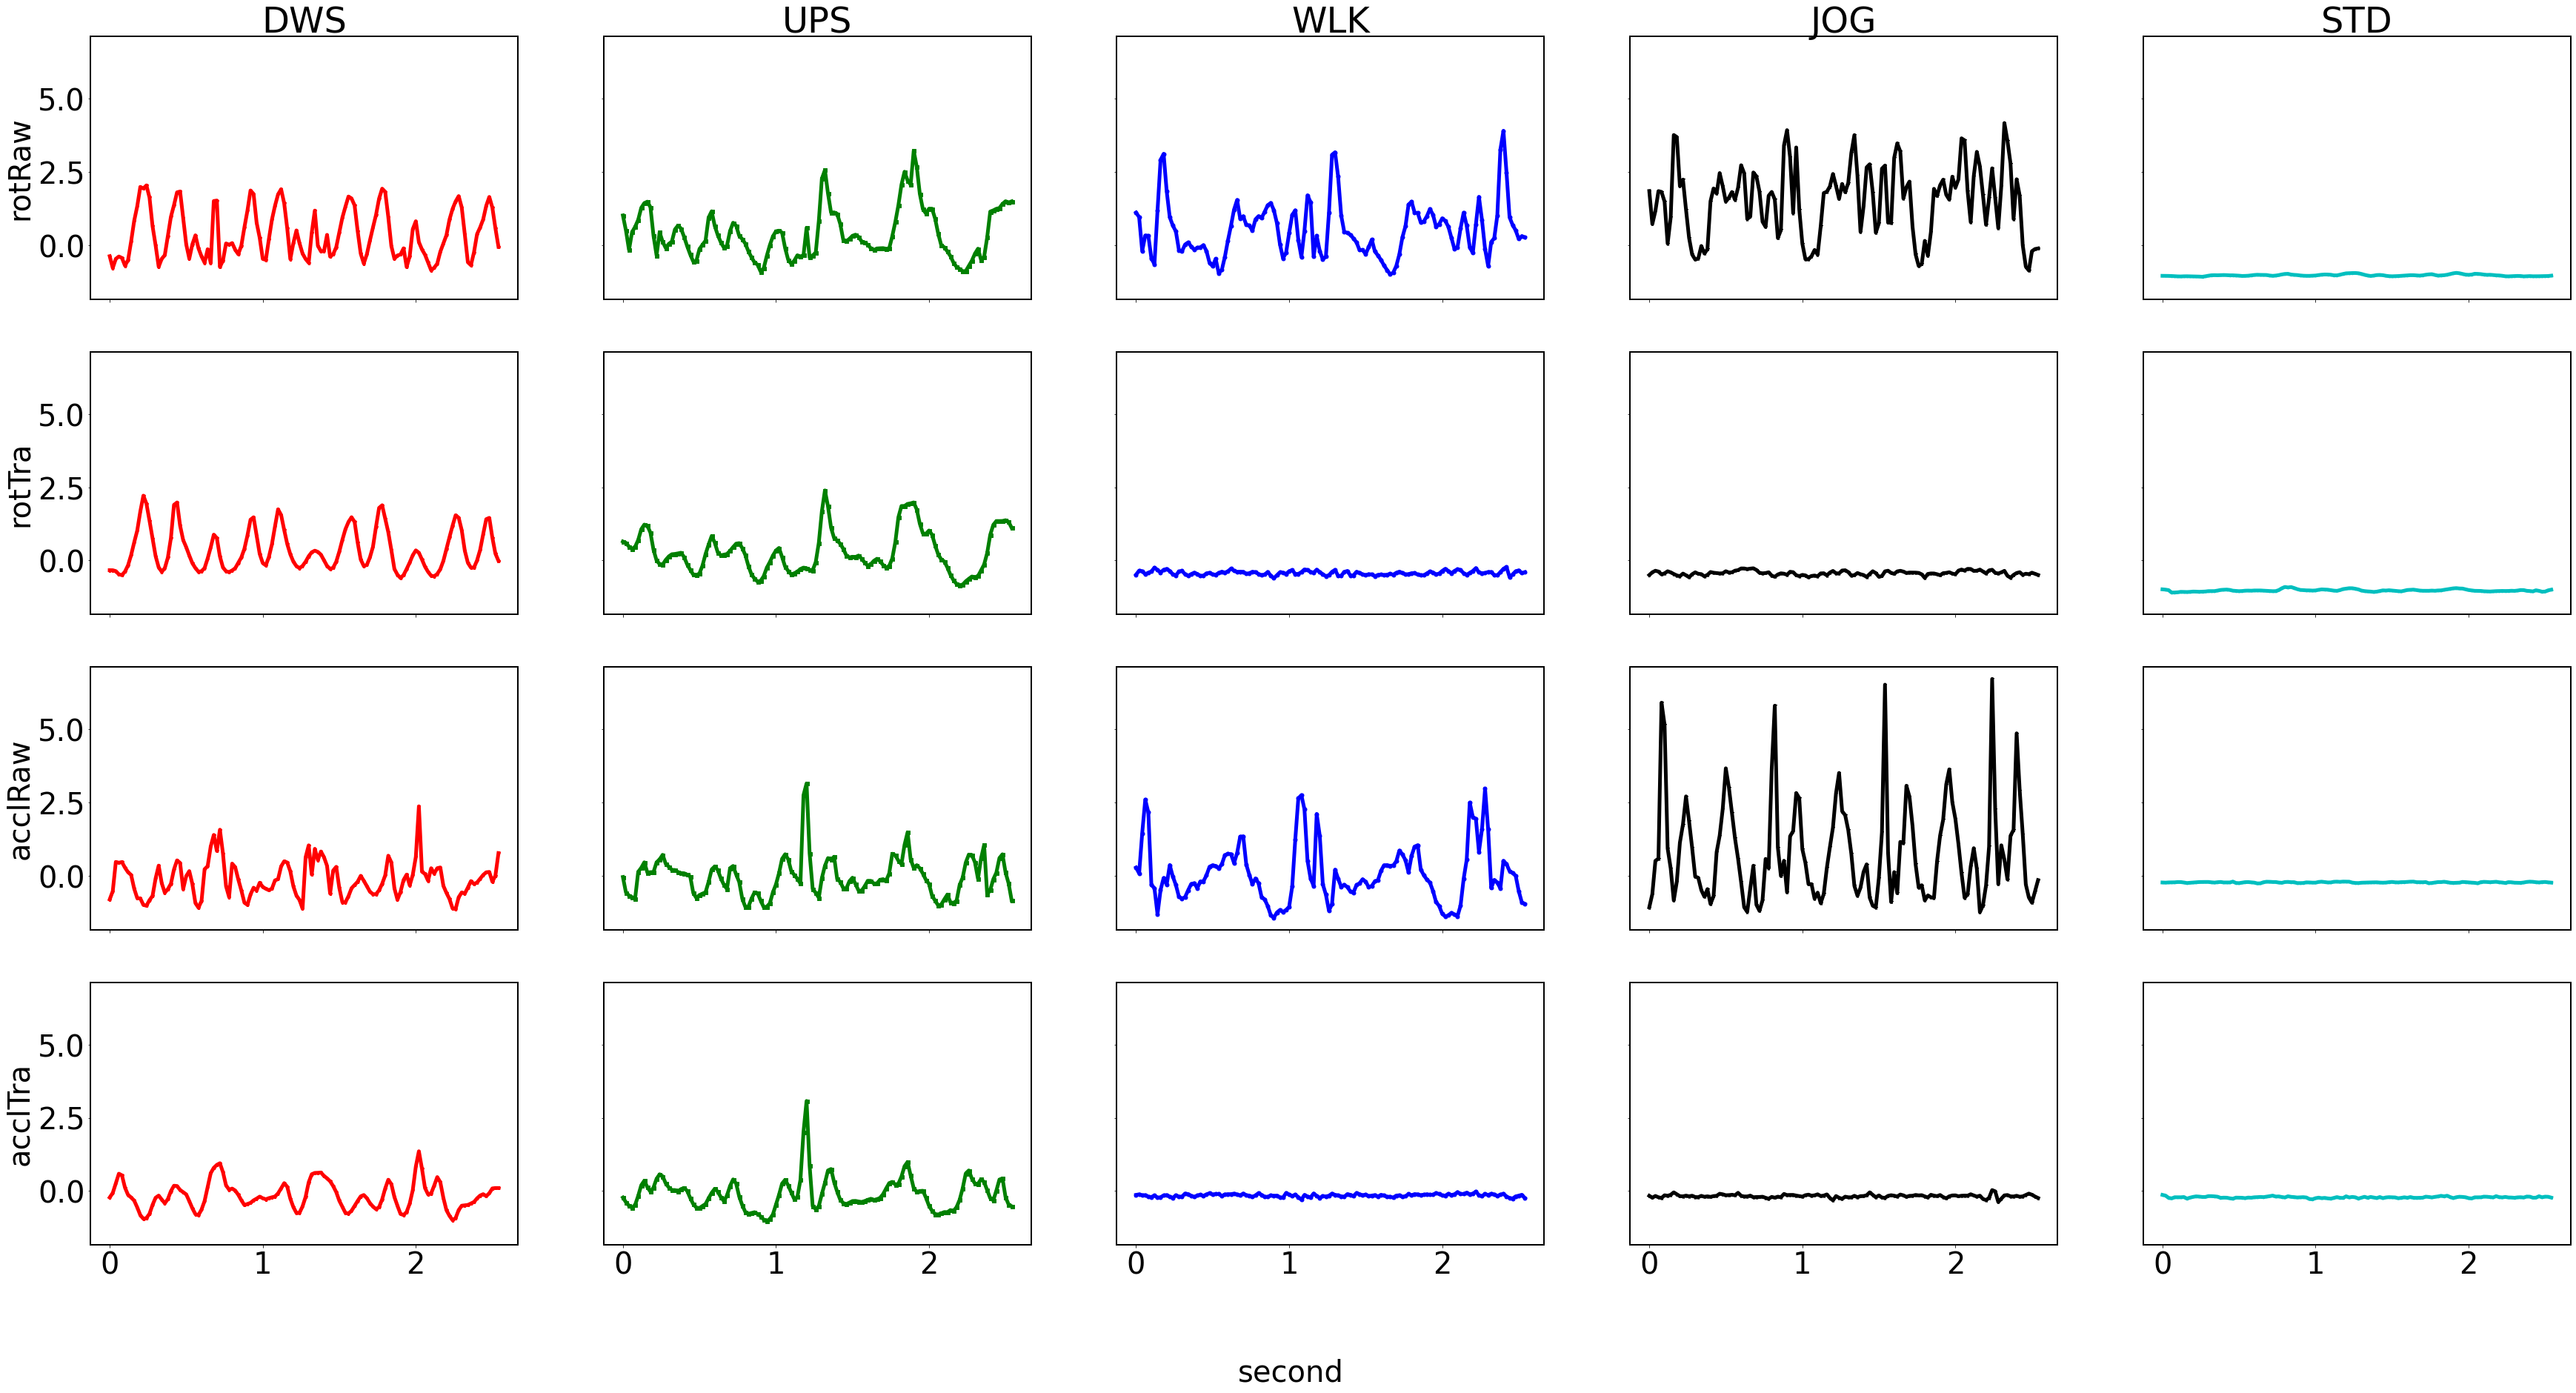

In [87]:
rnd_smpl8= np.random.randint(100)
pts = 128
print("Random Test Sample: #"+str(rnd_smpl8))
plot_signals(rnd_smpl8, pts, test_data, rep_x_test8)

##Replacement New Training scheme #09

In [89]:
w_train_data9 = train_data[np.logical_or.reduce((act_train == 5., act_train == 6.))]
b_train_data9 = train_data[np.logical_or.reduce((act_train == 2.,act_train == 3.))]
g_train_data9 = train_data[np.logical_or.reduce((act_train == 0., act_train == 1., act_train == 4.))]

print("[INFO] -- Shape of Train Grays :"+str(g_train_data9.shape))
print("[INFO] -- Shape of Train Blacks :"+str(b_train_data9.shape))
print("[INFO] -- Shape of Train Whites :"+str(w_train_data9.shape))

w_test_data9 = test_data[np.logical_or.reduce((act_test == 5., act_test == 6.))]
b_test_data9 = test_data[np.logical_or.reduce((act_test == 2.,act_test == 3.))]
g_test_data9 = test_data[np.logical_or.reduce((act_test == 0.,act_test == 1.,act_test == 4.))]

print("[INFO] -- Shape of Test Grays :"+str(g_test_data9.shape))
print("[INFO] -- Shape of Test Blacks :"+str(b_test_data9.shape))
print("[INFO] -- Shape of Test Whites :"+str(w_test_data9.shape))

[INFO] -- Shape of Train Grays :(44816, 2, 128, 1)
[INFO] -- Shape of Train Blacks :(37419, 2, 128, 1)
[INFO] -- Shape of Train Whites :(0, 2, 128, 1)
[INFO] -- Shape of Test Grays :(12299, 2, 128, 1)
[INFO] -- Shape of Test Blacks :(8911, 2, 128, 1)
[INFO] -- Shape of Test Whites :(0, 2, 128, 1)


In [106]:
print(act_train == 2.)
print(np.logical_or.reduce((act_train == 4.)))
print(np.logical_or.reduce((act_train == 3.)))
print(tmp_g_train_data9.shape[0])
print( tmp_b_train_data9.shape[0])

[False False False ... False False False]
True
True
1
1


In [126]:
batch_size = 128
num_of_epochs = 100

tmp_g_train_data9 = train_data[act_train == 4.]

tmp_b_train_data9 = train_data[act_train == 3.]

rnd_idx_train9 = np.random.choice( tmp_g_train_data9.shape[0], tmp_b_train_data9.shape[0], replace=False)

tmp9 =  tmp_g_train_data9[rnd_idx_train9,:]

tmp_g_train_data9 = train_data[np.logical_or.reduce((act_train == 0., act_train == 1.))]
tmp_b_train_data9 = train_data[act_train == 2.]


rnd_idx_train9 = np.random.choice( tmp_g_train_data9.shape[0], tmp_b_train_data9.shape[0], replace=True)

tmp9b =  tmp_g_train_data9[rnd_idx_train9,:]



b_train_transformed9 = np.append(tmp9, tmp9b, axis=0)

x_train9 = np.append(w_train_data9, g_train_data9, axis=0)
x_train9 = np.append(x_train9, b_train_data9, axis=0)

x_train_transformed9 = np.append(w_train_data9, g_train_data9, axis=0)
x_train_transformed9 = np.append(x_train_transformed9 , b_train_transformed9, axis=0)

resh9 = np.prod(w_train_data9.shape[1:])

#### Replacement Autoencoder #######
inp = Input(shape=(b_train_data9.shape[1], b_train_data9.shape[2], 1))
x = Conv2D(64, (1,5), padding="same", kernel_regularizer=regularizers.l2(0.0001), activation="selu")(inp)
x = Conv2D(32, (1,5), padding="same", kernel_regularizer=regularizers.l2(0.0001), activation="selu")(x)
x = Conv2D(1, (1,5), padding="same", kernel_regularizer=regularizers.l2(0.0001), activation="selu")(x)
x = BatchNormalization()(x)
x = Reshape((resh9,))(x)
x = Dense(resh9, activation='selu')(x)
x = BatchNormalization()(x)
x = Dense(resh9//2, kernel_regularizer=regularizers.l2(0.0001), activation='selu')(x)
x = BatchNormalization()(x)
x = Dense(resh9, activation='selu')(x)
x = BatchNormalization()(x)
x = Reshape((b_train_data9.shape[1], b_train_data9.shape[2], 1))(x)
x = Conv2D(32, (1,5), padding="same", kernel_regularizer=regularizers.l2(0.0001), activation="selu")(x)
x = Conv2D(64, (1,5), padding="same", kernel_regularizer=regularizers.l2(0.0001), activation="selu")(x)
out = Conv2D(1, (1,5), padding="same", kernel_regularizer=regularizers.l2(0.0001), activation="linear")(x)

raet9 = Model(inp, out)

print(raet9.summary())

## Callbacks
eval_metric= "val_loss"    
early_stop = keras.callbacks.EarlyStopping(monitor = eval_metric, mode = 'min', patience = 20)
filepath="rae_best9.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor=eval_metric, verbose=0, save_best_only=True, mode='min')
callbacks_list = [early_stop,checkpoint]

raet9.compile(optimizer='adam', loss='mse')

x_train9, x_train_transformed9 = shuffle(x_train9, x_train_transformed9)

raet9.fit(x_train9 , x_train_transformed9,
                validation_split = 0.1,
                epochs = num_of_epochs,
                batch_size = batch_size,
                shuffle = True,
                verbose = 0,
                callbacks = callbacks_list
                )

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 2, 128, 1)]       0         
                                                                 
 conv2d_111 (Conv2D)         (None, 2, 128, 64)        384       
                                                                 
 conv2d_112 (Conv2D)         (None, 2, 128, 32)        10272     
                                                                 
 conv2d_113 (Conv2D)         (None, 2, 128, 1)         161       
                                                                 
 batch_normalization_77 (Bat  (None, 2, 128, 1)        4         
 chNormalization)                                                
                                                                 
 reshape_24 (Reshape)        (None, 256)               0         
                                                          

In [127]:
rae9 = load_model("rae_best9.hdf5")

rep_x_test9 = test_data.copy()
rep_x_test9 = rae9.predict(rep_x_test9, verbose=1)

from keras.models import load_model
eval_act9 = load_model("HAR_Comb.hdf5")
X9 = rep_x_test9
Y9 = act_test_labels
print_results(eval_act9, X9, Y9)

663/663 [==============================] - 7s 10ms/step
663/663 - 3s - loss: 4.8113 - acc: 0.5693 - 3s/epoch - 4ms/step
***[RESULT]*** ACT Accuracy: 56.93
663/663 [==============================] - 9s 13ms/step
***[RESULT]*** ACT  Confusion Matrix
dws | ups | wlk | jog | std
[[75.2 24.5  0.1  0.   0.2]
 [ 0.2 99.5  0.1  0.   0.1]
 [ 0.1 61.1  4.6  0.  34.2]
 [ 0.5 66.6  7.4  0.2 25.2]
 [ 0.   0.   0.3  0.  99.7]]
***[RESULT]*** ACT Averaged F-1 Score : 44.761109858617246


Random Test Sample: #4


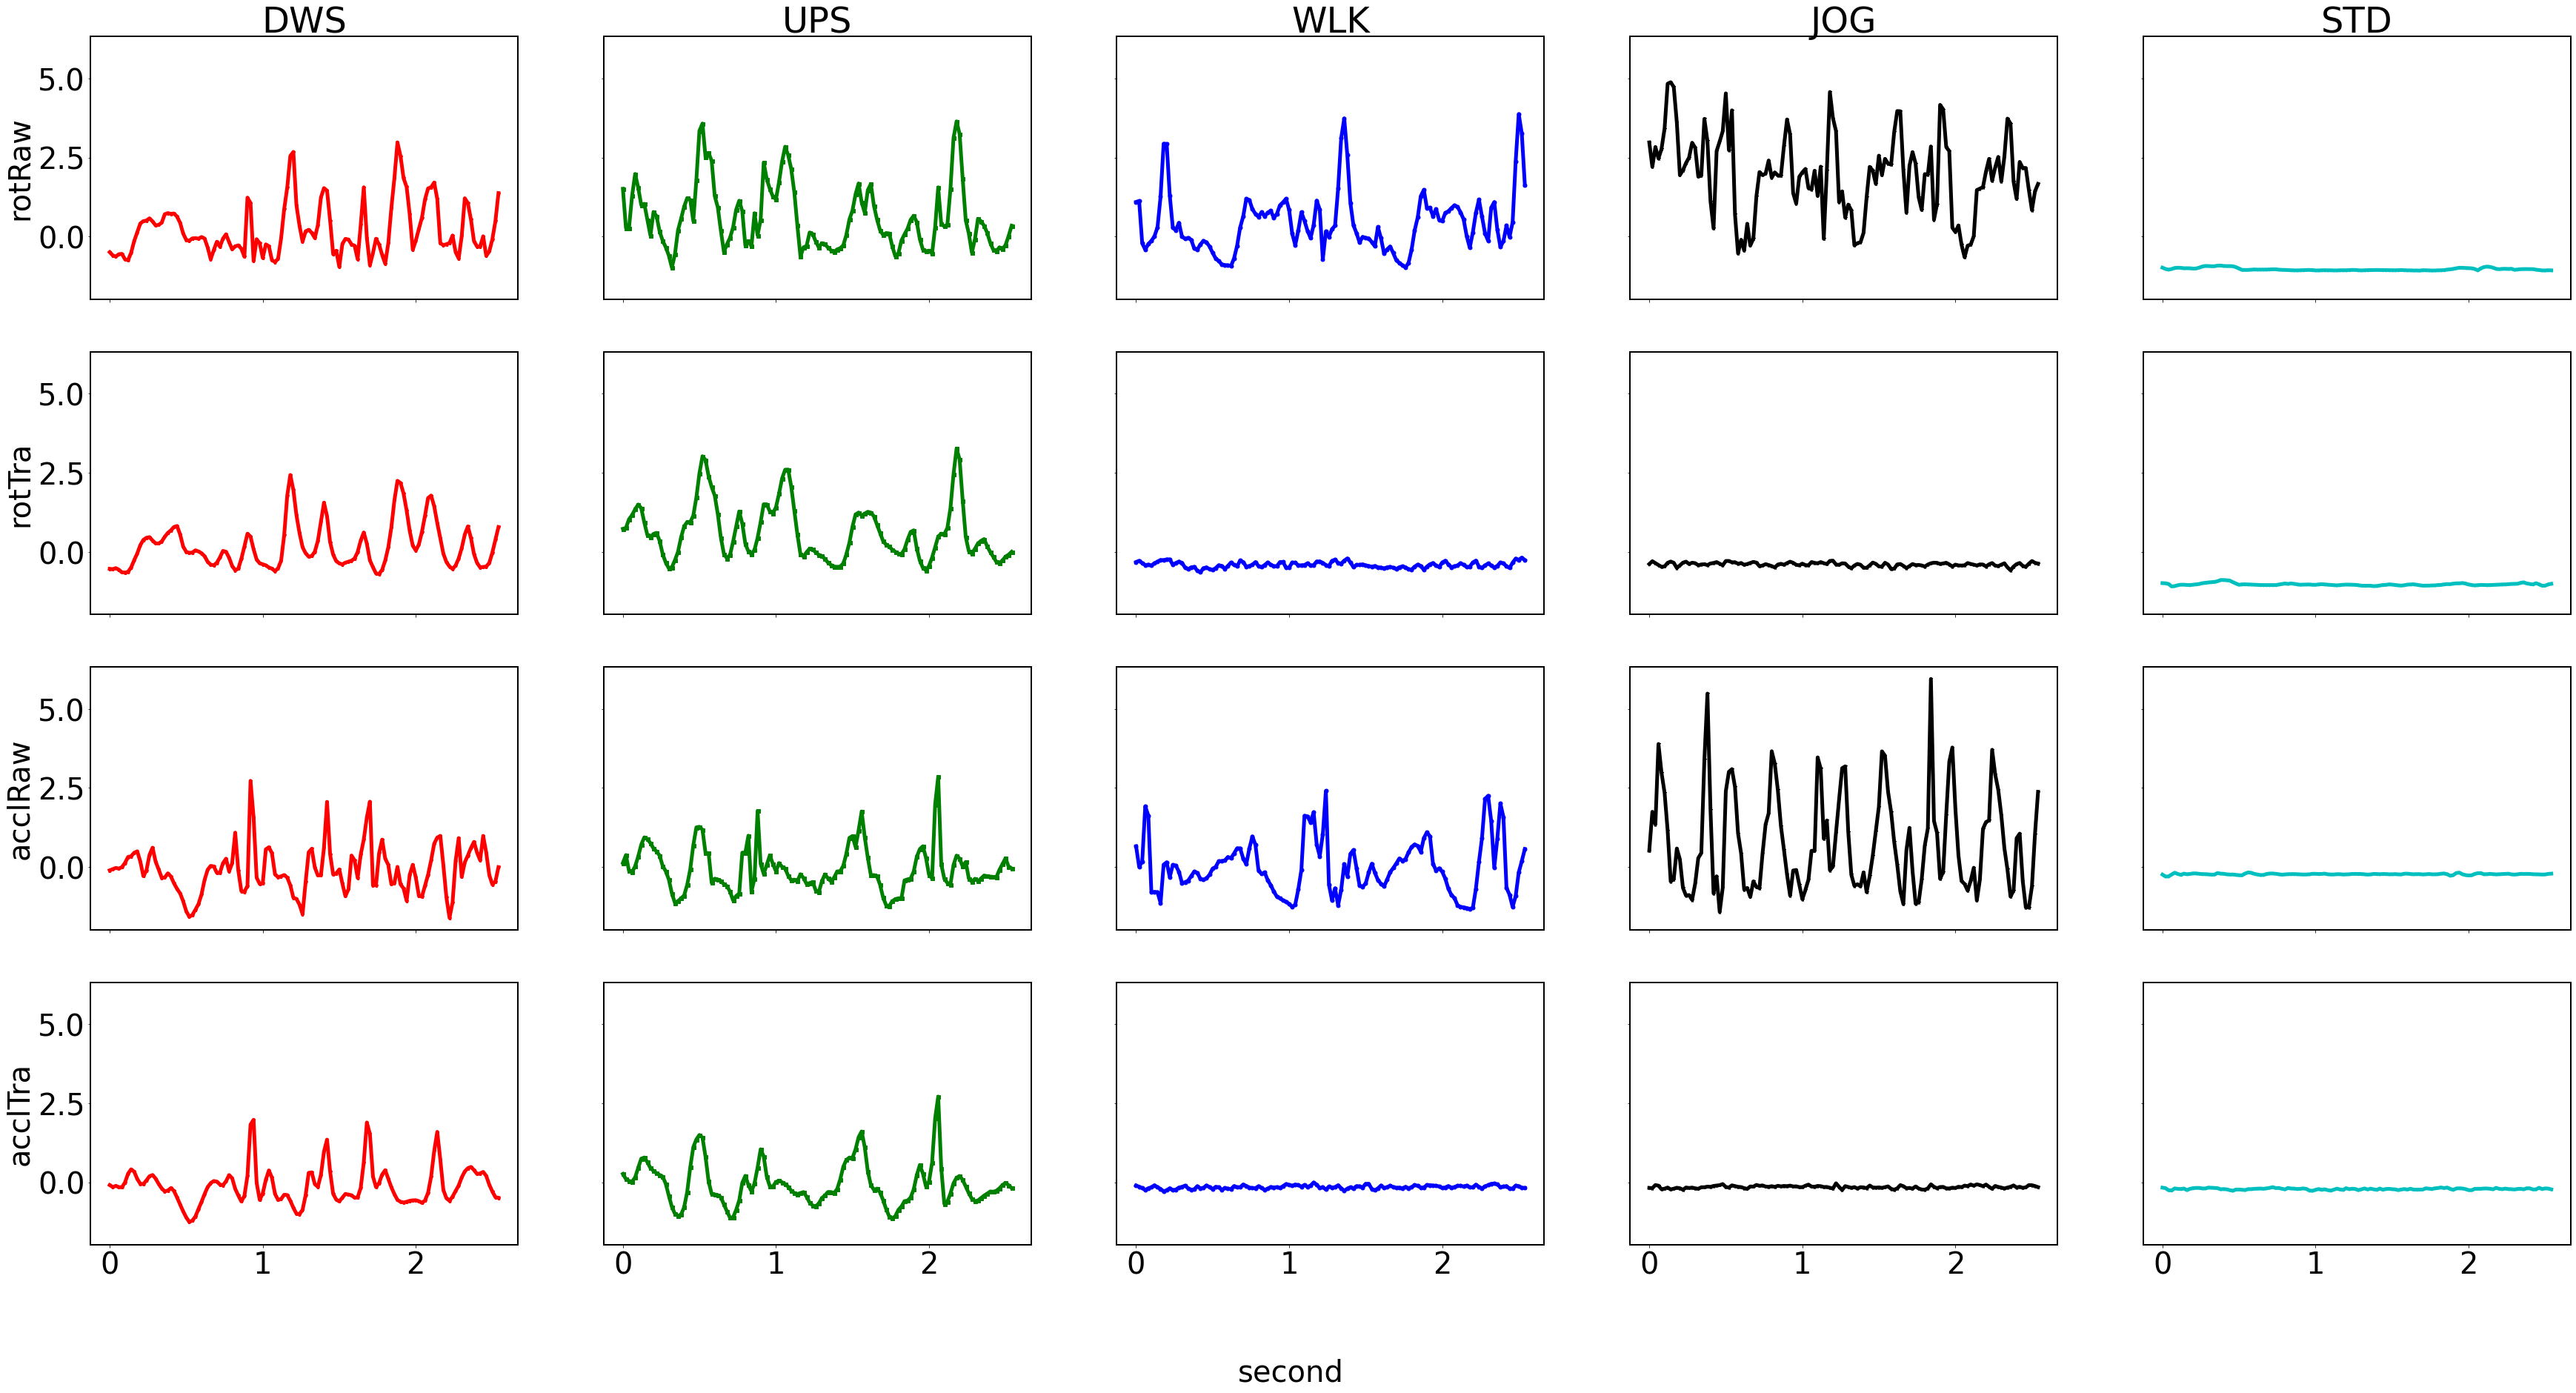

In [128]:
rnd_smpl8= np.random.randint(100)
pts = 128
print("Random Test Sample: #"+str(rnd_smpl8))
plot_signals(rnd_smpl8, pts, test_data, rep_x_test8)

# ANONYMIZATION

In [42]:
data_subject_info = pd.read_csv("data_subjects_info.csv")
id_gen_info = data_subject_info[["code","gender"]].values
gen_id_dic = {item[0]:item[1] for item in id_gen_info}

tmp = id_train.copy()
gen_train = np.array([gen_id_dic[item+1] for item in tmp])
gen_train_labels = (gen_train).copy()

tmp = id_test.copy()
gen_test = np.array([gen_id_dic[item+1] for item in tmp])
gen_test_labels = (gen_test).copy()

[gen_train_labels.shape, gen_test_labels.shape]

[(82235,), (21210,)]

In [43]:
w_train_data = train_data[np.logical_or.reduce((act_train == 0., act_train == 1., act_train == 2.))]
w_act_train_labels = act_train_labels[np.logical_or.reduce((act_train == 0., act_train == 1., act_train == 2.))]
w_gen_train_labels = gen_train_labels[np.logical_or.reduce((act_train == 0., act_train == 1., act_train == 2.))]

w_test_data = test_data[np.logical_or.reduce((act_test == 0., act_test == 1., act_test == 2.))]
w_act_test_labels = act_test_labels[np.logical_or.reduce((act_test == 0., act_test == 1., act_test == 2.))]
w_gen_test_labels = gen_test_labels[np.logical_or.reduce((act_test == 0., act_test == 1., act_test == 2.))]

In [44]:
def eval_gen(X,Y, gen_class_numbers = 1, fm = (2,5), ep=100):
    height = X.shape[1]
    width = X.shape[2]
    ## Callbacks
    eval_metric= "val_acc"    
    early_stop = keras.callbacks.EarlyStopping(monitor = eval_metric, mode = 'max', patience = 15)
    filepath="GR.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor=eval_metric, verbose=2, save_best_only=True, mode='max')
    callbacks_list = [early_stop,checkpoint]
    
    eval_gen = Estimator.build(height, width, gen_class_numbers, name ="EVAL_GEN", fm=fm, act_func="sigmoid",hid_act_func="relu")
    eval_gen.compile( loss="binary_crossentropy", optimizer='adam', metrics=['acc'])
#     X , Y = shuffle(X,Y)
#     eval_gen.fit(X, Y,
#                 validation_split = .2,
#                 epochs = ep,
#                 batch_size = 128,
#                 verbose = 0,
#                 class_weight = get_class_weights(Y),
#                 callbacks = callbacks_list
#                )

    eval_gen.load_weights("GR.hdf5")
    eval_gen.compile( loss="binary_crossentropy", optimizer='adam', metrics=['acc'])

    result1 = eval_gen.evaluate(X, Y, verbose = 2)
    act_acc = round(result1[1],4)*100
    print("***[RESULT]***GEN Accuracy: "+str(act_acc))

In [45]:
print("Training:")
eval_gen(w_train_data, w_gen_train_labels)

Training:
1561/1561 - 5s - loss: 0.1005 - acc: 0.9951 - 5s/epoch - 3ms/step
***[RESULT]***GEN Accuracy: 99.51


In [46]:
print("Inferecne:")
eval_gen = load_model("GR.hdf5")
result1 = eval_gen.evaluate(w_test_data, w_gen_test_labels, verbose = 1)
act_acc = round(result1[1],4)*100
print("***[RESULT]***Original: GEN Test Accuracy: "+str(act_acc))

Inferecne:
334/334 [==============================] - 1s 4ms/step - loss: 0.1405 - acc: 0.9830
***[RESULT]***Original: GEN Test Accuracy: 98.3


In [47]:
w_data_train_rep = w_train_data.copy()
w_data_train_rep = rae.predict(w_data_train_rep, verbose=1)
w_data_test_rep = w_test_data.copy()
w_data_test_rep = rae.predict(w_data_test_rep, verbose=1)

334/334 [==============================] - 1s 3ms/step


In [48]:
print("Inferecne:")
eval_gen = load_model("GR.hdf5")
result1 = eval_gen.evaluate(w_data_test_rep, w_gen_test_labels, verbose = 2)
act_acc = round(result1[1],4)*100
print("***[RESULT]***Replaced: GEN Test Accuracy: "+str(act_acc))

Inferecne:
334/334 - 1s - loss: 0.1770 - acc: 0.9714 - 1s/epoch - 4ms/step
***[RESULT]***Replaced: GEN Test Accuracy: 97.14


In [49]:
class Enc_Reg:
    l2p = 0.001
    @staticmethod
    def early_layers(inp, fm, hid_act_func="relu"):
        # Start
        x = Conv2D(32, fm, padding="same", kernel_regularizer=regularizers.l2(Enc_Reg.l2p), activation=hid_act_func)(inp)
        x = MaxPooling2D(pool_size=(1, 2))(x)
        x = Dropout(0.25)(x)
        
        # 1
        x = Conv2D(32, fm, padding="same", kernel_regularizer=regularizers.l2(Enc_Reg.l2p), activation=hid_act_func)(x)
        x = MaxPooling2D(pool_size=(1, 2))(x)
        x = Dropout(0.25)(x)

        return x
    
    @staticmethod
    def late_layers(inp, num_classes, fm, act_func="softmax", hid_act_func="relu"):
        # 2
        x = Conv2D(32, fm, padding="same", kernel_regularizer=regularizers.l2(Enc_Reg.l2p), activation=hid_act_func)(inp)
        x = MaxPooling2D(pool_size=(1, 2))(x)
        x = Dropout(0.25)(x)
        
        # End
        x = Flatten()(x)
        x = Dense(64, kernel_regularizer=regularizers.l2(Enc_Reg.l2p), activation=hid_act_func)(x)
        x = Dropout(0.5)(x)
        x = Dense(16, kernel_regularizer=regularizers.l2(Enc_Reg.l2p), activation=hid_act_func)(x)
        x = Dropout(0.5)(x)
        x = Dense(num_classes, activation=act_func)(x)

        return x
   
    @staticmethod
    def build(height, width, num_classes, name, fm, act_func="softmax",hid_act_func="relu"):
        inp = Input(shape=(height, width, 1))
        early = Enc_Reg.early_layers(inp, fm, hid_act_func=hid_act_func)
        late  = Enc_Reg.late_layers(early, num_classes, fm, act_func=act_func, hid_act_func=hid_act_func)
        model = Model(inputs=inp, outputs=late ,name=name)
        return model


class Dec_Reg:
    l2p = 0.001
    @staticmethod
    def early_layers(inp, fm, hid_act_func="relu"):
        # Start
        x = Conv2D(32, fm, padding="same", kernel_regularizer=regularizers.l2(Dec_Reg.l2p), activation=hid_act_func)(inp)
        x = MaxPooling2D(pool_size=(1, 2))(x)
        x = Dropout(0.25)(x)
        
        # 1
        x = Conv2D(32, fm, padding="same", kernel_regularizer=regularizers.l2(Dec_Reg.l2p), activation=hid_act_func)(x)
        x = MaxPooling2D(pool_size=(1, 2))(x)
        x = Dropout(0.25)(x)


        return x
    
    @staticmethod
    def late_layers(inp, num_classes, fm = (1,3), act_func="softmax", hid_act_func="relu"):
        # 2
        x = Conv2D(32, fm, padding="same", kernel_regularizer=regularizers.l2(Dec_Reg.l2p), activation=hid_act_func)(inp)
        x = MaxPooling2D(pool_size=(1, 2))(x)
        x = Dropout(0.25)(x)
        
        # 3
        x = Conv2D(32, fm, padding="same", kernel_regularizer=regularizers.l2(Dec_Reg.l2p), activation=hid_act_func)(x)
        x = MaxPooling2D(pool_size=(1, 2))(x)
        x = Dropout(0.25)(x)
        
        #4
        x = Conv2D(32, fm, padding="same", kernel_regularizer=regularizers.l2(Dec_Reg.l2p), activation=hid_act_func)(x)
        x = MaxPooling2D(pool_size=(1, 2))(x)
        x = Dropout(0.25)(x)
        
        
        # End
        x = Flatten()(x)
        x = Dense(128, kernel_regularizer=regularizers.l2(Dec_Reg.l2p), activation=hid_act_func)(x)
        x = Dropout(0.5)(x)
        x = Dense(32, kernel_regularizer=regularizers.l2(Dec_Reg.l2p), activation=hid_act_func)(x)
        x = Dropout(0.5)(x)
        x = Dense(num_classes, activation=act_func)(x)

        return x
   
    @staticmethod
    def build(height, width, num_classes, name, fm, act_func="softmax",hid_act_func="relu"):
        inp = Input(shape=(height, width, 1))
        early = Dec_Reg.early_layers(inp, fm, hid_act_func=hid_act_func)
        late  = Dec_Reg.late_layers(early, num_classes, fm, act_func=act_func, hid_act_func=hid_act_func)
        model = Model(inputs=inp, outputs=late ,name=name)
        return model


class Encoder:
    l2p = 0.001
    @staticmethod
    def layers(x, fm, act_func="linear", hid_act_func="relu"):
        x = Conv2D(64, fm, activation=hid_act_func, kernel_regularizer=regularizers.l2(Encoder.l2p), padding='same')(x)
        x = BatchNormalization()(x)
        
        x = Conv2D(64, fm, activation=hid_act_func, kernel_regularizer=regularizers.l2(Encoder.l2p), padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(1,2))(x)

        x = Conv2D(64, fm, activation=hid_act_func,kernel_regularizer=regularizers.l2(Encoder.l2p), padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(1,2))(x)

        x = Conv2D(1, fm, activation=act_func, padding='same')(x) 
        y = BatchNormalization()(x)

        return y
   
    @staticmethod
    def build(height, width, fm, act_func="linear", hid_act_func="relu"):
        inp = Input(shape=(height, width,1))
        enc = Encoder.layers(inp, fm, act_func=act_func, hid_act_func=hid_act_func)
        model = Model(inputs=inp, outputs=enc ,name="Encoder")
        return model

class Decoder:
    l2p = 0.001
    @staticmethod
    def layers(y, height, width, fm, act_func="linear", hid_act_func="relu"):
        
        x = Conv2DTranspose(64, fm, strides = (1, 1), activation=hid_act_func,kernel_regularizer=regularizers.l2(Decoder.l2p), padding='same')(y)
        x = BatchNormalization()(x)
        x = Conv2DTranspose(64, fm,  strides = (1, 2), activation=hid_act_func,kernel_regularizer=regularizers.l2(Decoder.l2p), padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2DTranspose(64, fm, strides = (1, 2), activation=hid_act_func,kernel_regularizer=regularizers.l2(Decoder.l2p), padding='same')(x)
        x = BatchNormalization()(x)
        
        xh = Conv2D(1, fm, activation=act_func, padding='same')(x)
        return xh
   
    @staticmethod
    def build(height, width, fm , act_func="linear", hid_act_func="relu"):
        inp = Input(shape=(height, width,1))
        dec  = Decoder.layers(inp,height, width, fm, act_func=act_func, hid_act_func=hid_act_func)
        model = Model(inputs=inp, outputs=dec ,name="Decoder")
        return model        

In [50]:
height = w_data_train_rep.shape[1]
width = w_data_train_rep.shape[2]
fm = (2,5)

In [51]:
rw_act_labels = np.delete(w_act_train_labels,[3,4], axis=1)
rw_act_labels.shape

(49930, 3)

In [52]:
def build_AAE(loss_weights):
    id_class_numbers = 1
    act_class_numbers = 3
    #fm = (2,3)
    #reps_id = Enc_Reg.build(height, width//4, id_class_numbers, name ="EncReg", fm=fm, act_func="sigmoid",hid_act_func="relu")
    fm = (2,5)
    rcon_id = Dec_Reg.build(height, width, id_class_numbers, name ="DecReg", fm=fm, act_func="sigmoid",hid_act_func="relu")
    rcon_task = Dec_Reg.build(height, width, act_class_numbers, name ="ActReg", fm=fm, act_func="softmax",hid_act_func="relu")

    #reps_id.compile( loss="binary_crossentropy", optimizer='adam', metrics=['acc'])
    rcon_id.compile( loss="binary_crossentropy", optimizer='adam', metrics=['acc'])
    rcon_task.compile( loss="categorical_crossentropy", optimizer='adam', metrics=['acc'])

    #reps_id.trainable = False
    rcon_id.trainable = False
    rcon_task.trainable = False

    enc_to_reps = Encoder.build(height, width, fm, act_func="linear", hid_act_func="relu")
    reps_to_dec = Decoder.build(height, width//4, fm, act_func="linear", hid_act_func="relu")
    enc_to_reps.compile( loss="mean_squared_error", optimizer='adam', metrics=['mse'])
    reps_to_dec.compile( loss="mean_squared_error", optimizer='adam', metrics=['mse'])

    x = Input(shape=(height, width,1))
    z = enc_to_reps(x)
    #idz = reps_id(z)
    xh = reps_to_dec(z)
    idxh = rcon_id(xh)
    txh = rcon_task(xh)



    anon_model = Model(inputs = x,
                       outputs = [xh,
                                  #idz,
                                  idxh,
                                  txh
                                 ],
                       name ="anon") 
    anon_model.compile(loss = ["mean_squared_error",
                               #"binary_crossentropy",
                                "binary_crossentropy",
                               "categorical_crossentropy"
                              ],
                       loss_weights = loss_weights,                 
                       optimizer = "adam",
                       metrics = ["acc"])
    #enc_to_reps.set_weights(enc_dec_tmp.layers[1].get_weights()) 
    #reps_to_dec.set_weights(enc_dec_tmp.layers[2].get_weights()) 



    return anon_model, rcon_task, rcon_id

In [53]:
eq_w_gen_labels = w_gen_train_labels.copy().astype(float)
eq_w_gen_labels.fill(0.5)

In [54]:
loss_weights=[1, 1, 2]            
anon_model, rcon_task, rcon_id = build_AAE(loss_weights)
anon_model.summary()

Model: "anon"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 2, 128, 1)]  0           []                               
                                                                                                  
 Encoder (Functional)           (None, 2, 32, 1)     84165       ['input_13[0][0]']               
                                                                                                  
 Decoder (Functional)           (None, 2, 128, 1)    84161       ['Encoder[0][0]']                
                                                                                                  
 DecReg (Functional)            (None, 1)            78497       ['Decoder[0][0]']                
                                                                                               

In [55]:
iterations = 1
batch_size = 128

ep1 = 50
ep2 = 50
ep3 = 50
ep4 = 100

for itr in range(0,iterations):

    print("______________________________________")
    print("[INFO] --  Epoch: "+str(itr))

    if itr == 0:
        print("--> Initialize...")
        a_data_nsh = w_data_train_rep.copy()
    
    a_data, a_data_org, id_a_data, act_a_data = shuffle(a_data_nsh, w_data_train_rep.copy(), w_gen_train_labels, rw_act_labels) 
    
    early_stop = keras.callbacks.EarlyStopping(monitor='val_acc', mode = 'max', patience=10, restore_best_weights=True)
    print("______________________________________")
    rcon_id.fit(a_data, id_a_data,
                        validation_split = .2,
                           epochs = ep2,
                           batch_size = batch_size,
                           class_weight = get_class_weights(id_a_data),   
                           verbose = 0,
                           callbacks = [early_stop]
                          )
    print("______________________________________")
    rcon_task.fit(a_data, act_a_data,
                        validation_split = .2,
                           epochs = ep3,
                           batch_size = batch_size,
                           class_weight = get_class_weights(np.argmax(act_a_data,axis=1)),       
                           verbose = 0,
                           callbacks = [early_stop]
                          )
    print("______________________________________")
    print("[INFO] --  (D) anon: "+str(itr))    
    early_stop_anon = keras.callbacks.EarlyStopping(monitor='val_loss', mode = 'min', patience=15, restore_best_weights=True)

    
    anon_model.fit(a_data, [a_data_org,
                            #eq_w_gen_labels,
                            eq_w_gen_labels,
                            act_a_data],
                   validation_split = .1,
                   epochs = ep4,
                   batch_size = 128,
                   verbose = 0,
                   callbacks = [early_stop_anon]
                  )
    
    z_data_nsh = anon_model.layers[1].predict(w_data_train_rep, verbose = 1)    
    a_data_nsh = anon_model.predict(w_data_train_rep, verbose = 1)[0]
    
    anon_model.save("gen_anon_112_"+str(itr)+".hdf5")
    print("[INFO] --  Saved model to disk: itr "+str(itr))

______________________________________
[INFO] --  Epoch: 0
--> Initialize...
______________________________________
______________________________________
______________________________________
[INFO] --  (D) anon: 0
1561/1561 [==============================] - 10s 6ms/step
[INFO] --  Saved model to disk: itr 0


In [56]:
itr = 0
anon_model_l = load_model("gen_anon_112_"+str(itr)+".hdf5")
rep_anon_test = anon_model_l.predict(rep_x_test, verbose = 1)[0]

X = rep_anon_test
Y = act_test_labels

print_results(eval_act, X, Y)

eval_gen = load_model("GR.hdf5")
result1 = eval_gen.evaluate(rep_anon_test, gen_test_labels, verbose = 2)
act_acc = round(result1[1],4)*100
print("***[RESULT]***GEN Test Accuracy: "+str(act_acc))

663/663 [==============================] - 5s 6ms/step
663/663 - 2s - loss: 4.5100 - acc: 0.4284 - 2s/epoch - 3ms/step
***[RESULT]*** ACT Accuracy: 42.84
663/663 [==============================] - 2s 3ms/step
***[RESULT]*** ACT  Confusion Matrix
dws | ups | wlk | jog | std
[[ 80.7  18.9   0.4   0.    0. ]
 [  0.3  97.4   2.3   0.    0. ]
 [ 12.7   5.6  81.7   0.    0. ]
 [  2.7   5.1  92.2   0.    0. ]
 [  0.    0.  100.    0.    0. ]]
***[RESULT]*** ACT Averaged F-1 Score : 40.50823771297415
663/663 - 2s - loss: 1.6217 - acc: 0.5521 - 2s/epoch - 3ms/step
***[RESULT]***GEN Test Accuracy: 55.21


Random Test Sample: #66


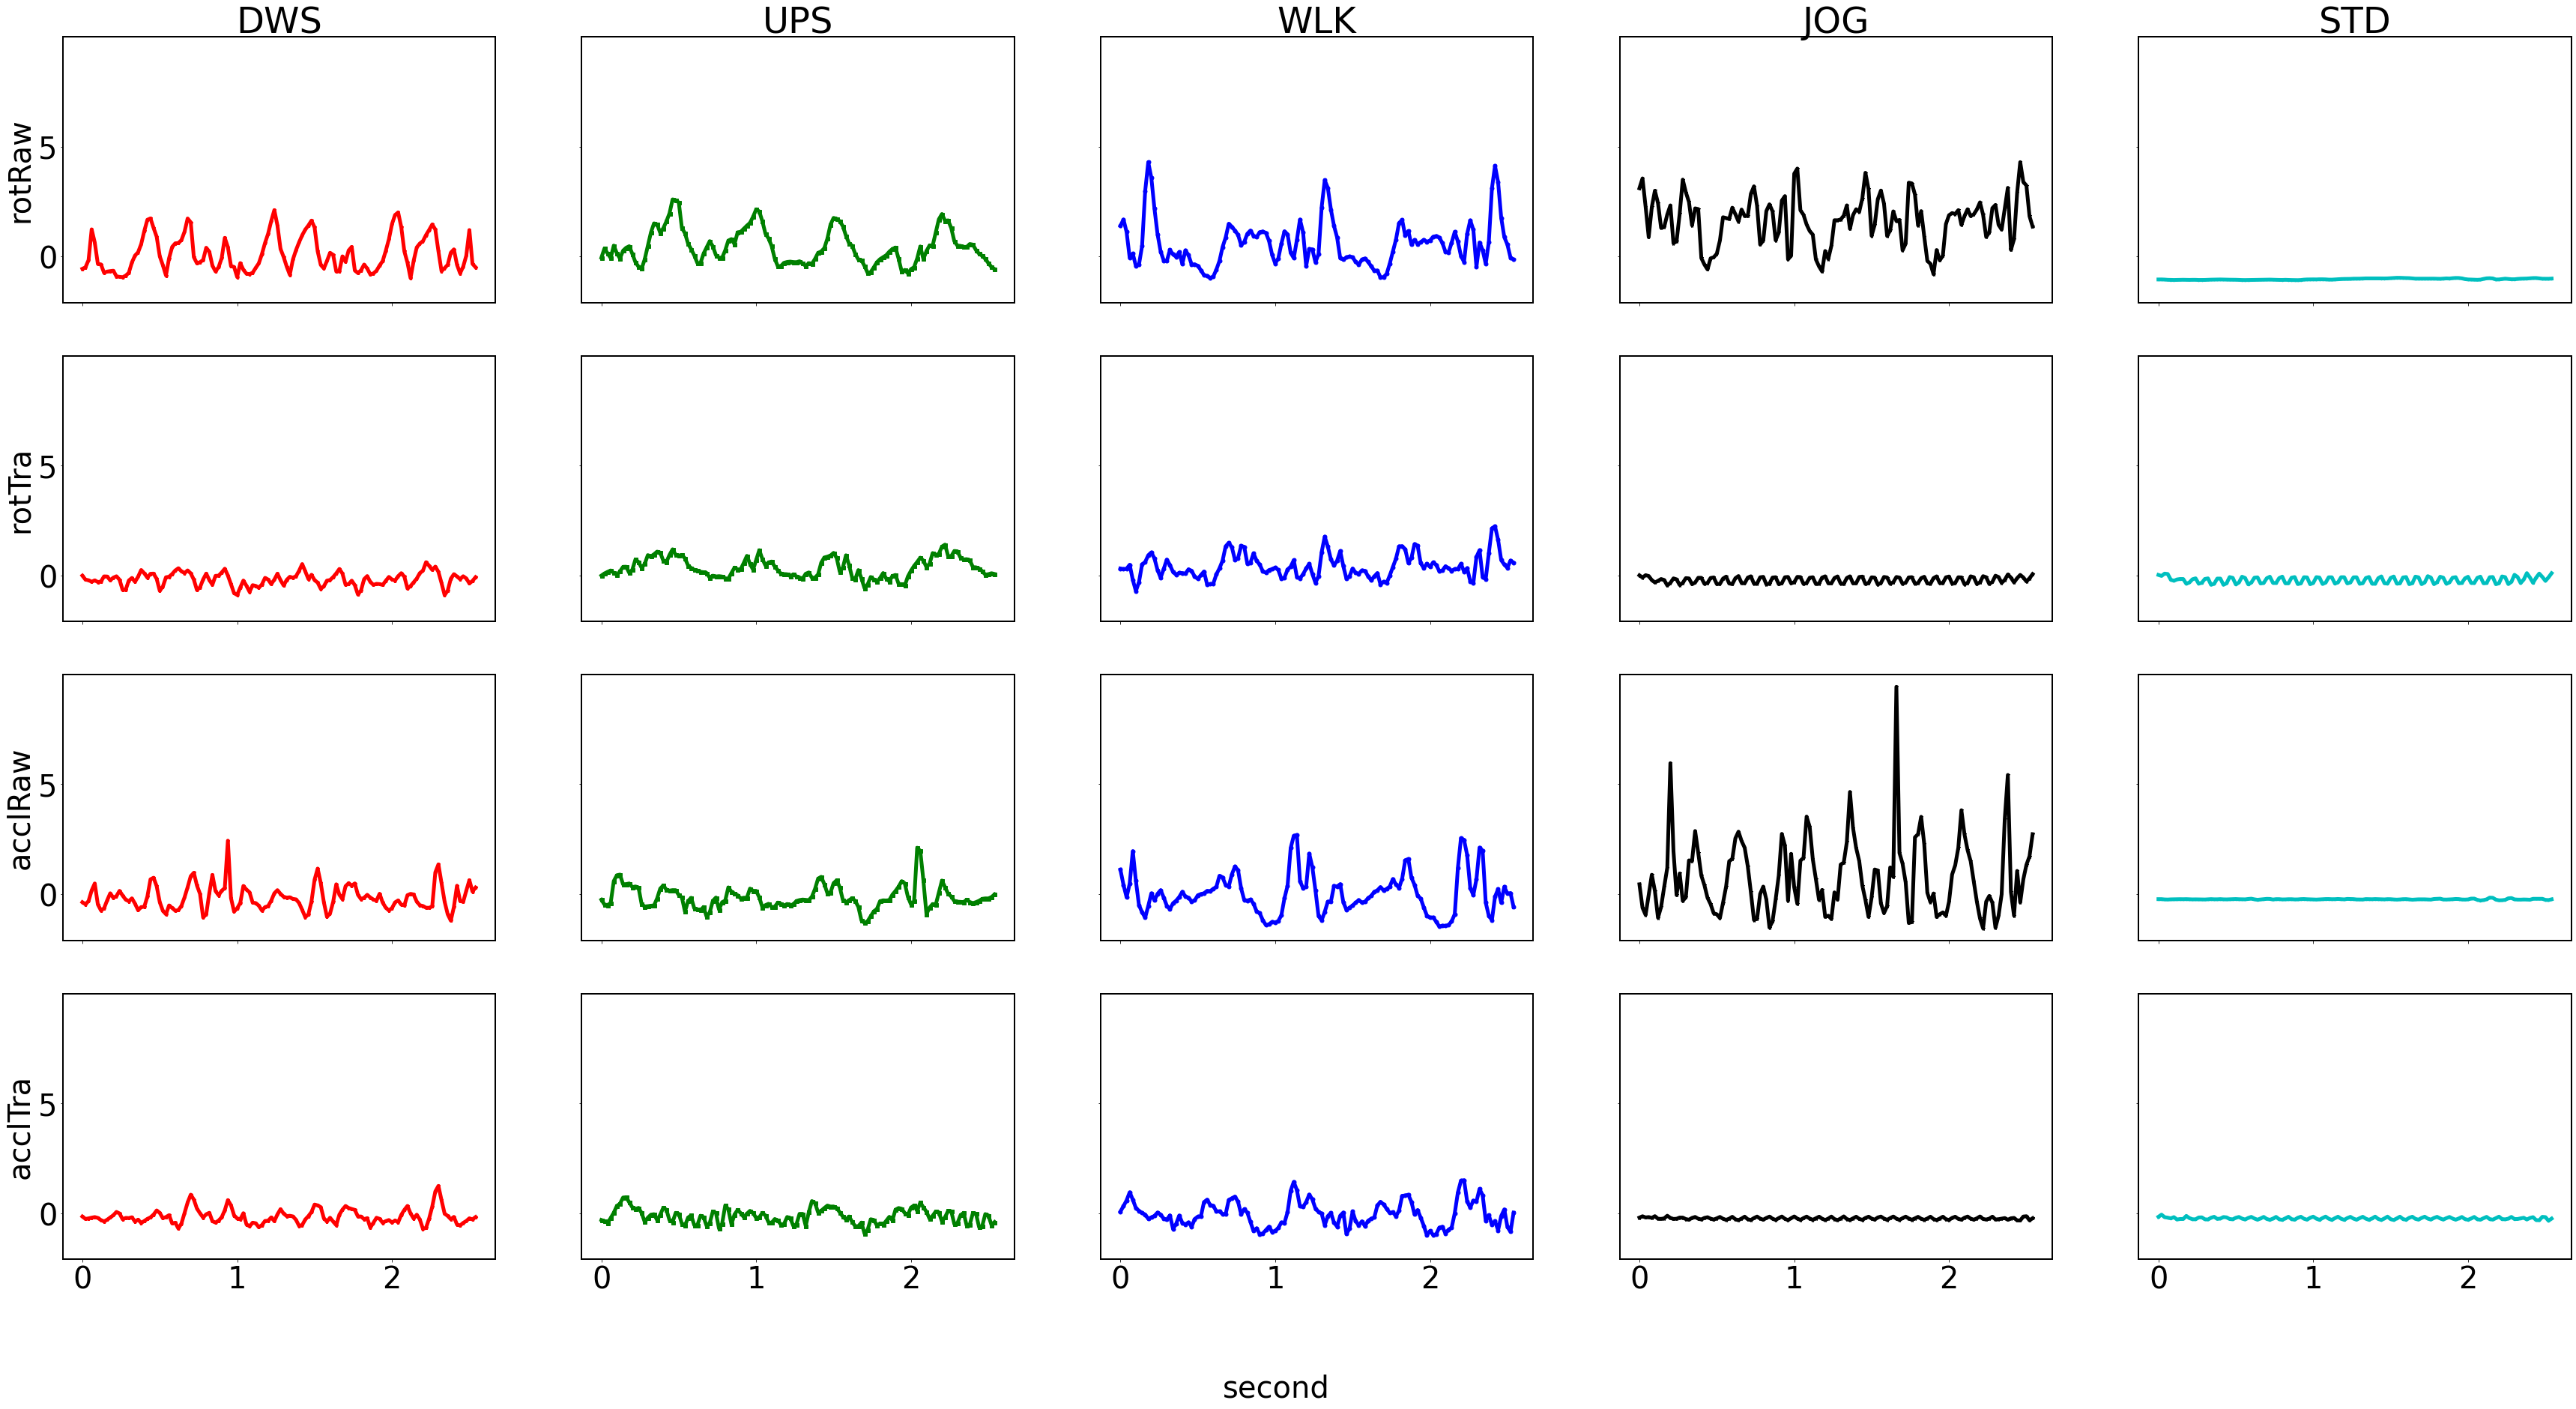

In [57]:
#rnd_smpl= np.random.randint(100)
pts = 128
print("Random Test Sample: #"+str(rnd_smpl))
plot_signals(rnd_smpl, pts, test_data, rep_anon_test)

In [58]:
loss_weights=[1, 1, 1]            
anon_model,rcon_task, rcon_id = build_AAE(loss_weights)
anon_model.summary()

Model: "anon"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 2, 128, 1)]  0           []                               
                                                                                                  
 Encoder (Functional)           (None, 2, 32, 1)     84165       ['input_18[0][0]']               
                                                                                                  
 Decoder (Functional)           (None, 2, 128, 1)    84161       ['Encoder[0][0]']                
                                                                                                  
 DecReg (Functional)            (None, 1)            78497       ['Decoder[0][0]']                
                                                                                               

In [59]:
for itr in range(0,iterations):

    print("______________________________________")
    print("[INFO] --  Epoch: "+str(itr))

    if itr == 0:
        print("--> Initialize...")
        a_data_nsh = w_data_train_rep.copy()
    
    a_data, a_data_org, id_a_data, act_a_data = shuffle(a_data_nsh, w_data_train_rep.copy(), w_gen_train_labels, rw_act_labels) 
    
    early_stop = keras.callbacks.EarlyStopping(monitor='val_acc', mode = 'max', patience=10, restore_best_weights=True)
    print("______________________________________")
    rcon_id.fit(a_data, id_a_data,
                        validation_split = .2,
                           epochs = ep2,
                           batch_size = batch_size,
                           class_weight = get_class_weights(id_a_data),   
                           verbose = 0,
                           callbacks = [early_stop]
                          )
    print("______________________________________")
    rcon_task.fit(a_data, act_a_data,
                        validation_split = .2,
                           epochs = ep3,
                           batch_size = batch_size,
                           class_weight = get_class_weights(np.argmax(act_a_data,axis=1)),       
                           verbose = 0,
                           callbacks = [early_stop]
                          )
    print("______________________________________")
    print("[INFO] --  (D) anon: "+str(itr))    
    early_stop_anon = keras.callbacks.EarlyStopping(monitor='val_loss', mode = 'min', patience=15, restore_best_weights=True)

    
    anon_model.fit(a_data, [a_data_org,
                            #eq_w_gen_labels,
                            eq_w_gen_labels,
                            act_a_data],
                   validation_split = .1,
                   epochs = ep4,
                   batch_size = 128,
                   verbose = 0,
                   callbacks = [early_stop_anon]
                  )
    
    z_data_nsh = anon_model.layers[1].predict(w_data_train_rep, verbose = 1)    
    a_data_nsh = anon_model.predict(w_data_train_rep, verbose = 1)[0]
    
    anon_model.save("gen_anon_111_"+str(itr)+".hdf5")
    print("[INFO] --  Saved model to disk: itr "+str(itr))

______________________________________
[INFO] --  Epoch: 0
--> Initialize...
______________________________________
______________________________________
______________________________________
[INFO] --  (D) anon: 0
1561/1561 [==============================] - 8s 5ms/step
[INFO] --  Saved model to disk: itr 0


In [60]:
itr = 0
anon_model_l = load_model("gen_anon_111_"+str(itr)+".hdf5")
rep_anon_test = anon_model_l.predict(rep_x_test, verbose = 1)[0]

X = rep_anon_test
Y = act_test_labels

print_results(eval_act, X, Y)

eval_gen = load_model("GR.hdf5")
result1 = eval_gen.evaluate(rep_anon_test, gen_test_labels, verbose = 2)
act_acc = round(result1[1],4)*100
print("***[RESULT]***GEN Test Accuracy: "+str(act_acc))

663/663 [==============================] - 4s 5ms/step
663/663 - 2s - loss: 3.2124 - acc: 0.3251 - 2s/epoch - 3ms/step
***[RESULT]*** ACT Accuracy: 32.51
663/663 [==============================] - 2s 2ms/step
***[RESULT]*** ACT  Confusion Matrix
dws | ups | wlk | jog | std
[[ 56.8  43.2   0.1   0.    0. ]
 [  0.   99.8   0.1   0.    0. ]
 [ 28.8  18.2  53.    0.    0. ]
 [  2.4   6.1  91.4   0.    0.1]
 [  0.    0.  100.    0.    0. ]]
***[RESULT]*** ACT Averaged F-1 Score : 29.637807740805922
663/663 - 2s - loss: 1.0786 - acc: 0.5014 - 2s/epoch - 3ms/step
***[RESULT]***GEN Test Accuracy: 50.13999999999999


Random Test Sample: #66


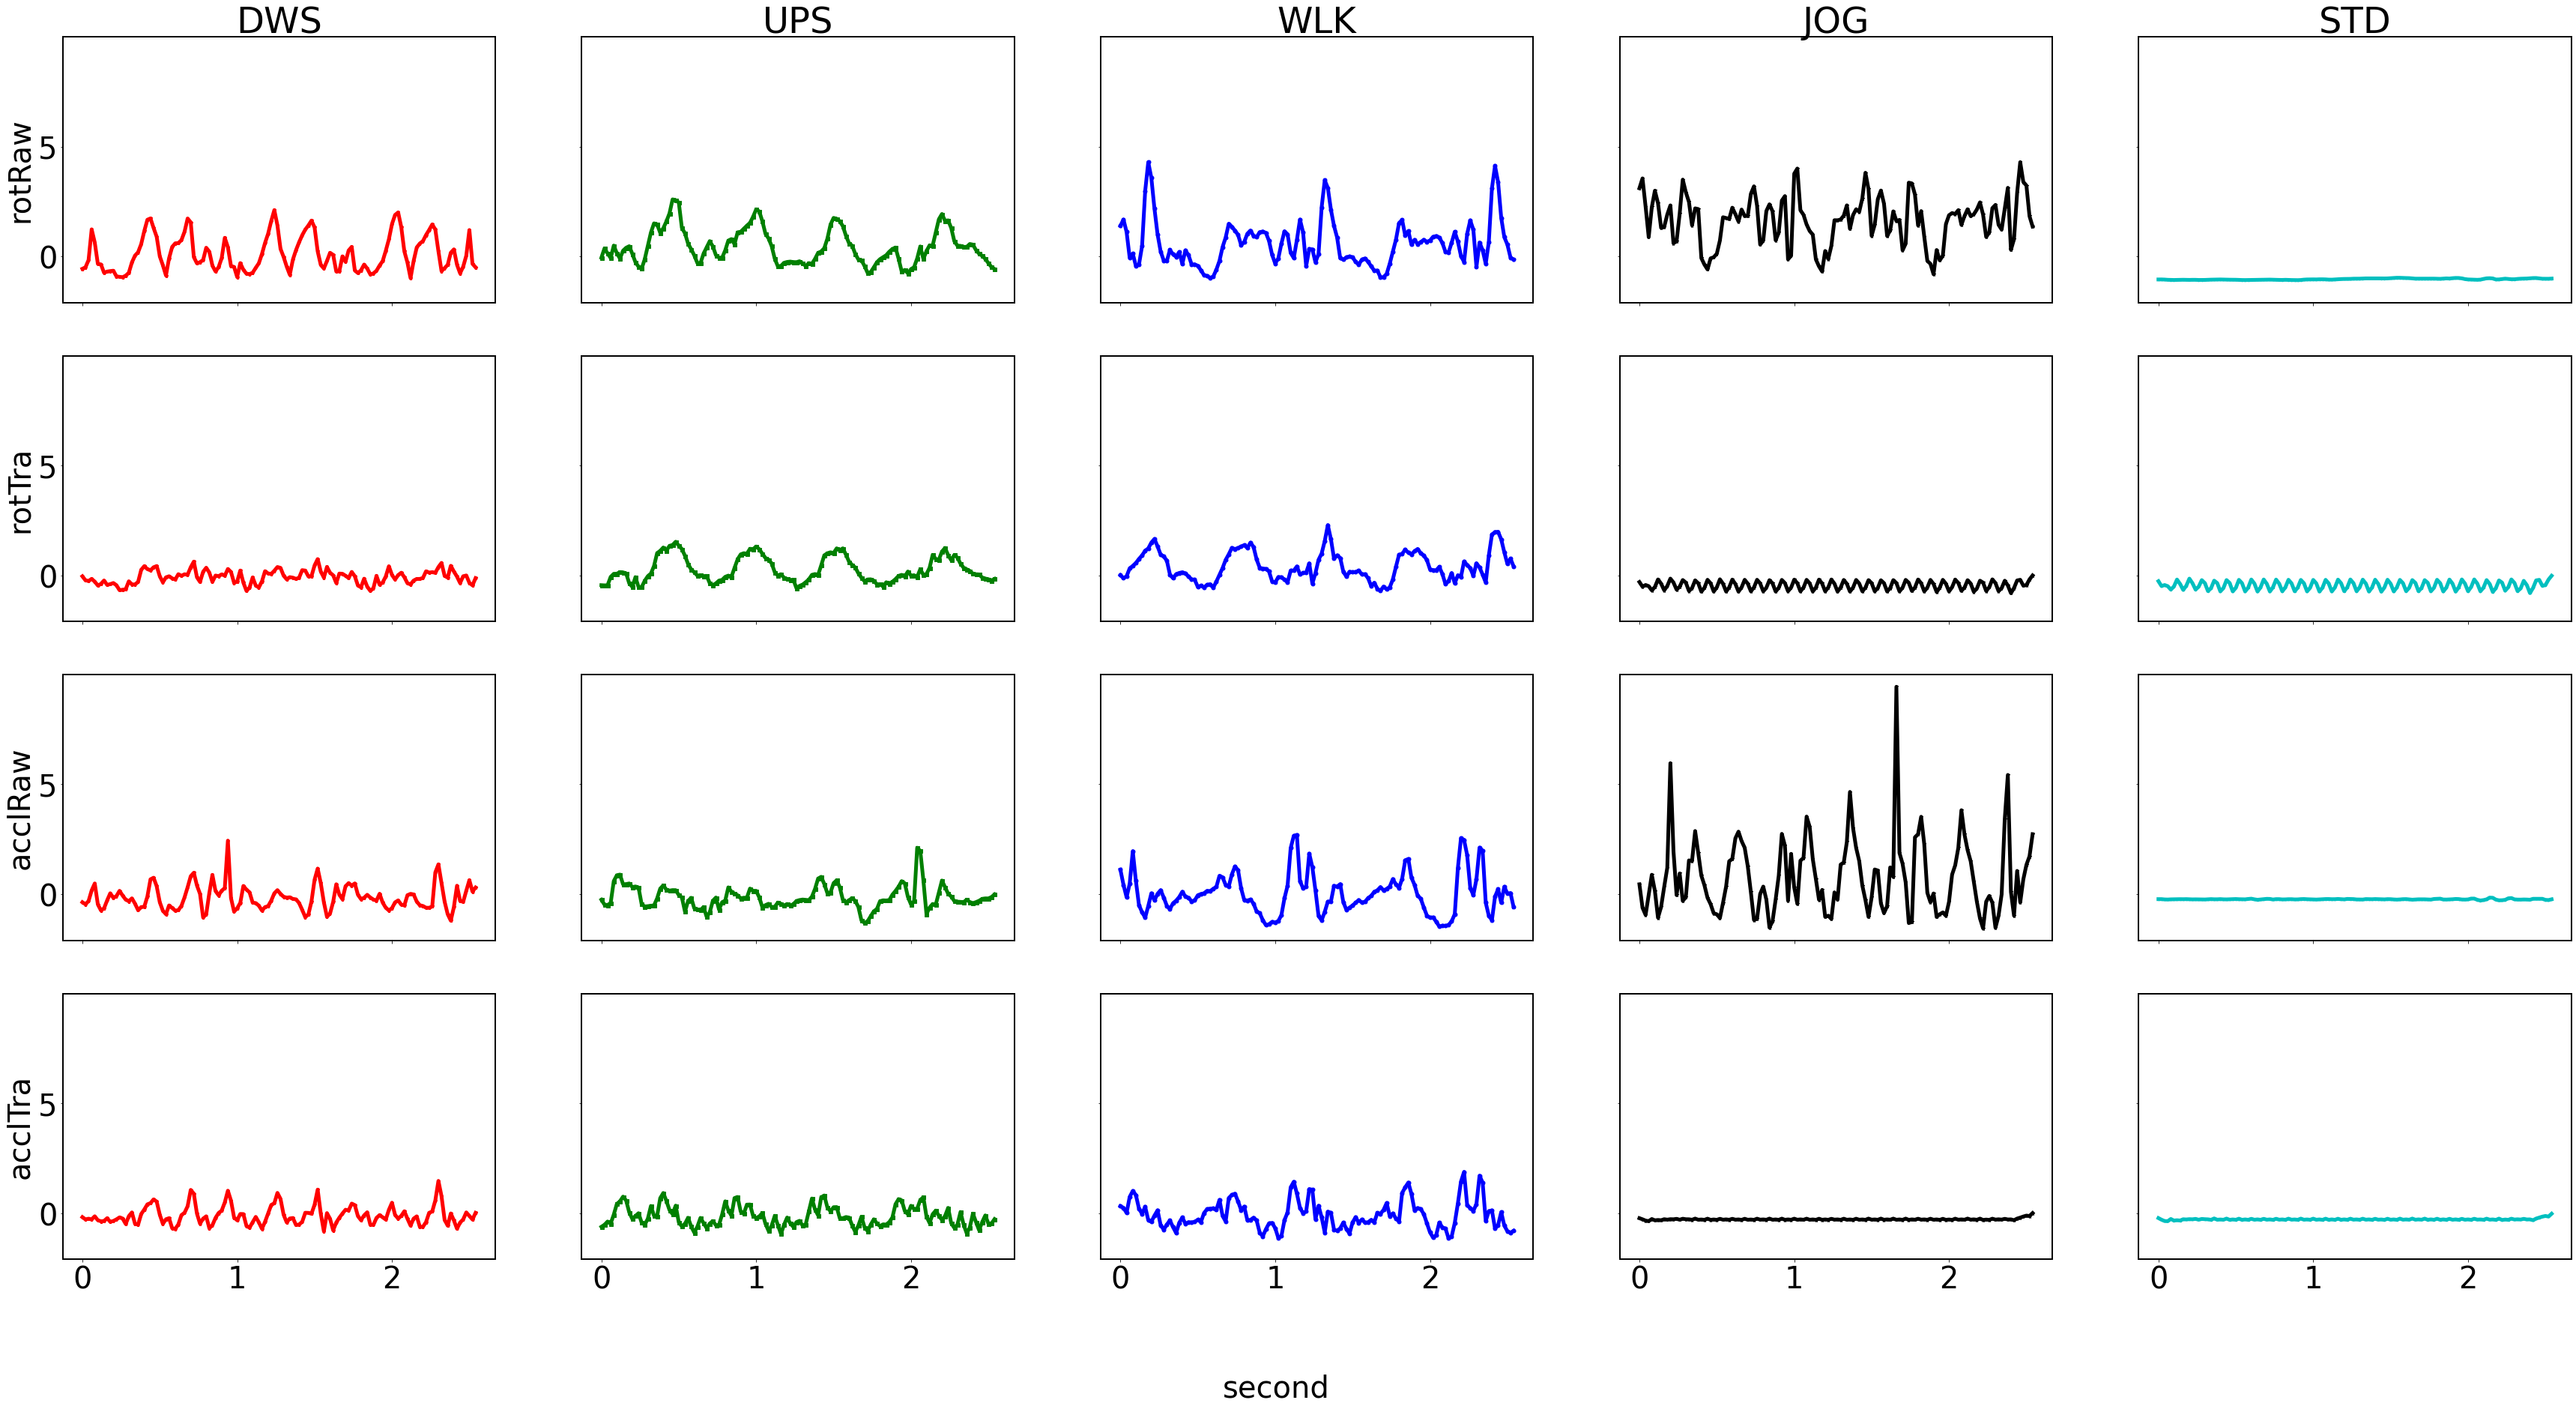

In [61]:
#rnd_smpl= np.random.randint(100)
pts = 128
print("Random Test Sample: #"+str(rnd_smpl))
plot_signals(rnd_smpl, pts, test_data, rep_anon_test)